In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#%cd /content/drive/MyDrive/

# Home Credit Revolving loans/Consumer loans 24か月

In [3]:
import torch
# GPUの名称、CUDA Compute Capabilityを取得
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 2080 Ti


In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6538264758935546570
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9399762944
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9502220876101368315
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:22:00.0, compute capability: 7.5"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 1745276110
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17722549263298599596
 physical_device_desc: "device: 1, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 2144165316]

In [5]:
import cupy as cp
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
from sklearn.datasets import make_moons

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from keras.layers import Dense, Dropout
from keras.models import Sequential

from six import StringIO

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats
import numpy as np
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import feature_column
from tensorflow.keras import layers

from tqdm import tqdm

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

print("OK\n")

OK



In [6]:
app_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train.csv')
app_test_origin =  pd.read_csv('./home-credit-default-risk/exports/app_test.csv')
app_hc_train_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_hc_rev-cons_axis-24-monthes.csv')
app_hc_test_origin =  pd.read_csv('./home-credit-default-risk/datasets/app_test_hc_rev-cons_axis-24-monthes.csv')
app_train_origin.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0  ...                 0                        0.0   
1  ...                 0                        0.0   
2  ...                 0                        0.0   
3  ...                 0                        NaN   
4  ...                 0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                         1.0     0.060749              -0.067329   
1                         0.0     0.027598              -0.070862   
2                         0.0     0.050000              -0.011814   
3                         NaN     0.094941              -0.159905   
4                         0.0     0.042623              -0.152418   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             16.461104               False                  1.158397   
1             36.234085               False                  1.145199   
2             20.000000               False                  1.000000   
3             10.532818               False                  1.052803   
4             23.461618               False                  1.000000   

   credit_downpayment    AGE_INT  
0            -55597.5 -25.920548  
1           -164002.5 -45.931507  
2                 0.0 -52.180822  
3            -15682.5 -52.068493  
4                 0.0 -54.608219  

[5 rows x 93 columns]

## applicationの欠損値を補完

In [7]:
# applicationの欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
app_train_origin_replace = pd.DataFrame(imputer.fit_transform(app_train_origin[replace_columns].copy()), columns=replace_columns)
app_test_origin_replace = pd.DataFrame(imputer.fit_transform(app_test_origin[replace_columns].copy()), columns=replace_columns)
app_test_origin_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_13  FLAG_DOCUMENT_16  \
0               0.0  ...               0.0               0.0   
1               0.0  ...               0.0               0.0   
2               0.0  ...               0.0               0.0   
3               0.0  ...               0.0               0.0   
4               0.0  ...               0.0               0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  \
0                   0.000000                    0.000000     0.036147   
1                   0.000000                    3.000000     0.077973   
2                   0.000000                    4.000000     0.105202   
3                   0.000000                    3.000000     0.031123   
4                   0.010242                    1.748333     0.051266   

   DAYS_EMPLOYED_PERCENT  credit_annuity_ratio  credit_goods_price_ratio  \
0               0.121044             19.775662                    1.2640   
1               0.247398             74.467617                    1.2376   
2               0.222477              1.934735                    1.0528   
3               0.133515              6.378867                    1.0000   
4               0.168021             15.997755                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 91 columns]

In [8]:
# 欠損値を補完した列を再結合
app_train_origin[replace_columns] = app_train_origin_replace[replace_columns]
app_test_origin[replace_columns] = app_test_origin_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [9]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

## OriginデータのCOPY

In [10]:
app_train = app_train_origin.copy()
app_test = app_test_origin.copy()
app_hc_train = app_hc_train_origin.copy()
app_hc_test = app_hc_test_origin.copy()
app_test.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [11]:
app_br_train = app_hc_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_br_test = app_hc_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

243

In [12]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

## 前処理

In [13]:
app_hc_train = app_hc_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_hc_test = app_hc_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

243

In [14]:
# trainへマージ
app_train = pd.merge(app_train, app_hc_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test, app_hc_test, on='SK_ID_CURR', how='left')
len(app_test)

48744

In [15]:
app_test.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  hc_re_cons_max_sk_dpd  hc_re_cons_min_sk_dpd  \
0               0.0  ...                    NaN                    NaN   
1               0.0  ...                    NaN                    NaN   
2               0.0  ...                    NaN                    NaN   
3               0.0  ...                    NaN                    NaN   
4               0.0  ...                    NaN                    NaN   

   hc_re_cons_sum_sk_dpd  hc_re_cons_avg_sk_dpd  hc_re_cons_cnt_sk_dpd  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   hc_re_cons_stddev_sk_dpd  hc_re_cons_stddev_pop_sk_dpd  \
0                       NaN                           NaN   
1                       NaN                           NaN   
2                       NaN                           NaN   
3                       NaN                           NaN   
4                       NaN                           NaN   

   hc_re_cons_var_pop_sk_dpd  hc_re_cons_var_samp_sk_dpd  \
0                        NaN                         NaN   
1                        NaN                         NaN   
2                        NaN                         NaN   
3                        NaN                         NaN   
4                        NaN                         NaN   

   hc_re_cons_variance_samp_sk_dpd  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  

[5 rows x 182 columns]

### name_contract_type

In [16]:
#columns = ['name_contract_type']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_max_amt_annuity

In [17]:
app_train[['TARGET', 'hc_re_cons_max_amt_annuity']].corr()

TARGET  hc_re_cons_max_amt_annuity
TARGET                      1.000000                   -0.045831
hc_re_cons_max_amt_annuity -0.045831                    1.000000

The correlation between hc_re_cons_max_amt_annuity and the TARGET is -0.0458
Median value for loan that was not repaid = 8910.4725
Median value for loan that was repaid =     10081.9800


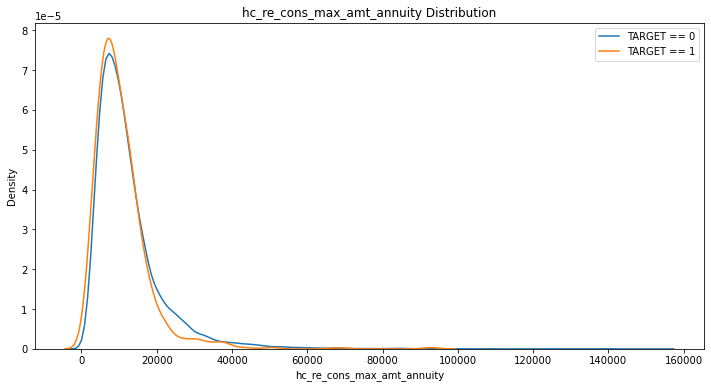

In [18]:
kde_target('hc_re_cons_max_amt_annuity', app_train)

In [19]:
app_train['hc_re_cons_max_amt_annuity'].isnull().sum()

286904

In [20]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_max_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_max_amt_annuity  
0  52.715068                21537.080972  
1  49.490411                12246.487056  
2  54.898630                25431.089056  
3  38.290411                50782.186211  
4  35.726027                24109.863791  

[5 rows x 92 columns]

In [21]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [22]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [23]:
app_train['hc_re_cons_max_amt_annuity'].isnull().sum()

0

In [24]:
app_train[['TARGET', 'hc_re_cons_max_amt_annuity']].corr()

TARGET  hc_re_cons_max_amt_annuity
TARGET                      1.000000                   -0.020511
hc_re_cons_max_amt_annuity -0.020511                    1.000000

In [25]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_max_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_max_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_max_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_max_amt_annuity']].corr()

TARGET  hc_re_cons_max_amt_annuity
TARGET                      1.000000                   -0.028257
hc_re_cons_max_amt_annuity -0.028257                    1.000000

In [26]:
## 標準化
num_cols = ['hc_re_cons_max_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_max_amt_annuity', 'TARGET']].corr()

hc_re_cons_max_amt_annuity    TARGET
hc_re_cons_max_amt_annuity                    1.000000 -0.028257
TARGET                                       -0.028257  1.000000

The correlation between hc_re_cons_max_amt_annuity and the TARGET is -0.0283
Median value for loan that was not repaid = -0.1389
Median value for loan that was repaid =     -0.0418


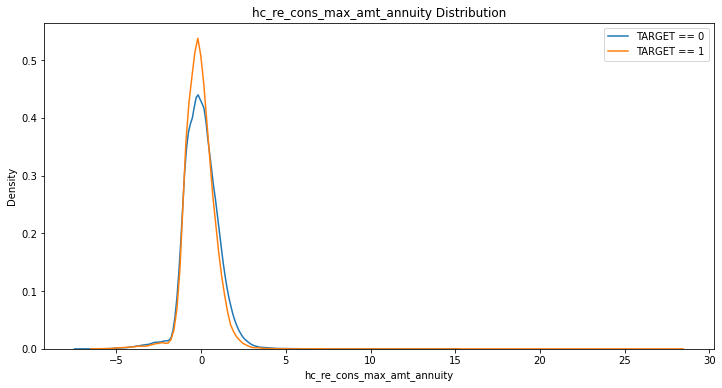

In [27]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_max_amt_annuity', app_train)

### hc_re_cons_min_amt_annuity

In [28]:
app_train[['TARGET', 'hc_re_cons_min_amt_annuity']].corr()

TARGET  hc_re_cons_min_amt_annuity
TARGET                      1.000000                   -0.037716
hc_re_cons_min_amt_annuity -0.037716                    1.000000

The correlation between hc_re_cons_min_amt_annuity and the TARGET is -0.0377
Median value for loan that was not repaid = 7240.9950
Median value for loan that was repaid =     8185.6350


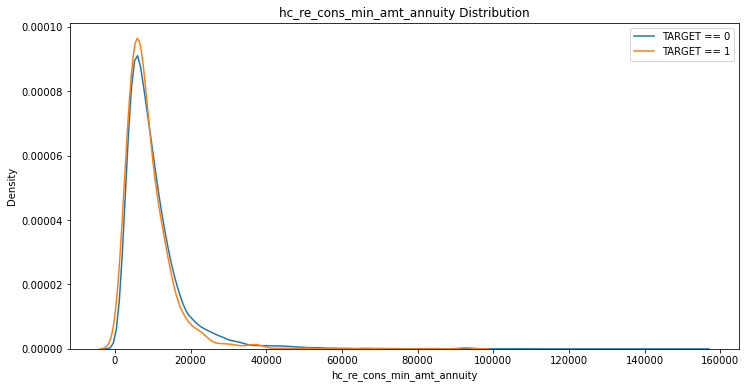

In [29]:
kde_target('hc_re_cons_min_amt_annuity', app_train)

In [30]:
app_train['hc_re_cons_min_amt_annuity'].isnull().sum()

286904

In [31]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_min_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_min_amt_annuity  
0  52.715068                19909.854477  
1  49.490411                 9705.178083  
2  54.898630                24217.140766  
3  38.290411                52356.919947  
4  35.726027                22849.887845  

[5 rows x 92 columns]

In [32]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [33]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [34]:
app_train['hc_re_cons_min_amt_annuity'].isnull().sum()

0

In [35]:
app_train[['TARGET', 'hc_re_cons_min_amt_annuity']].corr()

TARGET  hc_re_cons_min_amt_annuity
TARGET                      1.00000                    -0.02422
hc_re_cons_min_amt_annuity -0.02422                     1.00000

In [36]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_min_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_min_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_min_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_min_amt_annuity']].corr()

TARGET  hc_re_cons_min_amt_annuity
TARGET                      1.000000                   -0.029126
hc_re_cons_min_amt_annuity -0.029126                    1.000000

In [37]:
## 標準化
num_cols = ['hc_re_cons_min_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_min_amt_annuity', 'TARGET']].corr()

hc_re_cons_min_amt_annuity    TARGET
hc_re_cons_min_amt_annuity                    1.000000 -0.029126
TARGET                                       -0.029126  1.000000

The correlation between hc_re_cons_min_amt_annuity and the TARGET is -0.0291
Median value for loan that was not repaid = -0.1661
Median value for loan that was repaid =     -0.0450


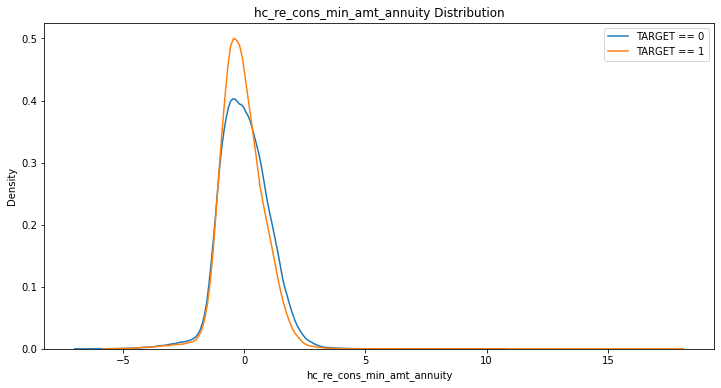

In [38]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_min_amt_annuity', app_train)

### hc_re_cons_sum_amt_annuity

In [39]:
app_train[['TARGET', 'hc_re_cons_sum_amt_annuity']].corr()

TARGET  hc_re_cons_sum_amt_annuity
TARGET                      1.00000                    -0.03125
hc_re_cons_sum_amt_annuity -0.03125                     1.00000

The correlation between hc_re_cons_sum_amt_annuity and the TARGET is -0.0312
Median value for loan that was not repaid = 570706.1550
Median value for loan that was repaid =     760238.6400


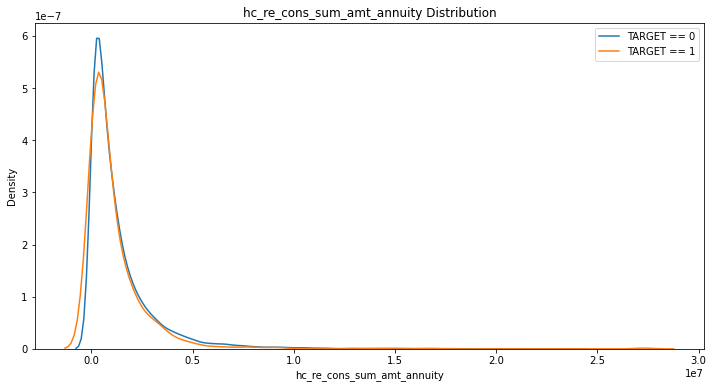

In [40]:
kde_target('hc_re_cons_sum_amt_annuity', app_train)

In [41]:
app_train['hc_re_cons_sum_amt_annuity'].isnull().sum()

286904

In [42]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_sum_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_sum_amt_annuity  
0  52.715068                2.015319e+06  
1  49.490411                1.699361e+06  
2  54.898630                2.146528e+06  
3  38.290411                3.066287e+06  
4  35.726027                2.119361e+06  

[5 rows x 92 columns]

In [43]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [44]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()


SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [45]:
app_train['hc_re_cons_sum_amt_annuity'].isnull().sum()

0

In [46]:
app_train[['TARGET', 'hc_re_cons_sum_amt_annuity']].corr()

TARGET  hc_re_cons_sum_amt_annuity
TARGET                      1.000000                   -0.027754
hc_re_cons_sum_amt_annuity -0.027754                    1.000000

In [47]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_sum_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_sum_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_sum_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_sum_amt_annuity']].corr()

TARGET  hc_re_cons_sum_amt_annuity
TARGET                      1.000000                   -0.026451
hc_re_cons_sum_amt_annuity -0.026451                    1.000000

In [48]:
## 標準化
num_cols = ['hc_re_cons_sum_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_sum_amt_annuity', 'TARGET']].corr()

hc_re_cons_sum_amt_annuity    TARGET
hc_re_cons_sum_amt_annuity                    1.000000 -0.026451
TARGET                                       -0.026451  1.000000

The correlation between hc_re_cons_sum_amt_annuity and the TARGET is -0.0265
Median value for loan that was not repaid = -0.1305
Median value for loan that was repaid =     -0.0643


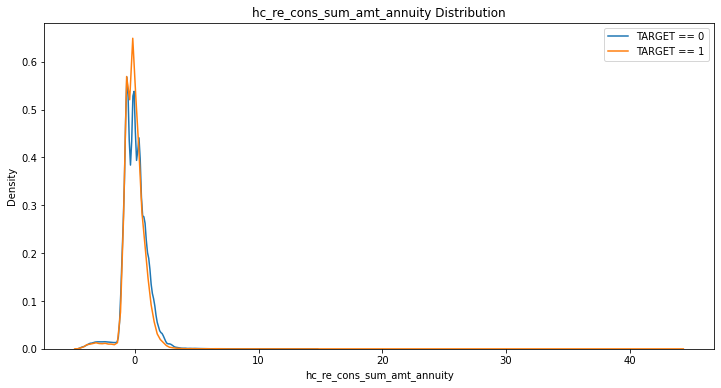

In [49]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_sum_amt_annuity', app_train)

### hc_re_cons_avg_amt_annuity

In [50]:
app_train[['TARGET', 'hc_re_cons_avg_amt_annuity']].corr()

TARGET  hc_re_cons_avg_amt_annuity
TARGET                      1.000000                   -0.041397
hc_re_cons_avg_amt_annuity -0.041397                    1.000000

The correlation between hc_re_cons_avg_amt_annuity and the TARGET is -0.0414
Median value for loan that was not repaid = 8231.3951
Median value for loan that was repaid =     9247.0950


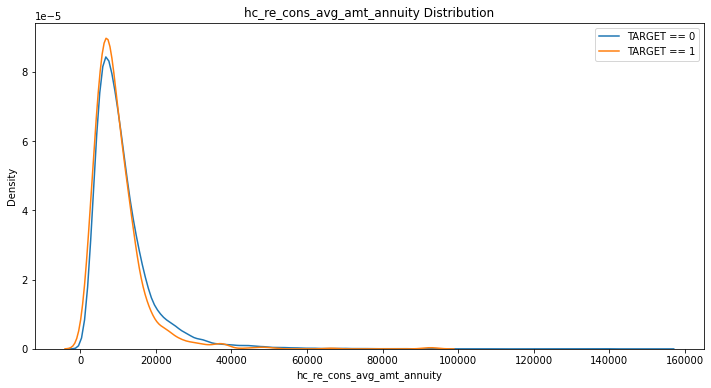

In [51]:
kde_target('hc_re_cons_avg_amt_annuity', app_train)

In [52]:
app_train['hc_re_cons_avg_amt_annuity'].isnull().sum()

286904

In [53]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_avg_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_avg_amt_annuity  
0  52.715068                21050.139023  
1  49.490411                10994.262865  
2  54.898630                25265.909226  
3  38.290411                52703.355515  
4  35.726027                23842.771149  

[5 rows x 92 columns]

In [54]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [55]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [56]:
app_train['hc_re_cons_avg_amt_annuity'].isnull().sum()

0

In [57]:
app_train[['TARGET', 'hc_re_cons_avg_amt_annuity']].corr()

TARGET  hc_re_cons_avg_amt_annuity
TARGET                      1.000000                   -0.024837
hc_re_cons_avg_amt_annuity -0.024837                    1.000000

In [58]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_avg_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_avg_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_avg_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_avg_amt_annuity']].corr()

TARGET  hc_re_cons_avg_amt_annuity
TARGET                      1.00000                    -0.03118
hc_re_cons_avg_amt_annuity -0.03118                     1.00000

In [59]:
## 標準化
num_cols = ['hc_re_cons_avg_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_avg_amt_annuity', 'TARGET']].corr()

hc_re_cons_avg_amt_annuity   TARGET
hc_re_cons_avg_amt_annuity                     1.00000 -0.03118
TARGET                                        -0.03118  1.00000

The correlation between hc_re_cons_avg_amt_annuity and the TARGET is -0.0312
Median value for loan that was not repaid = -0.1744
Median value for loan that was repaid =     -0.0467


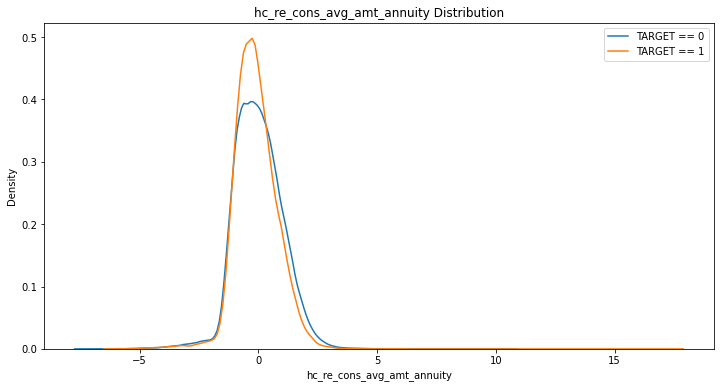

In [60]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_avg_amt_annuity', app_train)

### hc_re_cons_cnt_amt_annuity

In [61]:
app_train[['TARGET', 'hc_re_cons_cnt_amt_annuity']].corr()

TARGET  hc_re_cons_cnt_amt_annuity
TARGET                      1.000000                   -0.023163
hc_re_cons_cnt_amt_annuity -0.023163                    1.000000

The correlation between hc_re_cons_cnt_amt_annuity and the TARGET is -0.0232
Median value for loan that was not repaid = 64.0000
Median value for loan that was repaid =     81.0000


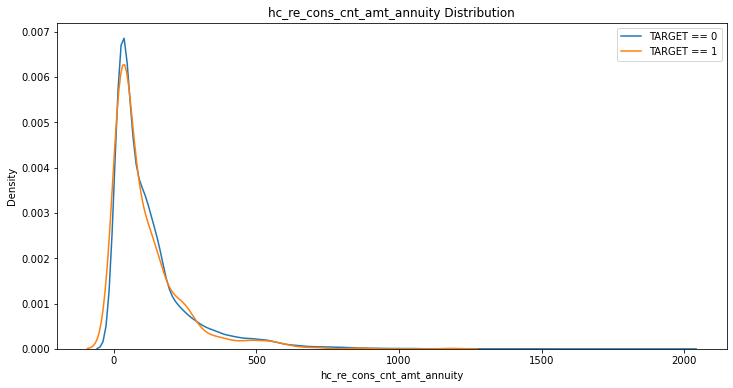

In [62]:
kde_target('hc_re_cons_cnt_amt_annuity', app_train)

In [63]:
app_train['hc_re_cons_cnt_amt_annuity'].isnull().sum()

286904

In [64]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_cnt_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_cnt_amt_annuity  
0  52.715068                  163.998265  
1  49.490411                  157.286037  
2  54.898630                  129.204913  
3  38.290411                   72.600350  
4  35.726027                  121.305041  

[5 rows x 92 columns]

In [65]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [66]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [67]:
app_train['hc_re_cons_cnt_amt_annuity'].isnull().sum()

0

In [68]:
app_train[['TARGET', 'hc_re_cons_cnt_amt_annuity']].corr()

TARGET  hc_re_cons_cnt_amt_annuity
TARGET                      1.00000                    -0.01208
hc_re_cons_cnt_amt_annuity -0.01208                     1.00000

In [69]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_cnt_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_cnt_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_cnt_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_cnt_amt_annuity']].corr()

TARGET  hc_re_cons_cnt_amt_annuity
TARGET                      1.000000                   -0.012089
hc_re_cons_cnt_amt_annuity -0.012089                    1.000000

In [70]:
## 標準化
num_cols = ['hc_re_cons_cnt_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_cnt_amt_annuity', 'TARGET']].corr()

hc_re_cons_cnt_amt_annuity    TARGET
hc_re_cons_cnt_amt_annuity                    1.000000 -0.012089
TARGET                                       -0.012089  1.000000

The correlation between hc_re_cons_cnt_amt_annuity and the TARGET is -0.0121
Median value for loan that was not repaid = -0.1295
Median value for loan that was repaid =     -0.0940


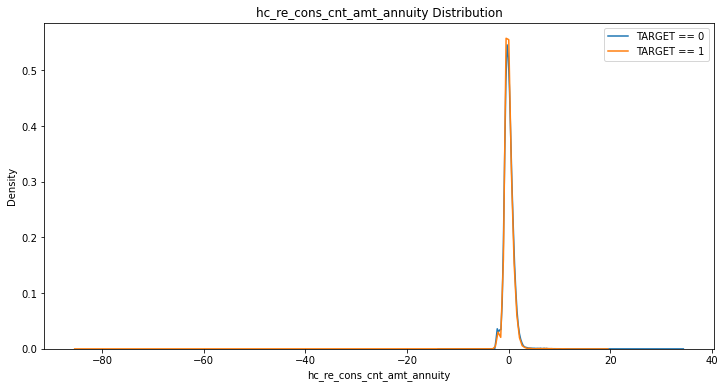

In [71]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_cnt_amt_annuity', app_train)

### hc_re_cons_stddev_amt_annuity

In [72]:
app_train[['TARGET', 'hc_re_cons_stddev_amt_annuity']].corr()

TARGET  hc_re_cons_stddev_amt_annuity
TARGET                         1.0000                        -0.0202
hc_re_cons_stddev_amt_annuity -0.0202                         1.0000

The correlation between hc_re_cons_stddev_amt_annuity and the TARGET is -0.0202
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


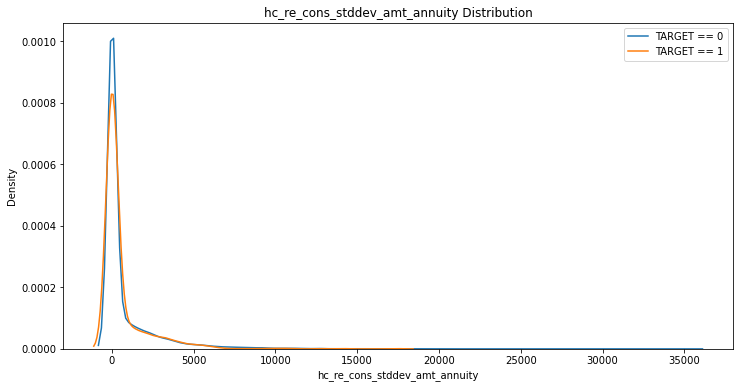

In [73]:
kde_target('hc_re_cons_stddev_amt_annuity', app_train)

In [74]:
app_train['hc_re_cons_stddev_amt_annuity'].isnull().sum()

286904

In [75]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_amt_annuity  
0  52.715068                     792.117167  
1  49.490411                    1028.626989  
2  54.898630                     645.164991  
3  38.290411                    -166.484294  
4  35.726027                     646.723584  

[5 rows x 92 columns]

In [76]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [77]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [78]:
app_train['hc_re_cons_stddev_amt_annuity'].isnull().sum()

0

In [79]:
app_train[['TARGET', 'hc_re_cons_stddev_amt_annuity']].corr()

TARGET  hc_re_cons_stddev_amt_annuity
TARGET                         1.000000                      -0.024645
hc_re_cons_stddev_amt_annuity -0.024645                       1.000000

In [80]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_stddev_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_stddev_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_stddev_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_stddev_amt_annuity']].corr()

In [81]:
## 標準化
num_cols = ['hc_re_cons_stddev_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_amt_annuity', 'TARGET']].corr()

hc_re_cons_stddev_amt_annuity    TARGET
hc_re_cons_stddev_amt_annuity                       1.000000 -0.024645
TARGET                                             -0.024645  1.000000

The correlation between hc_re_cons_stddev_amt_annuity and the TARGET is -0.0246
Median value for loan that was not repaid = -0.2302
Median value for loan that was repaid =     -0.1644


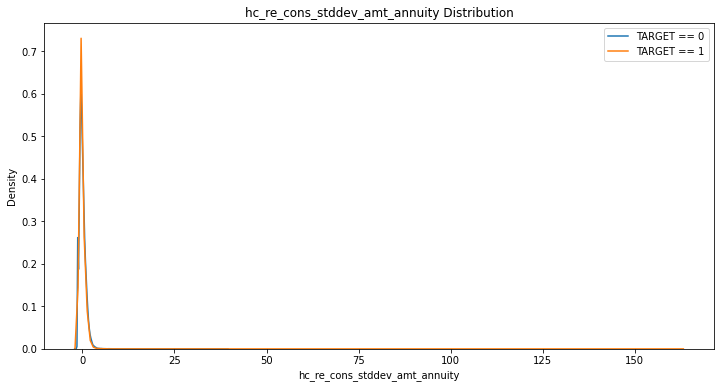

In [82]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_amt_annuity', app_train)

### hc_re_cons_stddev_pop_amt_annuity

In [83]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_annuity']].corr()

TARGET  hc_re_cons_stddev_pop_amt_annuity
TARGET                             1.0000                            -0.0202
hc_re_cons_stddev_pop_amt_annuity -0.0202                             1.0000

The correlation between hc_re_cons_stddev_pop_amt_annuity and the TARGET is -0.0202
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


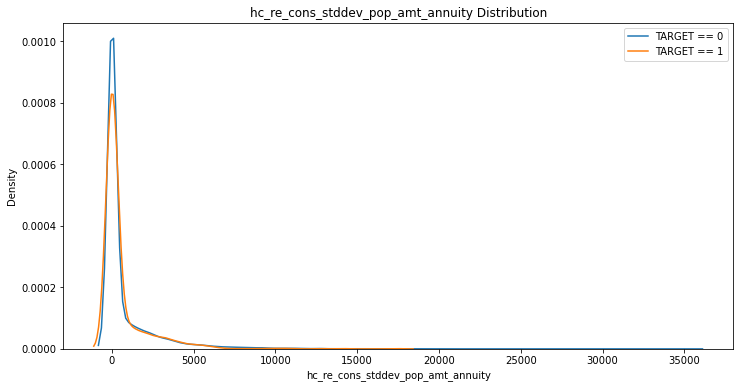

In [84]:
kde_target('hc_re_cons_stddev_pop_amt_annuity', app_train)

In [85]:
app_train['hc_re_cons_stddev_pop_amt_annuity'].isnull().sum()

286904

In [86]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_pop_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_pop_amt_annuity  
0  52.715068                         792.117167  
1  49.490411                        1028.626989  
2  54.898630                         645.164991  
3  38.290411                        -166.484294  
4  35.726027                         646.723584  

[5 rows x 92 columns]

In [87]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [88]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [89]:
app_train['hc_re_cons_stddev_pop_amt_annuity'].isnull().sum()

0

In [90]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_annuity']].corr()

TARGET  hc_re_cons_stddev_pop_amt_annuity
TARGET                             1.000000                          -0.024645
hc_re_cons_stddev_pop_amt_annuity -0.024645                           1.000000

In [91]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_stddev_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_stddev_pop_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_stddev_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_annuity']].corr()

In [92]:
## 標準化
num_cols = ['hc_re_cons_stddev_pop_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_pop_amt_annuity', 'TARGET']].corr()

hc_re_cons_stddev_pop_amt_annuity    TARGET
hc_re_cons_stddev_pop_amt_annuity                           1.000000 -0.024645
TARGET                                                     -0.024645  1.000000

The correlation between hc_re_cons_stddev_pop_amt_annuity and the TARGET is -0.0246
Median value for loan that was not repaid = -0.2302
Median value for loan that was repaid =     -0.1644


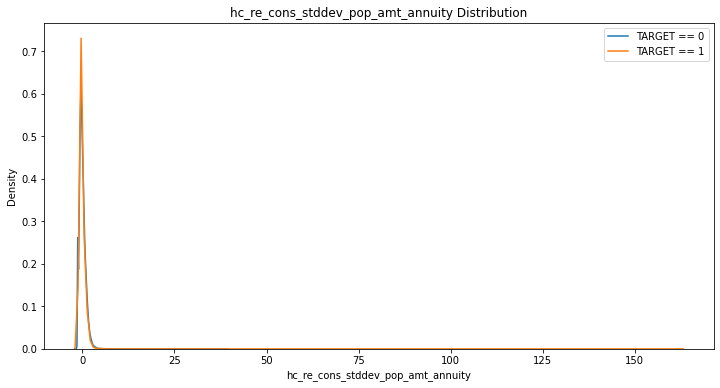

In [93]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_pop_amt_annuity', app_train)

### hc_re_cons_var_pop_amt_annuity

In [94]:
app_train[['TARGET', 'hc_re_cons_var_pop_amt_annuity']].corr()

TARGET  hc_re_cons_var_pop_amt_annuity
TARGET                          1.000000                       -0.016149
hc_re_cons_var_pop_amt_annuity -0.016149                        1.000000

The correlation between hc_re_cons_var_pop_amt_annuity and the TARGET is -0.0161
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


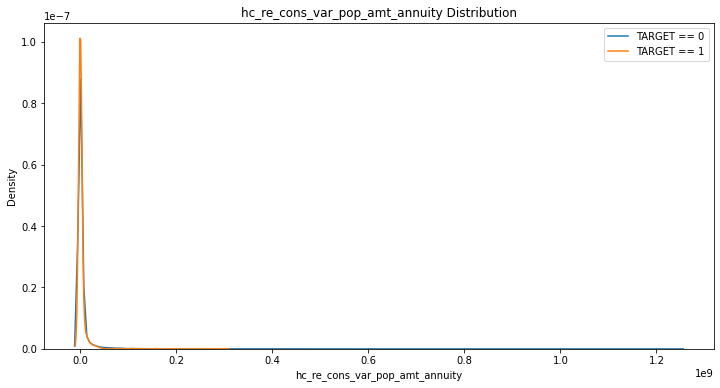

In [95]:
kde_target('hc_re_cons_var_pop_amt_annuity', app_train)

In [96]:
app_train['hc_re_cons_var_pop_amt_annuity'].isnull().sum()

286904

In [97]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_pop_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_pop_amt_annuity  
0  52.715068                    4.970315e+06  
1  49.490411                    5.772621e+06  
2  54.898630                    4.560974e+06  
3  38.290411                    1.992933e+06  
4  35.726027                    4.580925e+06  

[5 rows x 92 columns]

In [98]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [99]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [100]:
app_train['hc_re_cons_var_pop_amt_annuity'].isnull().sum()

0

In [101]:
app_train[['TARGET', 'hc_re_cons_var_pop_amt_annuity']].corr()

TARGET  hc_re_cons_var_pop_amt_annuity
TARGET                          1.000000                       -0.019538
hc_re_cons_var_pop_amt_annuity -0.019538                        1.000000

In [102]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_var_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_var_pop_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_var_pop_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_var_pop_amt_annuity']].corr()

In [103]:
## 標準化
num_cols = ['hc_re_cons_var_pop_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_pop_amt_annuity', 'TARGET']].corr()

hc_re_cons_var_pop_amt_annuity    TARGET
hc_re_cons_var_pop_amt_annuity                        1.000000 -0.019538
TARGET                                               -0.019538  1.000000

The correlation between hc_re_cons_var_pop_amt_annuity and the TARGET is -0.0195
Median value for loan that was not repaid = -0.1468
Median value for loan that was repaid =     -0.1019


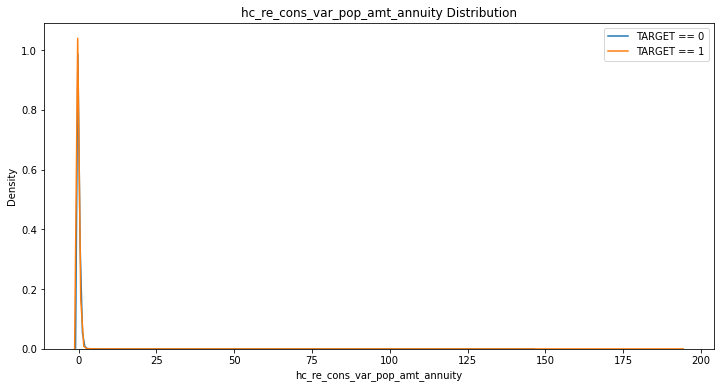

In [104]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_pop_amt_annuity', app_train)

### hc_re_cons_var_samp_amt_annuity

In [105]:
app_train[['TARGET', 'hc_re_cons_var_samp_amt_annuity']].corr()

TARGET  hc_re_cons_var_samp_amt_annuity
TARGET                           1.000000                        -0.016219
hc_re_cons_var_samp_amt_annuity -0.016219                         1.000000

The correlation between hc_re_cons_var_samp_amt_annuity and the TARGET is -0.0162
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


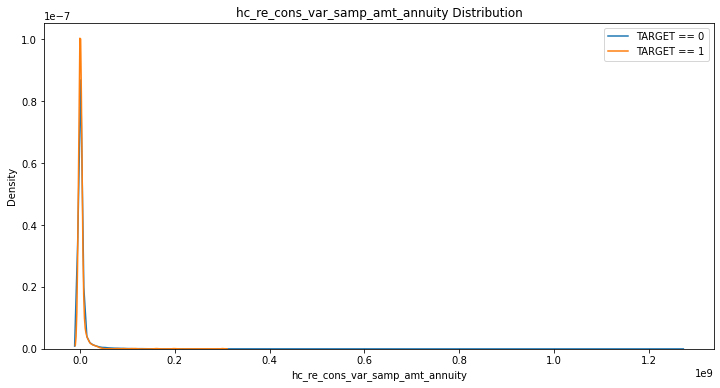

In [106]:
kde_target('hc_re_cons_var_samp_amt_annuity', app_train)

In [107]:
app_train['hc_re_cons_var_samp_amt_annuity'].isnull().sum()

286904

In [108]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_samp_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_samp_amt_annuity  
0  52.715068                     5.000183e+06  
1  49.490411                     5.817953e+06  
2  54.898630                     4.585234e+06  
3  38.290411                     1.970753e+06  
4  35.726027                     4.605546e+06  

[5 rows x 92 columns]

In [109]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [110]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [111]:
app_train['hc_re_cons_var_samp_amt_annuity'].isnull().sum()

0

In [112]:
app_train[['TARGET', 'hc_re_cons_var_samp_amt_annuity']].corr()

TARGET  hc_re_cons_var_samp_amt_annuity
TARGET                           1.000000                        -0.019622
hc_re_cons_var_samp_amt_annuity -0.019622                         1.000000

In [113]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_var_samp_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_var_samp_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_var_samp_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_var_samp_amt_annuity']].corr()

In [114]:
## 標準化
num_cols = ['hc_re_cons_var_samp_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_samp_amt_annuity', 'TARGET']].corr()

hc_re_cons_var_samp_amt_annuity    TARGET
hc_re_cons_var_samp_amt_annuity                         1.000000 -0.019622
TARGET                                                 -0.019622  1.000000

The correlation between hc_re_cons_var_samp_amt_annuity and the TARGET is -0.0196
Median value for loan that was not repaid = -0.1470
Median value for loan that was repaid =     -0.1019


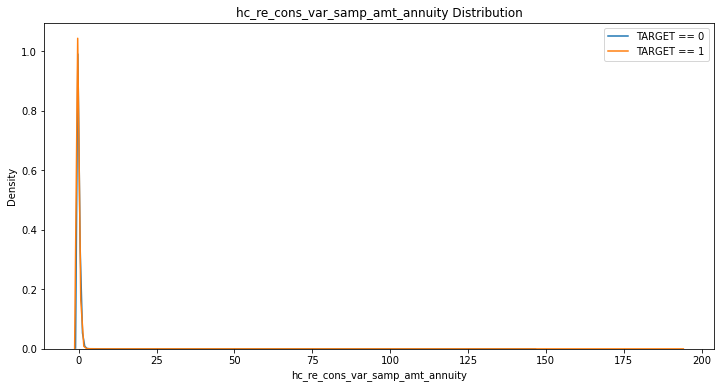

In [115]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_samp_amt_annuity', app_train)

### hc_re_cons_variance_samp_amt_annuity

In [116]:
app_train[['TARGET', 'hc_re_cons_variance_samp_amt_annuity']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_variance_samp_amt_annuity -0.016149   

                                      hc_re_cons_variance_samp_amt_annuity  
TARGET                                                           -0.016149  
hc_re_cons_variance_samp_amt_annuity                              1.000000

The correlation between hc_re_cons_variance_samp_amt_annuity and the TARGET is -0.0161
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


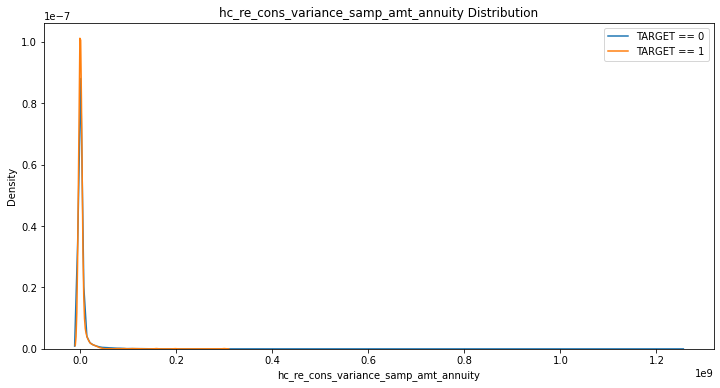

In [117]:
kde_target('hc_re_cons_variance_samp_amt_annuity', app_train)

In [118]:
app_train['hc_re_cons_variance_samp_amt_annuity'].isnull().sum()

286904

In [119]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_variance_samp_amt_annuity')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_variance_samp_amt_annuity  
0  52.715068                          4.970315e+06  
1  49.490411                          5.772621e+06  
2  54.898630                          4.560974e+06  
3  38.290411                          1.992933e+06  
4  35.726027                          4.580925e+06  

[5 rows x 92 columns]

In [120]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [121]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [122]:
app_train['hc_re_cons_variance_samp_amt_annuity'].isnull().sum()

0

In [123]:
app_train[['TARGET', 'hc_re_cons_variance_samp_amt_annuity']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_variance_samp_amt_annuity -0.019538   

                                      hc_re_cons_variance_samp_amt_annuity  
TARGET                                                           -0.019538  
hc_re_cons_variance_samp_amt_annuity                              1.000000

In [124]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_variance_samp_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_variance_samp_amt_annuity'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_variance_samp_amt_annuity'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_variance_samp_amt_annuity']].corr()

In [125]:
## 標準化
num_cols = ['hc_re_cons_variance_samp_amt_annuity']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_variance_samp_amt_annuity', 'TARGET']].corr()

hc_re_cons_variance_samp_amt_annuity  \
hc_re_cons_variance_samp_amt_annuity                              1.000000   
TARGET                                                           -0.019538   

                                        TARGET  
hc_re_cons_variance_samp_amt_annuity -0.019538  
TARGET                                1.000000

The correlation between hc_re_cons_variance_samp_amt_annuity and the TARGET is -0.0195
Median value for loan that was not repaid = -0.1468
Median value for loan that was repaid =     -0.1019


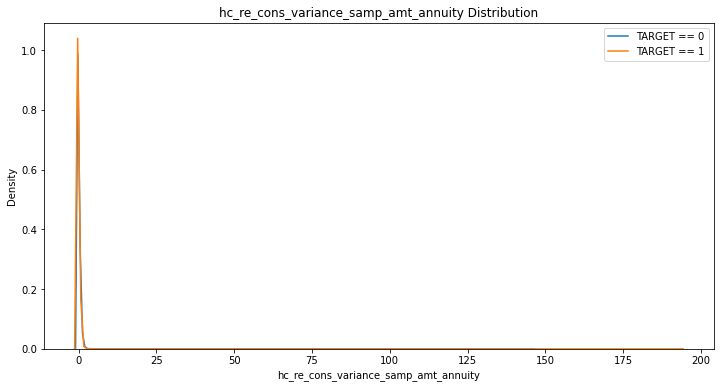

In [126]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_variance_samp_amt_annuity', app_train)

### hc_re_cons_max_amt_application

In [127]:
app_train[['TARGET', 'hc_re_cons_max_amt_application']].corr()

TARGET  hc_re_cons_max_amt_application
TARGET                          1.000000                       -0.046377
hc_re_cons_max_amt_application -0.046377                        1.000000

The correlation between hc_re_cons_max_amt_application and the TARGET is -0.0464
Median value for loan that was not repaid = 81841.5000
Median value for loan that was repaid =     98550.0000


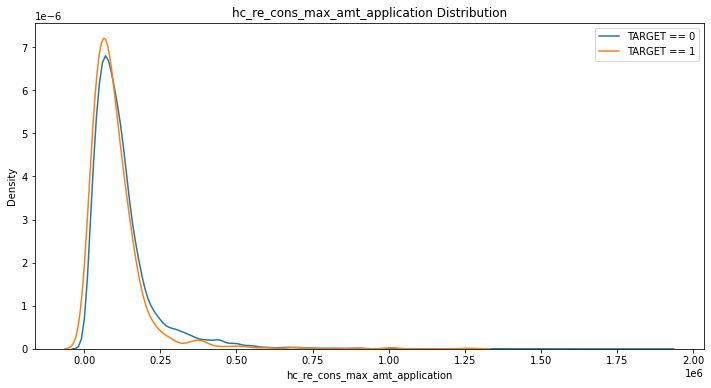

In [128]:
kde_target('hc_re_cons_max_amt_application', app_train)

In [129]:
app_train['hc_re_cons_max_amt_application'].isnull().sum()

286904

In [130]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_max_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_max_amt_application  
0  52.715068                   232623.628671  
1  49.490411                   145484.060272  
2  54.898630                   264420.593497  
3  38.290411                   497616.502586  
4  35.726027                   252687.395888  

[5 rows x 92 columns]

In [131]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [132]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [133]:
app_train['hc_re_cons_max_amt_application'].isnull().sum()

0

In [134]:
app_train[['TARGET', 'hc_re_cons_max_amt_application']].corr()

TARGET  hc_re_cons_max_amt_application
TARGET                          1.000000                       -0.033999
hc_re_cons_max_amt_application -0.033999                        1.000000

In [135]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_max_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_max_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_max_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_max_amt_application']].corr()

TARGET  hc_re_cons_max_amt_application
TARGET                          1.000000                       -0.040929
hc_re_cons_max_amt_application -0.040929                        1.000000

In [136]:
## 標準化
num_cols = ['hc_re_cons_max_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_max_amt_application', 'TARGET']].corr()

hc_re_cons_max_amt_application    TARGET
hc_re_cons_max_amt_application                        1.000000 -0.040929
TARGET                                               -0.040929  1.000000

The correlation between hc_re_cons_max_amt_application and the TARGET is -0.0409
Median value for loan that was not repaid = -0.2023
Median value for loan that was repaid =     -0.0487


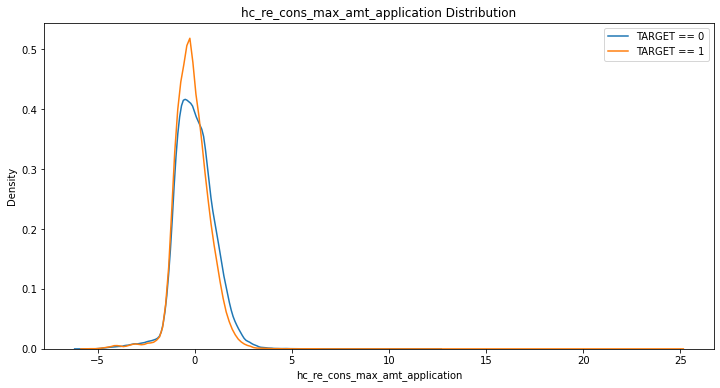

In [137]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_max_amt_application', app_train)

### hc_re_cons_min_amt_application

In [138]:
app_train[['TARGET', 'hc_re_cons_min_amt_application']].corr()

TARGET  hc_re_cons_min_amt_application
TARGET                          1.000000                       -0.041517
hc_re_cons_min_amt_application -0.041517                        1.000000

The correlation between hc_re_cons_min_amt_application and the TARGET is -0.0415
Median value for loan that was not repaid = 64325.2500
Median value for loan that was repaid =     76410.0000


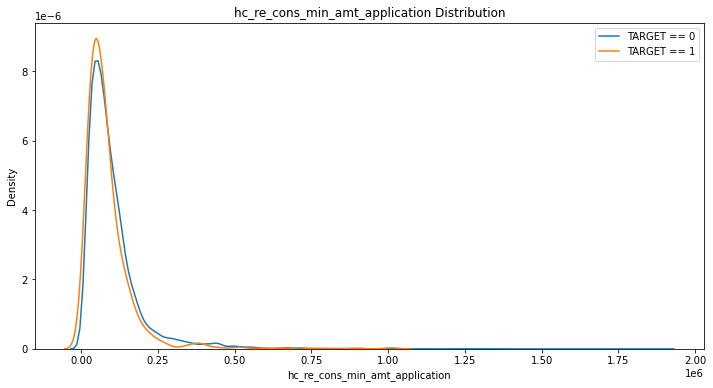

In [139]:
kde_target('hc_re_cons_min_amt_application', app_train)

In [140]:
app_train['hc_re_cons_min_amt_application'].isnull().sum()

286904

In [141]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_min_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_min_amt_application  
0  52.715068                   194713.348972  
1  49.490411                   105439.485154  
2  54.898630                   231861.494080  
3  38.290411                   477164.986573  
4  35.726027                   219892.876918  

[5 rows x 92 columns]

In [142]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [143]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [144]:
app_train['hc_re_cons_min_amt_application'].isnull().sum()

0

In [145]:
app_train[['TARGET', 'hc_re_cons_min_amt_application']].corr()

TARGET  hc_re_cons_min_amt_application
TARGET                          1.000000                       -0.035016
hc_re_cons_min_amt_application -0.035016                        1.000000

In [146]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_min_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_min_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_min_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_min_amt_application']].corr()

TARGET  hc_re_cons_min_amt_application
TARGET                          1.000000                       -0.041314
hc_re_cons_min_amt_application -0.041314                        1.000000

In [147]:
## 標準化
num_cols = ['hc_re_cons_min_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_min_amt_application', 'TARGET']].corr()

hc_re_cons_min_amt_application    TARGET
hc_re_cons_min_amt_application                        1.000000 -0.041314
TARGET                                               -0.041314  1.000000

The correlation between hc_re_cons_min_amt_application and the TARGET is -0.0413
Median value for loan that was not repaid = -0.2081
Median value for loan that was repaid =     -0.0404


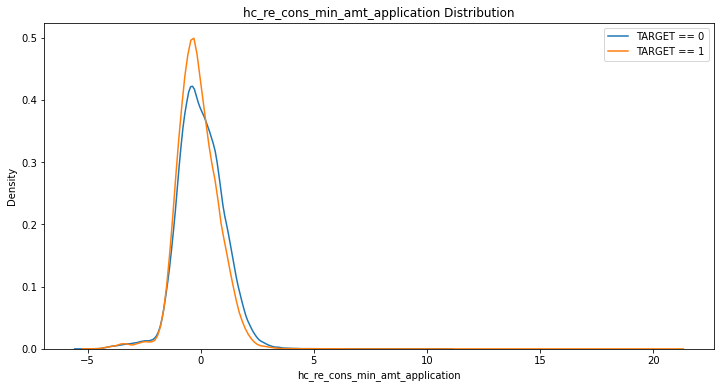

In [148]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_min_amt_application', app_train)

### hc_re_cons_sum_amt_application

In [149]:
app_train[['TARGET', 'hc_re_cons_sum_amt_application']].corr()

TARGET  hc_re_cons_sum_amt_application
TARGET                          1.000000                       -0.026303
hc_re_cons_sum_amt_application -0.026303                        1.000000

The correlation between hc_re_cons_sum_amt_application and the TARGET is -0.0263
Median value for loan that was not repaid = 4641078.6000
Median value for loan that was repaid =     6930198.0000


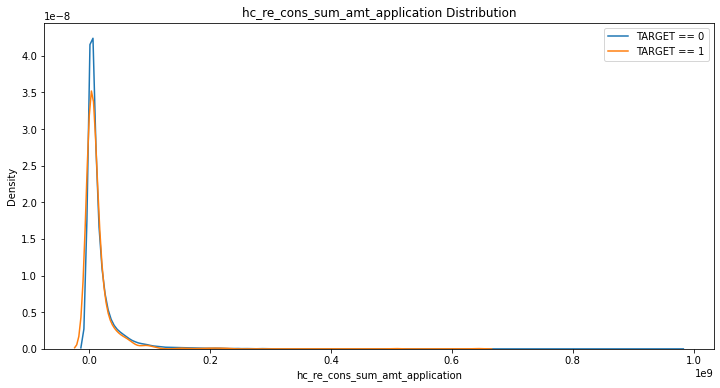

In [150]:
kde_target('hc_re_cons_sum_amt_application', app_train)

In [151]:
app_train['hc_re_cons_sum_amt_application'].isnull().sum()

286904

In [152]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_sum_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_sum_amt_application  
0  52.715068                    2.641583e+07  
1  49.490411                    2.440346e+07  
2  54.898630                    2.719760e+07  
3  38.290411                    3.302818e+07  
4  35.726027                    2.704266e+07  

[5 rows x 92 columns]

In [153]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [154]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [155]:
app_train['hc_re_cons_sum_amt_application'].isnull().sum()

0

In [156]:
app_train[['TARGET', 'hc_re_cons_sum_amt_application']].corr()

TARGET  hc_re_cons_sum_amt_application
TARGET                          1.000000                       -0.030392
hc_re_cons_sum_amt_application -0.030392                        1.000000

In [157]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_sum_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_sum_amt_application'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_sum_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_sum_amt_application']].corr()

In [158]:
## 標準化
num_cols = ['hc_re_cons_sum_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_sum_amt_application', 'TARGET']].corr()

hc_re_cons_sum_amt_application    TARGET
hc_re_cons_sum_amt_application                        1.000000 -0.030392
TARGET                                               -0.030392  1.000000

The correlation between hc_re_cons_sum_amt_application and the TARGET is -0.0304
Median value for loan that was not repaid = -0.2101
Median value for loan that was repaid =     -0.1476


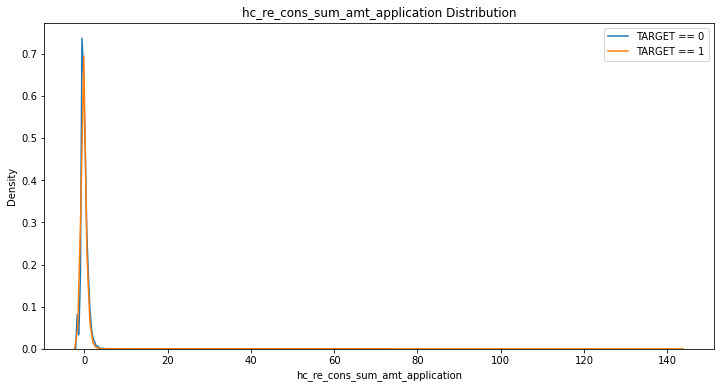

In [159]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_sum_amt_application', app_train)

### hc_re_cons_avg_amt_application

In [160]:
app_train[['TARGET', 'hc_re_cons_avg_amt_application']].corr()

TARGET  hc_re_cons_avg_amt_application
TARGET                          1.000000                       -0.044081
hc_re_cons_avg_amt_application -0.044081                        1.000000

The correlation between hc_re_cons_avg_amt_application and the TARGET is -0.0441
Median value for loan that was not repaid = 76385.2500
Median value for loan that was repaid =     90049.5000


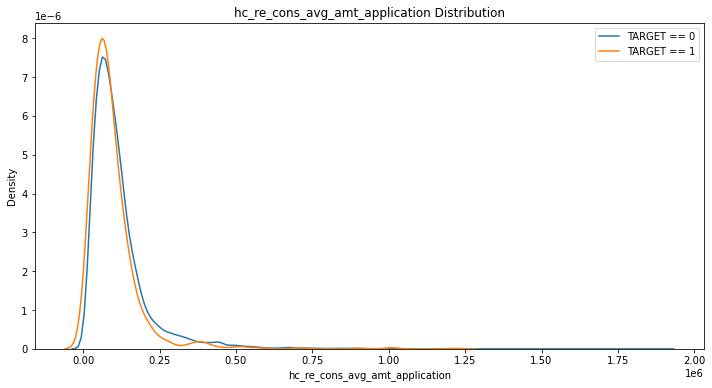

In [161]:
kde_target('hc_re_cons_avg_amt_application', app_train)

In [162]:
app_train['hc_re_cons_avg_amt_application'].isnull().sum()

286904

In [163]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_avg_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_avg_amt_application  
0  52.715068                   223009.400724  
1  49.490411                   134487.919879  
2  54.898630                   256674.777486  
3  38.290411                   495089.566245  
4  35.726027                   244685.442571  

[5 rows x 92 columns]

In [164]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [165]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [166]:
app_train['hc_re_cons_avg_amt_application'].isnull().sum()

0

In [167]:
app_train[['TARGET', 'hc_re_cons_avg_amt_application']].corr()

TARGET  hc_re_cons_avg_amt_application
TARGET                          1.000000                       -0.035261
hc_re_cons_avg_amt_application -0.035261                        1.000000

In [168]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_avg_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_avg_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_avg_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_avg_amt_application']].corr()

TARGET  hc_re_cons_avg_amt_application
TARGET                          1.000000                       -0.042749
hc_re_cons_avg_amt_application -0.042749                        1.000000

In [169]:
## 標準化
num_cols = ['hc_re_cons_avg_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_avg_amt_application', 'TARGET']].corr()

hc_re_cons_avg_amt_application    TARGET
hc_re_cons_avg_amt_application                        1.000000 -0.042749
TARGET                                               -0.042749  1.000000

The correlation between hc_re_cons_avg_amt_application and the TARGET is -0.0427
Median value for loan that was not repaid = -0.2105
Median value for loan that was repaid =     -0.0452


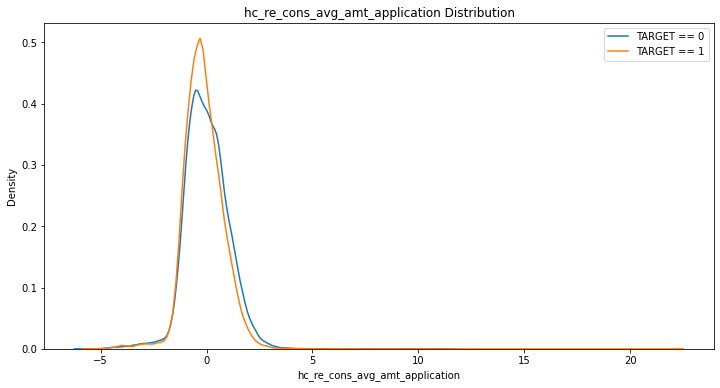

In [170]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_avg_amt_application', app_train)

### hc_re_cons_cnt_amt_application

In [171]:
app_train[['TARGET', 'hc_re_cons_cnt_amt_application']].corr()

TARGET  hc_re_cons_cnt_amt_application
TARGET                          1.000000                       -0.023163
hc_re_cons_cnt_amt_application -0.023163                        1.000000

The correlation between hc_re_cons_cnt_amt_application and the TARGET is -0.0232
Median value for loan that was not repaid = 64.0000
Median value for loan that was repaid =     81.0000


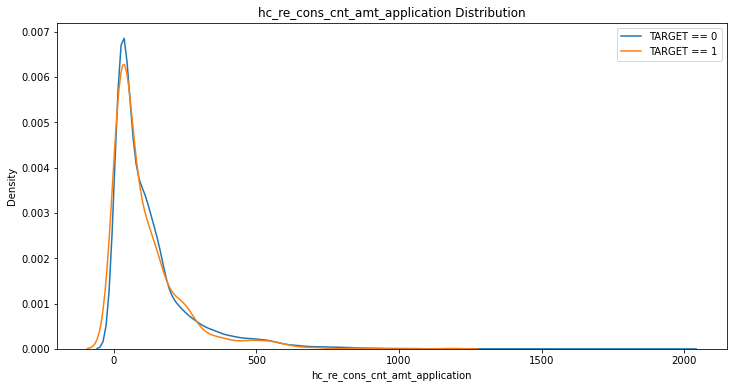

In [172]:
kde_target('hc_re_cons_cnt_amt_application', app_train)

In [173]:
app_train['hc_re_cons_cnt_amt_application'].isnull().sum()

286904

In [174]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_cnt_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_cnt_amt_application  
0  52.715068                      163.998265  
1  49.490411                      157.286037  
2  54.898630                      129.204913  
3  38.290411                       72.600350  
4  35.726027                      121.305041  

[5 rows x 92 columns]

In [175]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [176]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [177]:
app_train['hc_re_cons_cnt_amt_application'].isnull().sum()

0

In [178]:
app_train[['TARGET', 'hc_re_cons_cnt_amt_application']].corr()

TARGET  hc_re_cons_cnt_amt_application
TARGET                          1.00000                        -0.01208
hc_re_cons_cnt_amt_application -0.01208                         1.00000

In [179]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_cnt_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_cnt_amt_application'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_cnt_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_cnt_amt_application']].corr()

TARGET  hc_re_cons_cnt_amt_application
TARGET                          1.000000                       -0.012089
hc_re_cons_cnt_amt_application -0.012089                        1.000000

In [180]:
## 標準化
num_cols = ['hc_re_cons_cnt_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_cnt_amt_application', 'TARGET']].corr()

hc_re_cons_cnt_amt_application    TARGET
hc_re_cons_cnt_amt_application                        1.000000 -0.012089
TARGET                                               -0.012089  1.000000

The correlation between hc_re_cons_cnt_amt_application and the TARGET is -0.0121
Median value for loan that was not repaid = -0.1295
Median value for loan that was repaid =     -0.0940


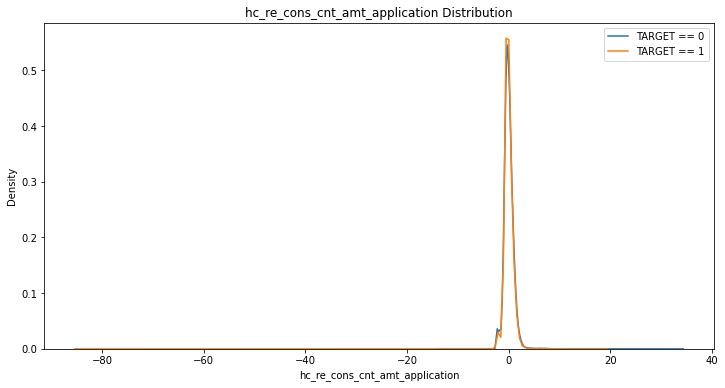

In [181]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_cnt_amt_application', app_train)

### hc_re_cons_stddev_amt_application

In [182]:
app_train[['TARGET', 'hc_re_cons_stddev_amt_application']].corr()

TARGET  hc_re_cons_stddev_amt_application
TARGET                             1.000000                          -0.017648
hc_re_cons_stddev_amt_application -0.017648                           1.000000

The correlation between hc_re_cons_stddev_amt_application and the TARGET is -0.0176
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


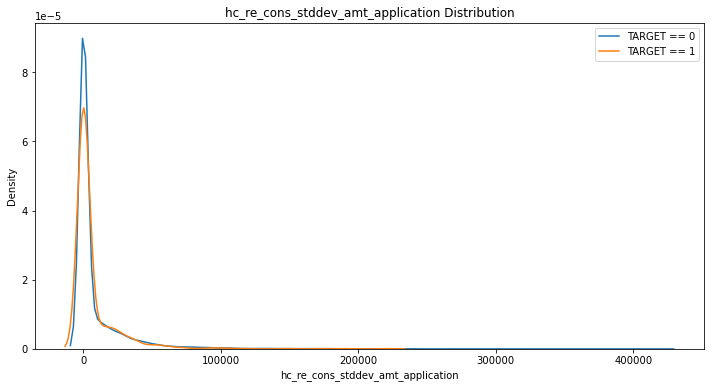

In [183]:
kde_target('hc_re_cons_stddev_amt_application', app_train)

In [184]:
app_train['hc_re_cons_stddev_amt_application'].isnull().sum()

286904

In [185]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_amt_application  
0  52.715068                       12251.784935  
1  49.490411                       12277.173193  
2  54.898630                       12187.820556  
3  38.290411                       12017.067216  
4  35.726027                       12182.644783  

[5 rows x 92 columns]

In [186]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [187]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [188]:
app_train['hc_re_cons_stddev_amt_application'].isnull().sum()

0

In [189]:
app_train[['TARGET', 'hc_re_cons_stddev_amt_application']].corr()

TARGET  hc_re_cons_stddev_amt_application
TARGET                             1.000000                          -0.030919
hc_re_cons_stddev_amt_application -0.030919                           1.000000

In [190]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_stddev_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_stddev_amt_application'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_stddev_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_stddev_amt_application']].corr()

In [191]:
## 標準化
num_cols = ['hc_re_cons_stddev_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_amt_application', 'TARGET']].corr()

hc_re_cons_stddev_amt_application    TARGET
hc_re_cons_stddev_amt_application                           1.000000 -0.030919
TARGET                                                     -0.030919  1.000000

The correlation between hc_re_cons_stddev_amt_application and the TARGET is -0.0309
Median value for loan that was not repaid = -0.2644
Median value for loan that was repaid =     -0.1731


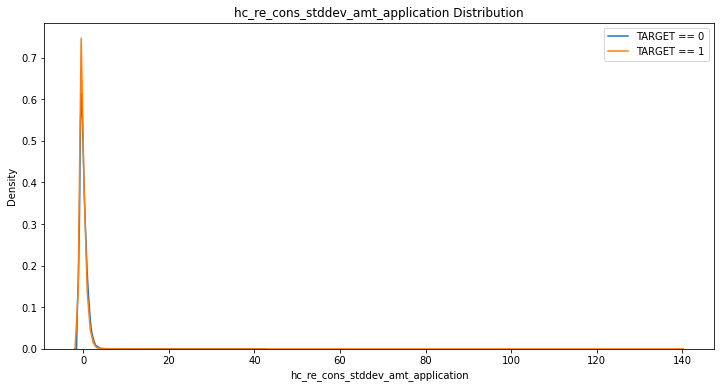

In [192]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_amt_application', app_train)

### hc_re_cons_stddev_pop_amt_application

In [193]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_application']].corr()

TARGET  \
TARGET                                 1.000000   
hc_re_cons_stddev_pop_amt_application -0.017648   

                                       hc_re_cons_stddev_pop_amt_application  
TARGET                                                             -0.017648  
hc_re_cons_stddev_pop_amt_application                               1.000000

The correlation between hc_re_cons_stddev_pop_amt_application and the TARGET is -0.0176
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


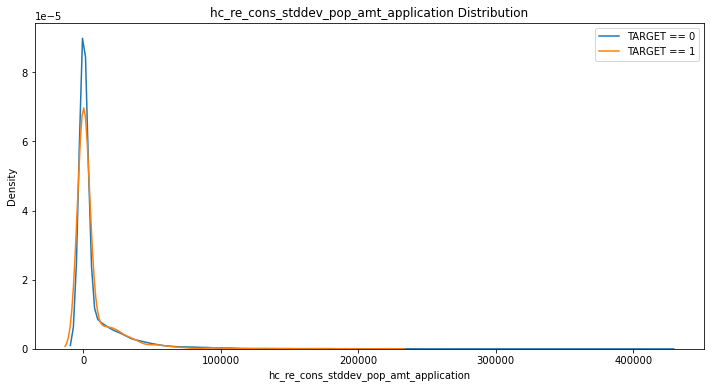

In [194]:
kde_target('hc_re_cons_stddev_pop_amt_application', app_train)

In [195]:
app_train['hc_re_cons_stddev_pop_amt_application'].isnull().sum()

286904

In [196]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_pop_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_pop_amt_application  
0  52.715068                           12251.784935  
1  49.490411                           12277.173193  
2  54.898630                           12187.820556  
3  38.290411                           12017.067216  
4  35.726027                           12182.644783  

[5 rows x 92 columns]

In [197]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [198]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [199]:
app_train['hc_re_cons_stddev_pop_amt_application'].isnull().sum()

0

In [200]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_application']].corr()

TARGET  \
TARGET                                 1.000000   
hc_re_cons_stddev_pop_amt_application -0.030919   

                                       hc_re_cons_stddev_pop_amt_application  
TARGET                                                             -0.030919  
hc_re_cons_stddev_pop_amt_application                               1.000000

In [201]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_stddev_pop_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_stddev_pop_amt_application'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_stddev_pop_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_application']].corr()

In [202]:
## 標準化
num_cols = ['hc_re_cons_stddev_pop_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_pop_amt_application', 'TARGET']].corr()

hc_re_cons_stddev_pop_amt_application  \
hc_re_cons_stddev_pop_amt_application                               1.000000   
TARGET                                                             -0.030919   

                                         TARGET  
hc_re_cons_stddev_pop_amt_application -0.030919  
TARGET                                 1.000000

The correlation between hc_re_cons_stddev_pop_amt_application and the TARGET is -0.0309
Median value for loan that was not repaid = -0.2644
Median value for loan that was repaid =     -0.1731


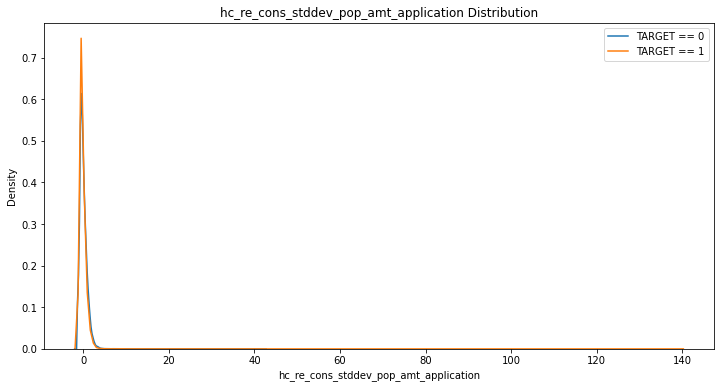

In [203]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_pop_amt_application', app_train)

### hc_re_cons_var_pop_amt_application

In [204]:
app_train[['TARGET', 'hc_re_cons_var_pop_amt_application']].corr()

TARGET  hc_re_cons_var_pop_amt_application
TARGET                              1.0000                             -0.0128
hc_re_cons_var_pop_amt_application -0.0128                              1.0000

The correlation between hc_re_cons_var_pop_amt_application and the TARGET is -0.0128
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


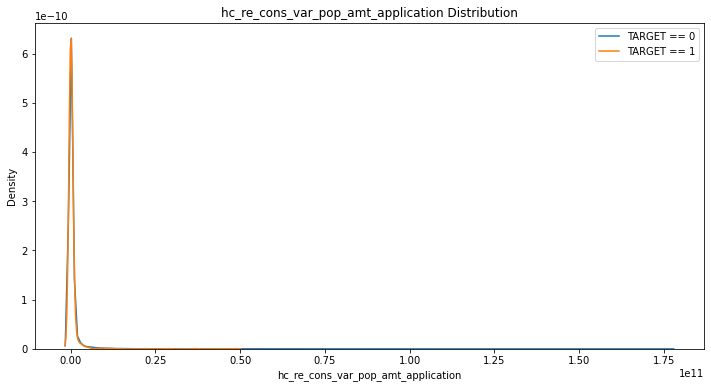

In [205]:
kde_target('hc_re_cons_var_pop_amt_application', app_train)

In [206]:
app_train['hc_re_cons_var_pop_amt_application'].isnull().sum()

286904

In [207]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_pop_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_pop_amt_application  
0  52.715068                        8.887235e+08  
1  49.490411                        8.887235e+08  
2  54.898630                        8.887235e+08  
3  38.290411                        8.887235e+08  
4  35.726027                        8.887235e+08  

[5 rows x 92 columns]

In [208]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [209]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [210]:
app_train['hc_re_cons_var_pop_amt_application'].isnull().sum()

0

In [211]:
app_train[['TARGET', 'hc_re_cons_var_pop_amt_application']].corr()

TARGET  \
TARGET                              1.000000   
hc_re_cons_var_pop_amt_application -0.019353   

                                    hc_re_cons_var_pop_amt_application  
TARGET                                                       -0.019353  
hc_re_cons_var_pop_amt_application                            1.000000

In [212]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_var_pop_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_var_pop_amt_application'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_var_pop_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_var_pop_amt_application']].corr()

In [213]:
## 標準化
num_cols = ['hc_re_cons_var_pop_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_pop_amt_application', 'TARGET']].corr()

hc_re_cons_var_pop_amt_application  \
hc_re_cons_var_pop_amt_application                            1.000000   
TARGET                                                       -0.019353   

                                      TARGET  
hc_re_cons_var_pop_amt_application -0.019353  
TARGET                              1.000000

The correlation between hc_re_cons_var_pop_amt_application and the TARGET is -0.0194
Median value for loan that was not repaid = -0.1487
Median value for loan that was repaid =     -0.1046


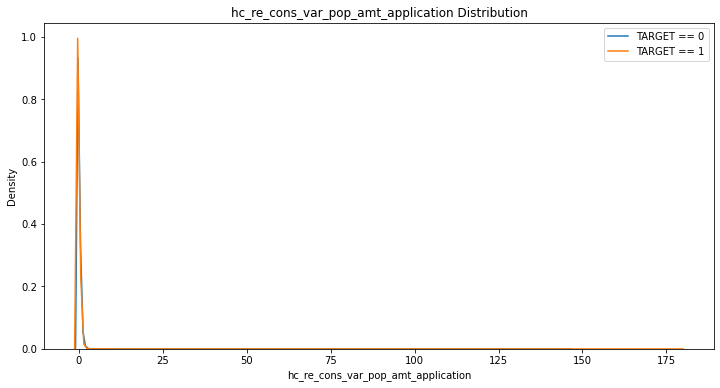

In [214]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_pop_amt_application', app_train)

### hc_re_cons_var_samp_amt_application

In [215]:
app_train[['TARGET', 'hc_re_cons_var_samp_amt_application']].corr()

TARGET  \
TARGET                               1.00000   
hc_re_cons_var_samp_amt_application -0.01287   

                                     hc_re_cons_var_samp_amt_application  
TARGET                                                          -0.01287  
hc_re_cons_var_samp_amt_application                              1.00000

The correlation between hc_re_cons_var_samp_amt_application and the TARGET is -0.0129
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


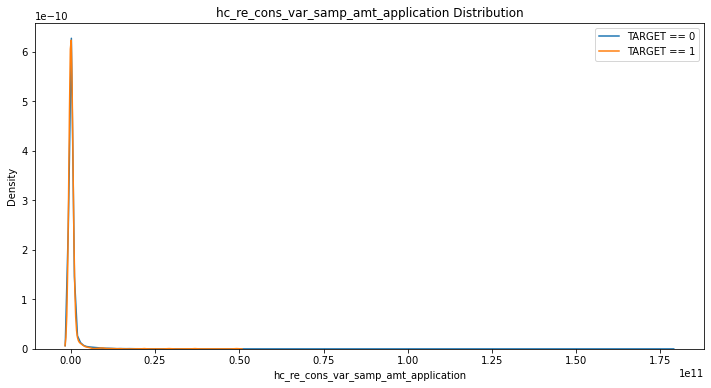

In [216]:
kde_target('hc_re_cons_var_samp_amt_application', app_train)

In [217]:
app_train['hc_re_cons_var_samp_amt_application'].isnull().sum()

286904

In [218]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_samp_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_samp_amt_application  
0  52.715068                         8.935716e+08  
1  49.490411                         8.935716e+08  
2  54.898630                         8.935715e+08  
3  38.290411                         8.935715e+08  
4  35.726027                         8.935715e+08  

[5 rows x 92 columns]

In [219]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [220]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [221]:
app_train['hc_re_cons_var_samp_amt_application'].isnull().sum()

0

In [222]:
app_train[['TARGET', 'hc_re_cons_var_samp_amt_application']].corr()

TARGET  \
TARGET                               1.000000   
hc_re_cons_var_samp_amt_application -0.019427   

                                     hc_re_cons_var_samp_amt_application  
TARGET                                                         -0.019427  
hc_re_cons_var_samp_amt_application                             1.000000

In [223]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_var_samp_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_var_samp_amt_application'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_var_samp_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_var_samp_amt_application']].corr()

In [224]:
## 標準化
num_cols = ['hc_re_cons_var_samp_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_samp_amt_application', 'TARGET']].corr()

hc_re_cons_var_samp_amt_application  \
hc_re_cons_var_samp_amt_application                             1.000000   
TARGET                                                         -0.019427   

                                       TARGET  
hc_re_cons_var_samp_amt_application -0.019427  
TARGET                               1.000000

The correlation between hc_re_cons_var_samp_amt_application and the TARGET is -0.0194
Median value for loan that was not repaid = -0.1487
Median value for loan that was repaid =     -0.1043


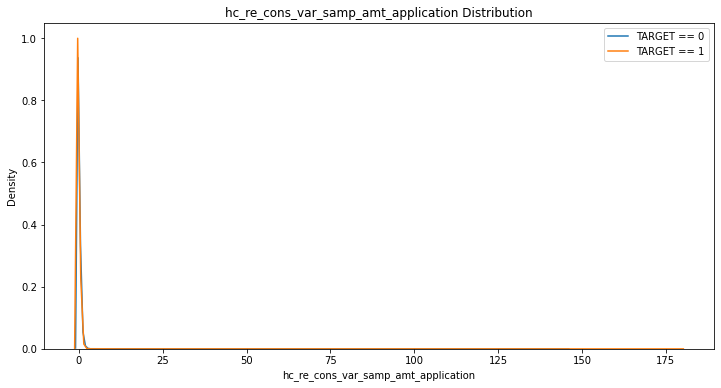

In [225]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_samp_amt_application', app_train)

In [226]:
### hc_re_cons_variance_samp_amt_application

In [227]:
app_train[['TARGET', 'hc_re_cons_variance_samp_amt_application']].corr()

TARGET  \
TARGET                                    1.0000   
hc_re_cons_variance_samp_amt_application -0.0128   

                                          hc_re_cons_variance_samp_amt_application  
TARGET                                                                     -0.0128  
hc_re_cons_variance_samp_amt_application                                    1.0000

The correlation between hc_re_cons_variance_samp_amt_application and the TARGET is -0.0128
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


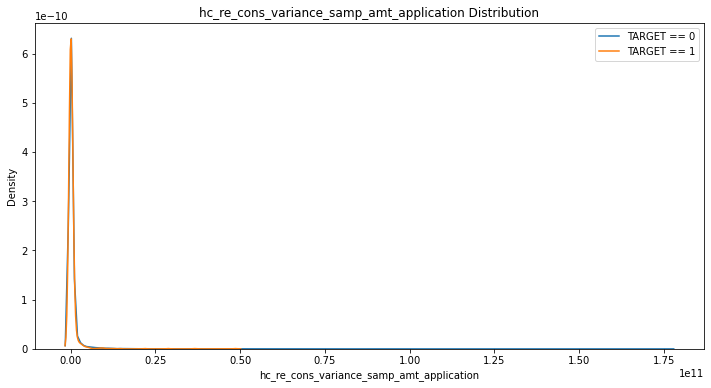

In [228]:
kde_target('hc_re_cons_variance_samp_amt_application', app_train)

In [229]:
app_train['hc_re_cons_variance_samp_amt_application'].isnull().sum()

286904

In [230]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_variance_samp_amt_application')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_variance_samp_amt_application  
0  52.715068                              8.887235e+08  
1  49.490411                              8.887235e+08  
2  54.898630                              8.887235e+08  
3  38.290411                              8.887235e+08  
4  35.726027                              8.887235e+08  

[5 rows x 92 columns]

In [231]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [232]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [233]:
app_train['hc_re_cons_variance_samp_amt_application'].isnull().sum()

0

In [234]:
app_train[['TARGET', 'hc_re_cons_variance_samp_amt_application']].corr()

TARGET  \
TARGET                                    1.000000   
hc_re_cons_variance_samp_amt_application -0.019353   

                                          hc_re_cons_variance_samp_amt_application  
TARGET                                                                   -0.019353  
hc_re_cons_variance_samp_amt_application                                  1.000000

In [235]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_variance_samp_amt_application']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_variance_samp_amt_application'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_variance_samp_amt_application'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_variance_samp_amt_application']].corr()

In [236]:
## 標準化
num_cols = ['hc_re_cons_variance_samp_amt_application']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_variance_samp_amt_application', 'TARGET']].corr()

hc_re_cons_variance_samp_amt_application  \
hc_re_cons_variance_samp_amt_application                                  1.000000   
TARGET                                                                   -0.019353   

                                            TARGET  
hc_re_cons_variance_samp_amt_application -0.019353  
TARGET                                    1.000000

The correlation between hc_re_cons_variance_samp_amt_application and the TARGET is -0.0194
Median value for loan that was not repaid = -0.1487
Median value for loan that was repaid =     -0.1046


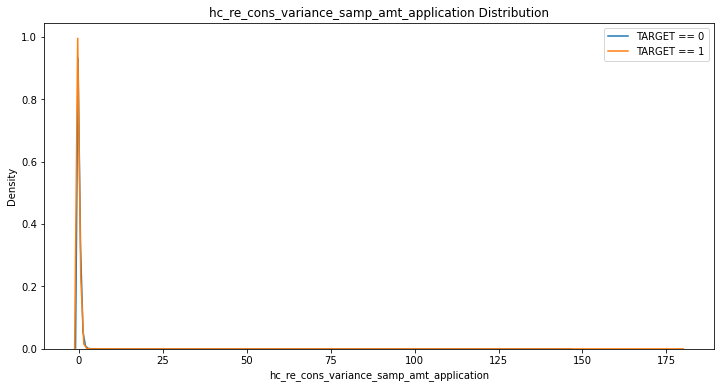

In [237]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_variance_samp_amt_application', app_train)

### hc_re_cons_max_amt_credit

In [238]:
app_train[['TARGET', 'hc_re_cons_max_amt_credit']].corr()

TARGET  hc_re_cons_max_amt_credit
TARGET                     1.000000                  -0.044066
hc_re_cons_max_amt_credit -0.044066                   1.000000

The correlation between hc_re_cons_max_amt_credit and the TARGET is -0.0441
Median value for loan that was not repaid = 83099.2500
Median value for loan that was repaid =     99063.0000


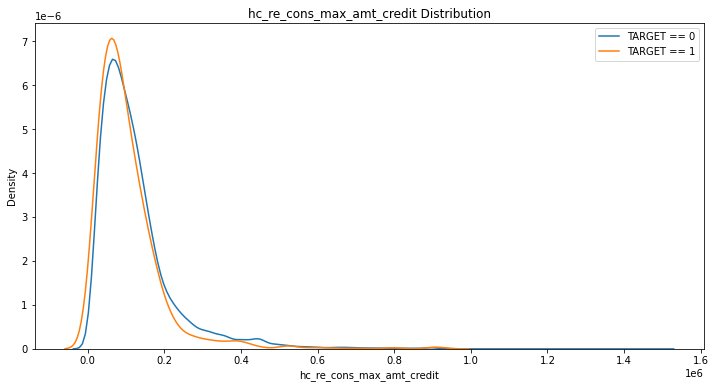

In [239]:
kde_target('hc_re_cons_max_amt_credit', app_train)

In [240]:
app_train['hc_re_cons_max_amt_credit'].isnull().sum()

286904

In [241]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_max_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_max_amt_credit  
0  52.715068              224707.861646  
1  49.490411              144462.870046  
2  54.898630              252497.924483  
3  38.290411              464270.304107  
4  35.726027              241461.149026  

[5 rows x 92 columns]

In [242]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [243]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [244]:
app_train['hc_re_cons_max_amt_credit'].isnull().sum()

0

In [245]:
app_train[['TARGET', 'hc_re_cons_max_amt_credit']].corr()

TARGET  hc_re_cons_max_amt_credit
TARGET                     1.000000                  -0.033171
hc_re_cons_max_amt_credit -0.033171                   1.000000

In [246]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_max_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_max_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_max_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_max_amt_credit']].corr()

TARGET  hc_re_cons_max_amt_credit
TARGET                     1.000000                  -0.039238
hc_re_cons_max_amt_credit -0.039238                   1.000000

In [247]:
## 標準化
num_cols = ['hc_re_cons_max_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_max_amt_credit', 'TARGET']].corr()

hc_re_cons_max_amt_credit    TARGET
hc_re_cons_max_amt_credit                   1.000000 -0.039238
TARGET                                     -0.039238  1.000000

The correlation between hc_re_cons_max_amt_credit and the TARGET is -0.0392
Median value for loan that was not repaid = -0.1991
Median value for loan that was repaid =     -0.0537


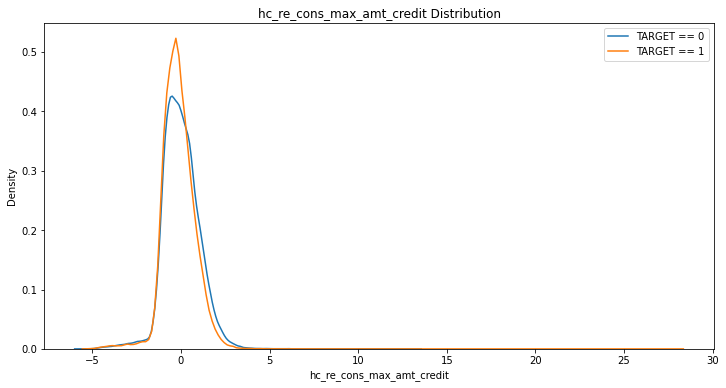

In [248]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_max_amt_credit', app_train)

### hc_re_cons_min_amt_credit

In [249]:
app_train[['TARGET', 'hc_re_cons_min_amt_credit']].corr()

TARGET  hc_re_cons_min_amt_credit
TARGET                     1.000000                  -0.038223
hc_re_cons_min_amt_credit -0.038223                   1.000000

The correlation between hc_re_cons_min_amt_credit and the TARGET is -0.0382
Median value for loan that was not repaid = 64192.5000
Median value for loan that was repaid =     75433.5000


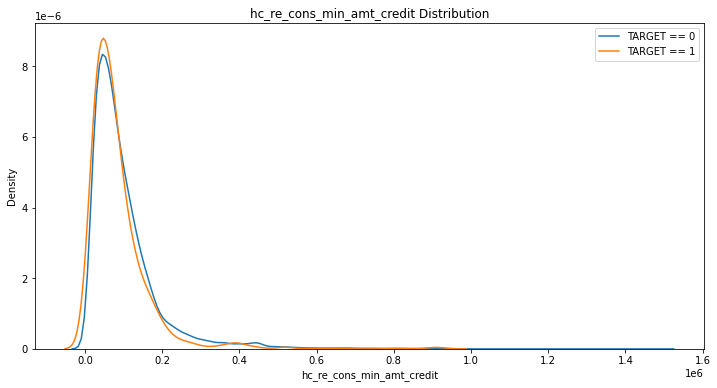

In [250]:
kde_target('hc_re_cons_min_amt_credit', app_train)

In [251]:
app_train['hc_re_cons_min_amt_credit'].isnull().sum()

286904

In [252]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_min_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_min_amt_credit  
0  52.715068              188313.913335  
1  49.490411              107661.139493  
2  54.898630              221473.197328  
3  38.290411              444128.371904  
4  35.726027              211147.212535  

[5 rows x 92 columns]

In [253]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [254]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [255]:
app_train['hc_re_cons_min_amt_credit'].isnull().sum()

0

In [256]:
app_train[['TARGET', 'hc_re_cons_min_amt_credit']].corr()

TARGET  hc_re_cons_min_amt_credit
TARGET                     1.000000                  -0.034413
hc_re_cons_min_amt_credit -0.034413                   1.000000

In [257]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_min_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_min_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_min_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_min_amt_credit']].corr()

TARGET  hc_re_cons_min_amt_credit
TARGET                     1.000000                  -0.040383
hc_re_cons_min_amt_credit -0.040383                   1.000000

In [258]:
## 標準化
num_cols = ['hc_re_cons_min_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_min_amt_credit', 'TARGET']].corr()

hc_re_cons_min_amt_credit    TARGET
hc_re_cons_min_amt_credit                   1.000000 -0.040383
TARGET                                     -0.040383  1.000000

The correlation between hc_re_cons_min_amt_credit and the TARGET is -0.0404
Median value for loan that was not repaid = -0.2051
Median value for loan that was repaid =     -0.0449


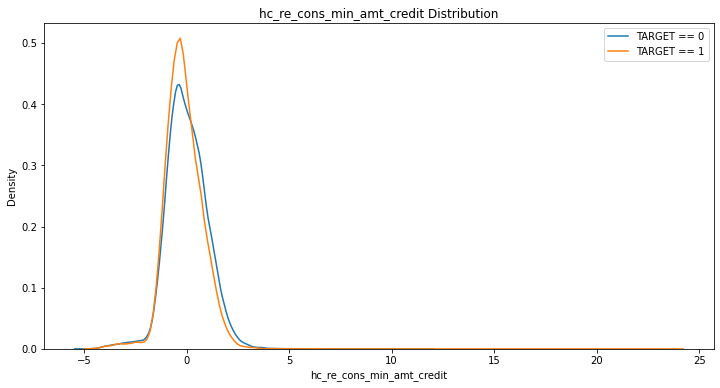

In [259]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_min_amt_credit', app_train)

### hc_re_cons_sum_amt_credit

In [260]:
app_train[['TARGET', 'hc_re_cons_sum_amt_credit']].corr()

TARGET  hc_re_cons_sum_amt_credit
TARGET                     1.000000                  -0.025678
hc_re_cons_sum_amt_credit -0.025678                   1.000000

The correlation between hc_re_cons_sum_amt_credit and the TARGET is -0.0257
Median value for loan that was not repaid = 4727286.0000
Median value for loan that was repaid =     6954012.0000


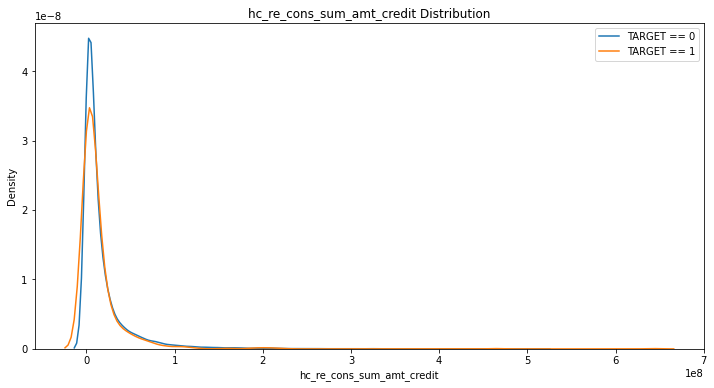

In [261]:
kde_target('hc_re_cons_sum_amt_credit', app_train)

In [262]:
app_train['hc_re_cons_sum_amt_credit'].isnull().sum()

286904

In [263]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_sum_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_sum_amt_credit  
0  52.715068               2.550715e+07  
1  49.490411               2.458858e+07  
2  54.898630               2.586704e+07  
3  38.290411               2.852540e+07  
4  35.726027               2.579433e+07  

[5 rows x 92 columns]

In [264]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [265]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [266]:
app_train['hc_re_cons_sum_amt_credit'].isnull().sum()

0

In [267]:
app_train[['TARGET', 'hc_re_cons_sum_amt_credit']].corr()

TARGET  hc_re_cons_sum_amt_credit
TARGET                     1.000000                  -0.030041
hc_re_cons_sum_amt_credit -0.030041                   1.000000

In [268]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_sum_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_sum_amt_credit'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_sum_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_sum_amt_credit']].corr()

In [269]:
## 標準化
num_cols = ['hc_re_cons_sum_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_sum_amt_credit', 'TARGET']].corr()

hc_re_cons_sum_amt_credit    TARGET
hc_re_cons_sum_amt_credit                   1.000000 -0.030041
TARGET                                     -0.030041  1.000000

The correlation between hc_re_cons_sum_amt_credit and the TARGET is -0.0300
Median value for loan that was not repaid = -0.2062
Median value for loan that was repaid =     -0.1465


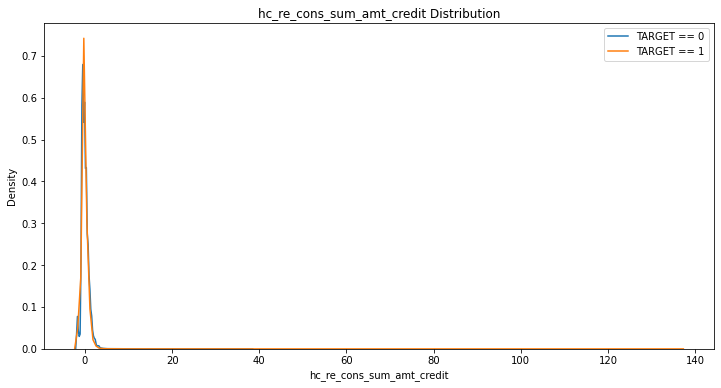

In [270]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_sum_amt_credit', app_train)

### hc_re_cons_avg_amt_credit

In [271]:
app_train[['TARGET', 'hc_re_cons_avg_amt_credit']].corr()

TARGET  hc_re_cons_avg_amt_credit
TARGET                     1.000000                  -0.042146
hc_re_cons_avg_amt_credit -0.042146                   1.000000

The correlation between hc_re_cons_avg_amt_credit and the TARGET is -0.0421
Median value for loan that was not repaid = 76074.7500
Median value for loan that was repaid =     90837.0000


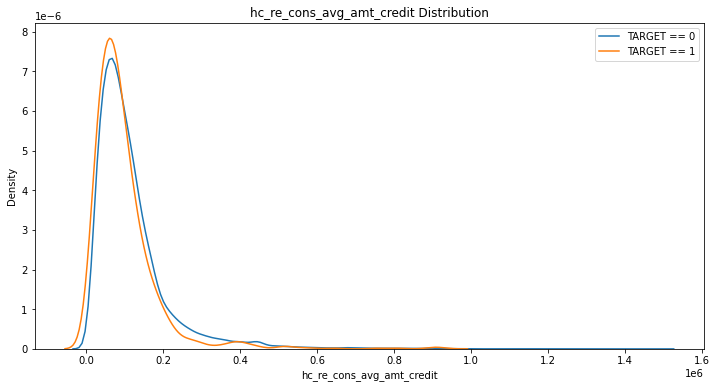

In [272]:
kde_target('hc_re_cons_avg_amt_credit', app_train)

In [273]:
app_train['hc_re_cons_avg_amt_credit'].isnull().sum()

286904

In [274]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_avg_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_avg_amt_credit  
0  52.715068              214396.102970  
1  49.490411              132994.004087  
2  54.898630              244164.759914  
3  38.290411              461373.627874  
4  35.726027              233065.441940  

[5 rows x 92 columns]

In [275]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [276]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [277]:
app_train['hc_re_cons_avg_amt_credit'].isnull().sum()

0

In [278]:
app_train[['TARGET', 'hc_re_cons_avg_amt_credit']].corr()

TARGET  hc_re_cons_avg_amt_credit
TARGET                     1.000000                  -0.034591
hc_re_cons_avg_amt_credit -0.034591                   1.000000

In [279]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_avg_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_avg_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_avg_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_avg_amt_credit']].corr()

TARGET  hc_re_cons_avg_amt_credit
TARGET                     1.000000                  -0.041298
hc_re_cons_avg_amt_credit -0.041298                   1.000000

In [280]:
## 標準化
num_cols = ['hc_re_cons_avg_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_avg_amt_credit', 'TARGET']].corr()

hc_re_cons_avg_amt_credit    TARGET
hc_re_cons_avg_amt_credit                   1.000000 -0.041298
TARGET                                     -0.041298  1.000000

The correlation between hc_re_cons_avg_amt_credit and the TARGET is -0.0413
Median value for loan that was not repaid = -0.2078
Median value for loan that was repaid =     -0.0494


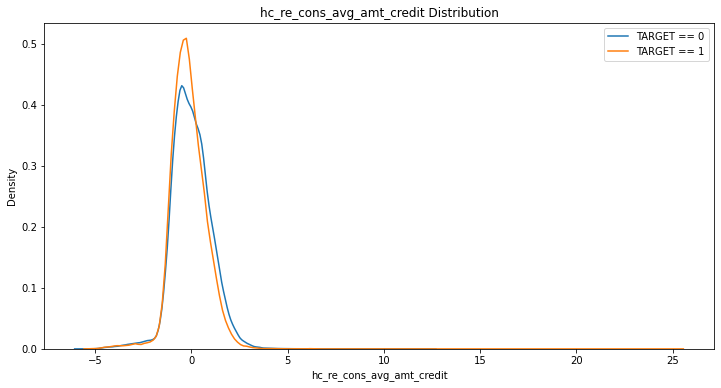

In [281]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_avg_amt_credit', app_train)

### hc_re_cons_cnt_amt_credit

In [282]:
app_train[['TARGET', 'hc_re_cons_cnt_amt_credit']].corr()

TARGET  hc_re_cons_cnt_amt_credit
TARGET                     1.000000                  -0.023163
hc_re_cons_cnt_amt_credit -0.023163                   1.000000

The correlation between hc_re_cons_cnt_amt_credit and the TARGET is -0.0232
Median value for loan that was not repaid = 64.0000
Median value for loan that was repaid =     81.0000


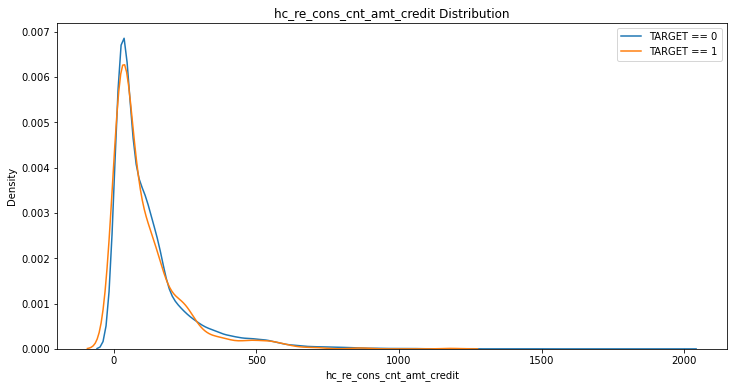

In [283]:
kde_target('hc_re_cons_cnt_amt_credit', app_train)

In [284]:
app_train['hc_re_cons_cnt_amt_credit'].isnull().sum()

286904

In [285]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_cnt_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_cnt_amt_credit  
0  52.715068                 163.998265  
1  49.490411                 157.286037  
2  54.898630                 129.204913  
3  38.290411                  72.600350  
4  35.726027                 121.305041  

[5 rows x 92 columns]

In [286]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [287]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [288]:
app_train['hc_re_cons_cnt_amt_credit'].isnull().sum()

0

In [289]:
app_train[['TARGET', 'hc_re_cons_cnt_amt_credit']].corr()

TARGET  hc_re_cons_cnt_amt_credit
TARGET                     1.00000                   -0.01208
hc_re_cons_cnt_amt_credit -0.01208                    1.00000

In [290]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_cnt_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_cnt_amt_credit'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_cnt_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_cnt_amt_credit']].corr()

TARGET  hc_re_cons_cnt_amt_credit
TARGET                     1.000000                  -0.012089
hc_re_cons_cnt_amt_credit -0.012089                   1.000000

In [291]:
## 標準化
num_cols = ['hc_re_cons_cnt_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_cnt_amt_credit', 'TARGET']].corr()

hc_re_cons_cnt_amt_credit    TARGET
hc_re_cons_cnt_amt_credit                   1.000000 -0.012089
TARGET                                     -0.012089  1.000000

The correlation between hc_re_cons_cnt_amt_credit and the TARGET is -0.0121
Median value for loan that was not repaid = -0.1295
Median value for loan that was repaid =     -0.0940


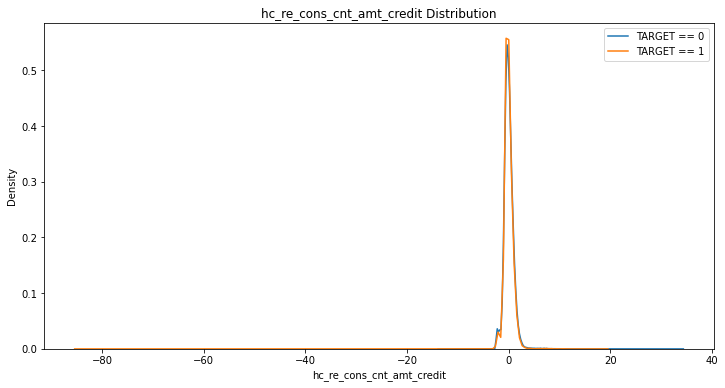

In [292]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_cnt_amt_credit', app_train)

### hc_re_cons_stddev_amt_credit

In [293]:
app_train[['TARGET', 'hc_re_cons_stddev_amt_credit']].corr()

TARGET  hc_re_cons_stddev_amt_credit
TARGET                        1.000000                     -0.016613
hc_re_cons_stddev_amt_credit -0.016613                      1.000000

The correlation between hc_re_cons_stddev_amt_credit and the TARGET is -0.0166
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


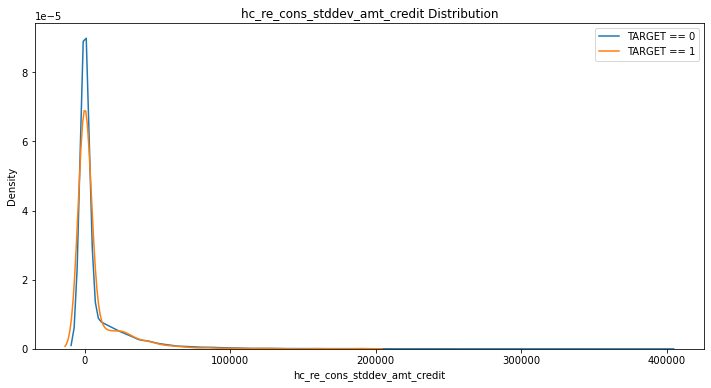

In [294]:
kde_target('hc_re_cons_stddev_amt_credit', app_train)

In [295]:
app_train['hc_re_cons_stddev_amt_credit'].isnull().sum()

286904

In [296]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_amt_credit  
0  52.715068                  11969.085276  
1  49.490411                  11995.675642  
2  54.898630                  11899.523180  
3  38.290411                  11697.769982  
4  35.726027                  11888.405774  

[5 rows x 92 columns]

In [297]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [298]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [299]:
app_train['hc_re_cons_stddev_amt_credit'].isnull().sum()

0

In [300]:
app_train[['TARGET', 'hc_re_cons_stddev_amt_credit']].corr()

TARGET  hc_re_cons_stddev_amt_credit
TARGET                        1.000000                     -0.029024
hc_re_cons_stddev_amt_credit -0.029024                      1.000000

In [301]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_stddev_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_stddev_amt_credit'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_stddev_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_stddev_amt_credit']].corr()

In [302]:
## 標準化
num_cols = ['hc_re_cons_stddev_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_amt_credit', 'TARGET']].corr()

hc_re_cons_stddev_amt_credit    TARGET
hc_re_cons_stddev_amt_credit                      1.000000 -0.029024
TARGET                                           -0.029024  1.000000

The correlation between hc_re_cons_stddev_amt_credit and the TARGET is -0.0290
Median value for loan that was not repaid = -0.2567
Median value for loan that was repaid =     -0.1714


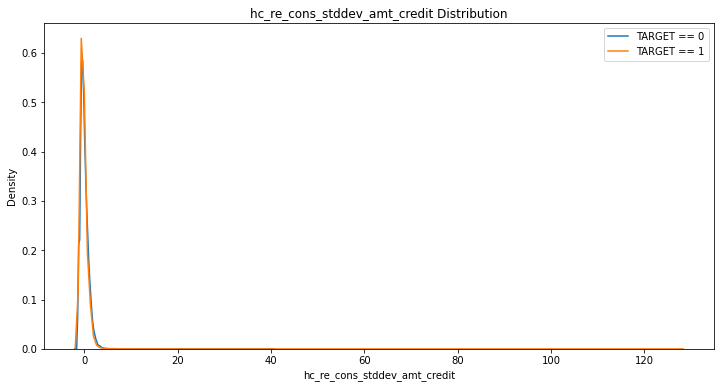

In [303]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_amt_credit', app_train)

### hc_re_cons_stddev_pop_amt_credit

In [304]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_credit']].corr()

TARGET  hc_re_cons_stddev_pop_amt_credit
TARGET                            1.000000                         -0.016613
hc_re_cons_stddev_pop_amt_credit -0.016613                          1.000000

The correlation between hc_re_cons_stddev_pop_amt_credit and the TARGET is -0.0166
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


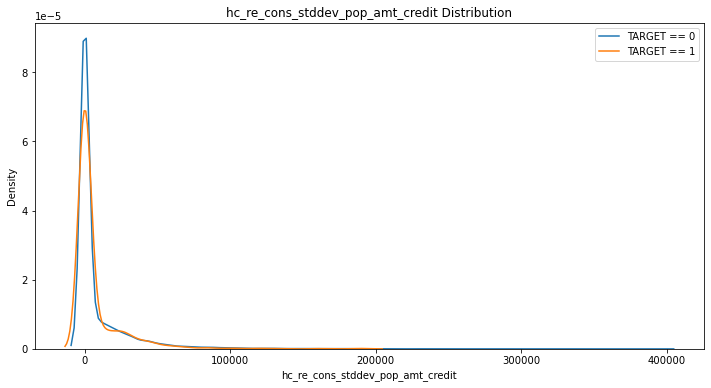

In [305]:
kde_target('hc_re_cons_stddev_pop_amt_credit', app_train)

In [306]:
app_train['hc_re_cons_stddev_pop_amt_credit'].isnull().sum()

286904

In [307]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_pop_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_pop_amt_credit  
0  52.715068                      11969.085276  
1  49.490411                      11995.675642  
2  54.898630                      11899.523180  
3  38.290411                      11697.769982  
4  35.726027                      11888.405774  

[5 rows x 92 columns]

In [308]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [309]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [310]:
app_train['hc_re_cons_stddev_pop_amt_credit'].isnull().sum()

0

In [311]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_credit']].corr()

TARGET  hc_re_cons_stddev_pop_amt_credit
TARGET                            1.000000                         -0.029024
hc_re_cons_stddev_pop_amt_credit -0.029024                          1.000000

In [312]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_stddev_pop_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_stddev_pop_amt_credit'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_stddev_pop_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_credit']].corr()

In [313]:
## 標準化
num_cols = ['hc_re_cons_stddev_pop_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_pop_amt_credit', 'TARGET']].corr()

hc_re_cons_stddev_pop_amt_credit    TARGET
hc_re_cons_stddev_pop_amt_credit                          1.000000 -0.029024
TARGET                                                   -0.029024  1.000000

The correlation between hc_re_cons_stddev_pop_amt_credit and the TARGET is -0.0290
Median value for loan that was not repaid = -0.2567
Median value for loan that was repaid =     -0.1714


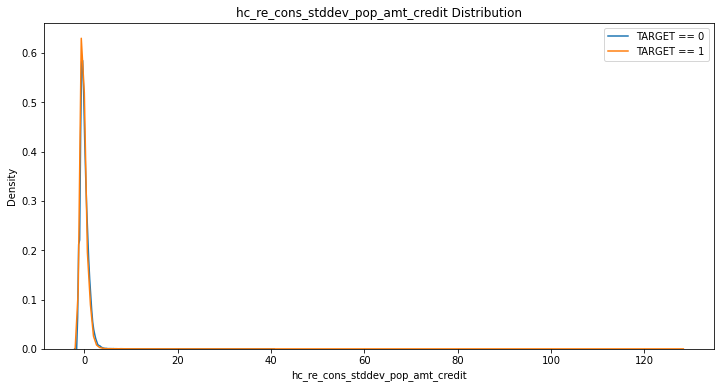

In [314]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_pop_amt_credit', app_train)

### hc_re_cons_var_pop_amt_credit

In [315]:
app_train[['TARGET', 'hc_re_cons_var_pop_amt_credit']].corr()

TARGET  hc_re_cons_var_pop_amt_credit
TARGET                         1.000000                      -0.012787
hc_re_cons_var_pop_amt_credit -0.012787                       1.000000

The correlation between hc_re_cons_var_pop_amt_credit and the TARGET is -0.0128
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


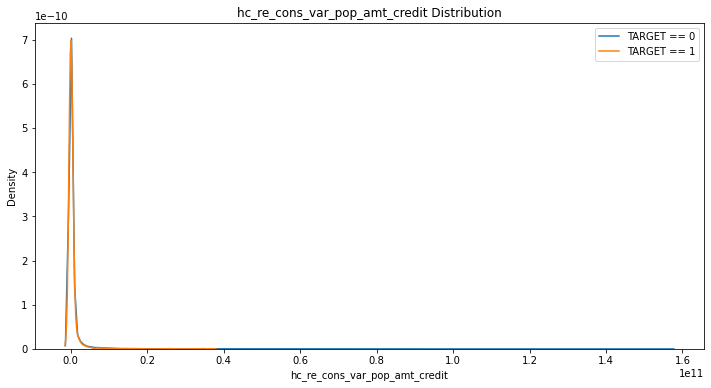

In [316]:
kde_target('hc_re_cons_var_pop_amt_credit', app_train)

In [317]:
app_train['hc_re_cons_var_pop_amt_credit'].isnull().sum()

286904

In [318]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_pop_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_pop_amt_credit  
0  52.715068                   7.966107e+08  
1  49.490411                   7.966105e+08  
2  54.898630                   7.966107e+08  
3  38.290411                   7.966111e+08  
4  35.726027                   7.966107e+08  

[5 rows x 92 columns]

In [319]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [320]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [321]:
app_train['hc_re_cons_var_pop_amt_credit'].isnull().sum()

0

In [322]:
app_train[['TARGET', 'hc_re_cons_var_pop_amt_credit']].corr()

TARGET  hc_re_cons_var_pop_amt_credit
TARGET                         1.000000                      -0.019065
hc_re_cons_var_pop_amt_credit -0.019065                       1.000000

In [323]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_var_pop_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_var_pop_amt_credit'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_var_pop_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_var_pop_amt_credit']].corr()

In [324]:
## 標準化
num_cols = ['hc_re_cons_var_pop_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_pop_amt_credit', 'TARGET']].corr()

hc_re_cons_var_pop_amt_credit    TARGET
hc_re_cons_var_pop_amt_credit                       1.000000 -0.019065
TARGET                                             -0.019065  1.000000

The correlation between hc_re_cons_var_pop_amt_credit and the TARGET is -0.0191
Median value for loan that was not repaid = -0.1500
Median value for loan that was repaid =     -0.1101


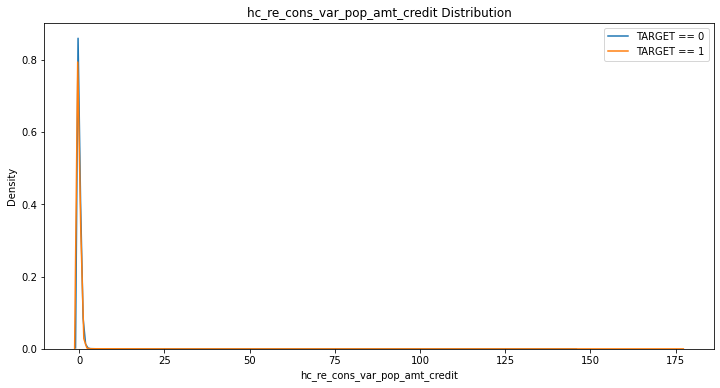

In [325]:

## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_pop_amt_credit', app_train)

### hc_re_cons_var_samp_amt_credit

In [326]:
app_train[['TARGET', 'hc_re_cons_var_samp_amt_credit']].corr()

TARGET  hc_re_cons_var_samp_amt_credit
TARGET                          1.00000                        -0.01281
hc_re_cons_var_samp_amt_credit -0.01281                         1.00000

The correlation between hc_re_cons_var_samp_amt_credit and the TARGET is -0.0128
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


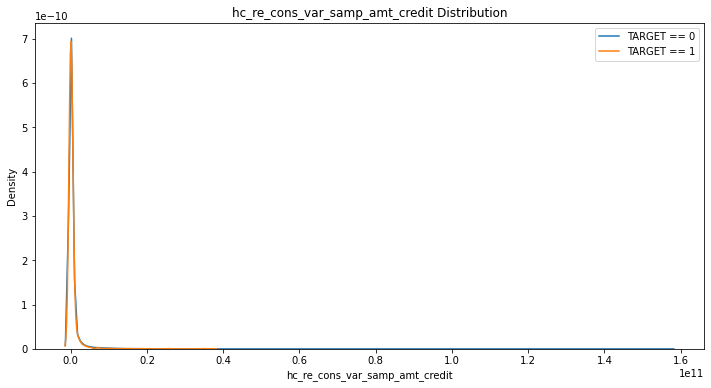

In [327]:
kde_target('hc_re_cons_var_samp_amt_credit', app_train)

In [328]:
app_train['hc_re_cons_var_samp_amt_credit'].isnull().sum()

286904

In [329]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_samp_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_samp_amt_credit  
0  52.715068                    8.010746e+08  
1  49.490411                    8.010744e+08  
2  54.898630                    8.010746e+08  
3  38.290411                    8.010750e+08  
4  35.726027                    8.010746e+08  

[5 rows x 92 columns]

In [330]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [331]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [332]:
app_train['hc_re_cons_var_samp_amt_credit'].isnull().sum()

0

In [333]:
app_train[['TARGET', 'hc_re_cons_var_samp_amt_credit']].corr()

TARGET  hc_re_cons_var_samp_amt_credit
TARGET                          1.000000                       -0.019001
hc_re_cons_var_samp_amt_credit -0.019001                        1.000000

In [334]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_var_samp_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_var_samp_amt_credit'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_var_samp_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_var_samp_amt_credit']].corr()

In [335]:
## 標準化
num_cols = ['hc_re_cons_var_samp_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_samp_amt_credit', 'TARGET']].corr()

hc_re_cons_var_samp_amt_credit    TARGET
hc_re_cons_var_samp_amt_credit                        1.000000 -0.019001
TARGET                                               -0.019001  1.000000

The correlation between hc_re_cons_var_samp_amt_credit and the TARGET is -0.0190
Median value for loan that was not repaid = -0.1494
Median value for loan that was repaid =     -0.1088


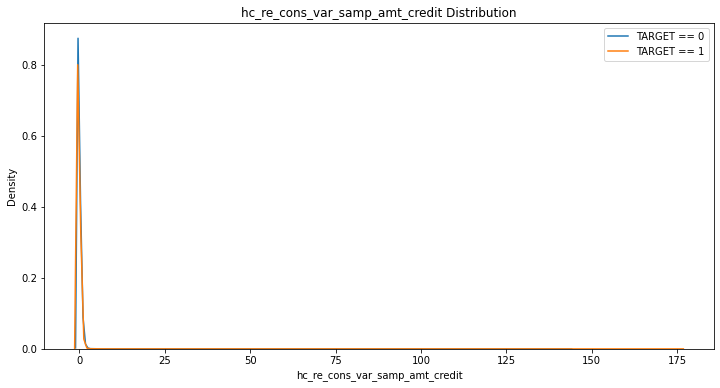

In [336]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_samp_amt_credit', app_train)

### hc_re_cons_variance_samp_amt_credit

In [337]:
app_train[['TARGET', 'hc_re_cons_variance_samp_amt_credit']].corr()

TARGET  \
TARGET                               1.000000   
hc_re_cons_variance_samp_amt_credit -0.012787   

                                     hc_re_cons_variance_samp_amt_credit  
TARGET                                                         -0.012787  
hc_re_cons_variance_samp_amt_credit                             1.000000

The correlation between hc_re_cons_variance_samp_amt_credit and the TARGET is -0.0128
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


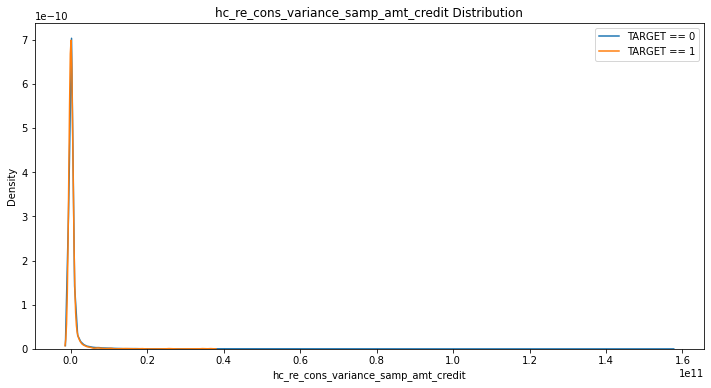

In [338]:
kde_target('hc_re_cons_variance_samp_amt_credit', app_train)

In [339]:
app_train['hc_re_cons_variance_samp_amt_credit'].isnull().sum()

286904

In [340]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_variance_samp_amt_credit')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_variance_samp_amt_credit  
0  52.715068                         7.966107e+08  
1  49.490411                         7.966105e+08  
2  54.898630                         7.966107e+08  
3  38.290411                         7.966111e+08  
4  35.726027                         7.966107e+08  

[5 rows x 92 columns]

In [341]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [342]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [343]:
app_train['hc_re_cons_variance_samp_amt_credit'].isnull().sum()

0

In [344]:
app_train[['TARGET', 'hc_re_cons_variance_samp_amt_credit']].corr()

TARGET  \
TARGET                               1.000000   
hc_re_cons_variance_samp_amt_credit -0.019065   

                                     hc_re_cons_variance_samp_amt_credit  
TARGET                                                         -0.019065  
hc_re_cons_variance_samp_amt_credit                             1.000000

In [345]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_variance_samp_amt_credit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_variance_samp_amt_credit'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_variance_samp_amt_credit'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_variance_samp_amt_credit']].corr()

In [346]:
## 標準化
num_cols = ['hc_re_cons_variance_samp_amt_credit']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_variance_samp_amt_credit', 'TARGET']].corr()

hc_re_cons_variance_samp_amt_credit  \
hc_re_cons_variance_samp_amt_credit                             1.000000   
TARGET                                                         -0.019065   

                                       TARGET  
hc_re_cons_variance_samp_amt_credit -0.019065  
TARGET                               1.000000

The correlation between hc_re_cons_variance_samp_amt_credit and the TARGET is -0.0191
Median value for loan that was not repaid = -0.1500
Median value for loan that was repaid =     -0.1101


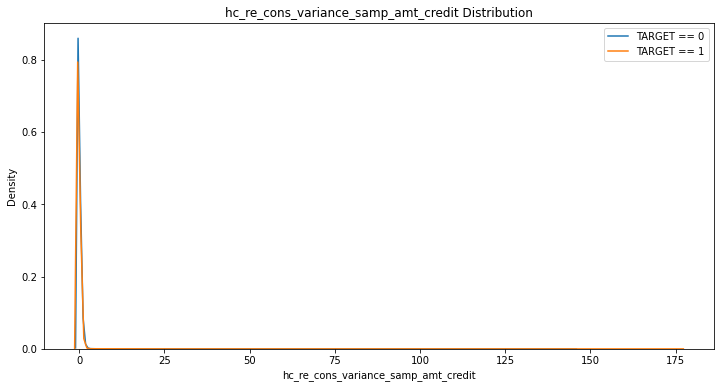

In [347]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_variance_samp_amt_credit', app_train)

### hc_re_cons_max_amt_down_payment

In [348]:
app_train[['TARGET', 'hc_re_cons_max_amt_down_payment']].corr()

TARGET  hc_re_cons_max_amt_down_payment
TARGET                           1.000000                        -0.020593
hc_re_cons_max_amt_down_payment -0.020593                         1.000000

The correlation between hc_re_cons_max_amt_down_payment and the TARGET is -0.0206
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


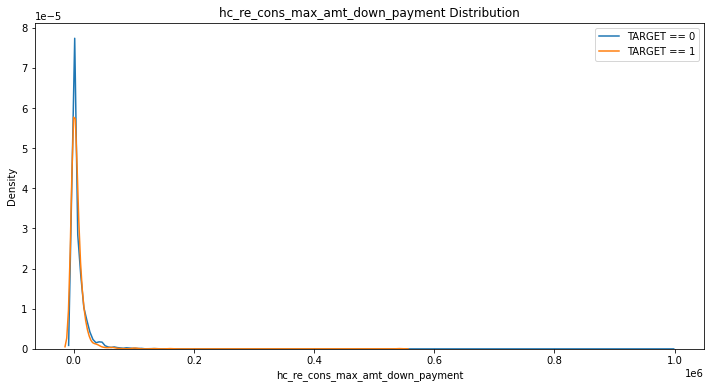

In [349]:
kde_target('hc_re_cons_max_amt_down_payment', app_train)

In [350]:
app_train['hc_re_cons_max_amt_down_payment'].isnull().sum()

286904

In [351]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_max_amt_down_payment')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_max_amt_down_payment  
0  52.715068                     13803.305313  
1  49.490411                      9426.827270  
2  54.898630                     16245.787753  
3  38.290411                     29257.090674  
4  35.726027                     15651.994107  

[5 rows x 92 columns]

In [352]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [353]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [354]:
app_train['hc_re_cons_max_amt_down_payment'].isnull().sum()

0

In [355]:
app_train[['TARGET', 'hc_re_cons_max_amt_down_payment']].corr()

TARGET  hc_re_cons_max_amt_down_payment
TARGET                           1.000000                        -0.021531
hc_re_cons_max_amt_down_payment -0.021531                         1.000000

In [356]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_max_amt_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_max_amt_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_max_amt_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_max_amt_down_payment']].corr()

TARGET  hc_re_cons_max_amt_down_payment
TARGET                           1.000000                        -0.022174
hc_re_cons_max_amt_down_payment -0.022174                         1.000000

In [357]:
## 標準化
num_cols = ['hc_re_cons_max_amt_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_max_amt_down_payment', 'TARGET']].corr()

hc_re_cons_max_amt_down_payment    TARGET
hc_re_cons_max_amt_down_payment                         1.000000 -0.022174
TARGET                                                 -0.022174  1.000000

The correlation between hc_re_cons_max_amt_down_payment and the TARGET is -0.0222
Median value for loan that was not repaid = -0.1000
Median value for loan that was repaid =     -0.0215


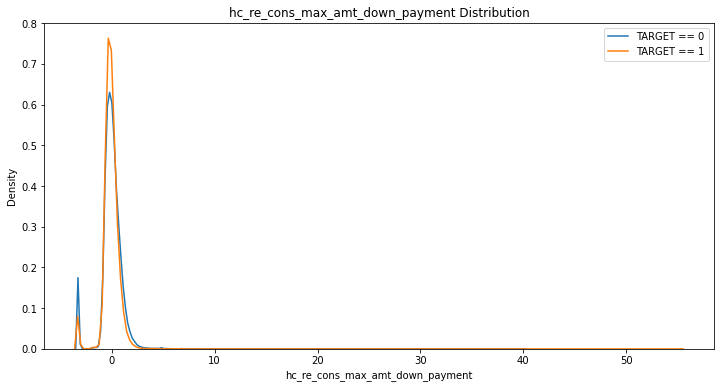

In [358]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_max_amt_down_payment', app_train)

In [360]:
#columns = ['hc_re_cons_max_amt_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_min_amt_down_payment

In [361]:
app_train[['TARGET', 'hc_re_cons_min_amt_down_payment']].corr()

TARGET  hc_re_cons_min_amt_down_payment
TARGET                           1.000000                        -0.018915
hc_re_cons_min_amt_down_payment -0.018915                         1.000000

The correlation between hc_re_cons_min_amt_down_payment and the TARGET is -0.0189
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


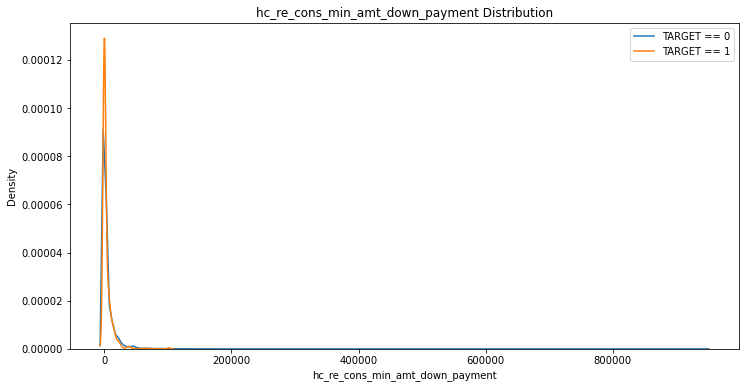

In [362]:
kde_target('hc_re_cons_min_amt_down_payment', app_train)

In [363]:
app_train['hc_re_cons_min_amt_down_payment'].isnull().sum()

286904

In [364]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_min_amt_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_min_amt_down_payment  
0  52.715068                      7922.061331  
1  49.490411                      1560.314867  
2  54.898630                     11474.008368  
3  38.290411                     27987.492890  
4  35.726027                      9938.762489  

[5 rows x 92 columns]

In [365]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [366]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [367]:
app_train['hc_re_cons_min_amt_down_payment'].isnull().sum()

0

In [368]:
app_train[['TARGET', 'hc_re_cons_min_amt_down_payment']].corr()

TARGET  hc_re_cons_min_amt_down_payment
TARGET                           1.000000                        -0.021159
hc_re_cons_min_amt_down_payment -0.021159                         1.000000

In [369]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_min_amt_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_min_amt_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_min_amt_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_min_amt_down_payment']].corr()

TARGET  hc_re_cons_min_amt_down_payment
TARGET                           1.000000                        -0.020198
hc_re_cons_min_amt_down_payment -0.020198                         1.000000

In [370]:
## 標準化
num_cols = ['hc_re_cons_min_amt_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_min_amt_down_payment', 'TARGET']].corr()

hc_re_cons_min_amt_down_payment    TARGET
hc_re_cons_min_amt_down_payment                         1.000000 -0.020198
TARGET                                                 -0.020198  1.000000

The correlation between hc_re_cons_min_amt_down_payment and the TARGET is -0.0202
Median value for loan that was not repaid = -0.0844
Median value for loan that was repaid =     -0.0023


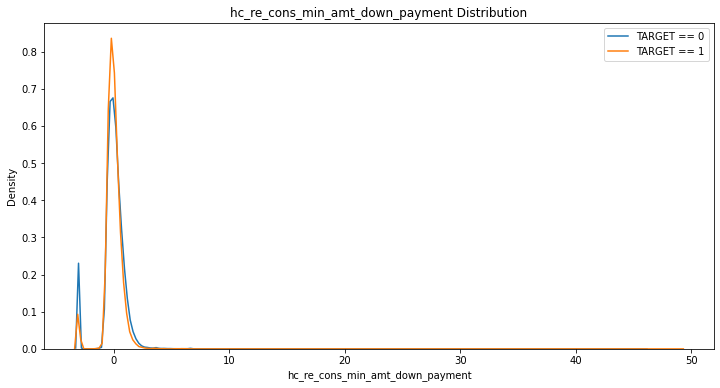

In [371]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_min_amt_down_payment', app_train)

In [372]:
#columns = ['hc_re_cons_min_amt_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_sum_amt_down_payment

In [373]:
app_train[['TARGET', 'hc_re_cons_sum_amt_down_payment']].corr()

TARGET  hc_re_cons_sum_amt_down_payment
TARGET                           1.000000                        -0.006645
hc_re_cons_sum_amt_down_payment -0.006645                         1.000000

The correlation between hc_re_cons_sum_amt_down_payment and the TARGET is -0.0066
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


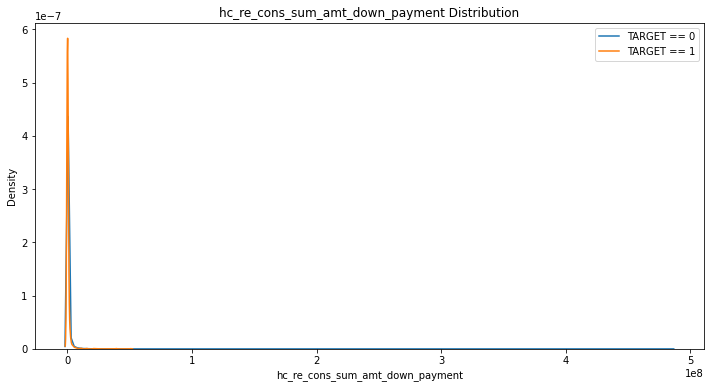

In [374]:
kde_target('hc_re_cons_sum_amt_down_payment', app_train)

In [375]:
app_train['hc_re_cons_sum_amt_down_payment'].isnull().sum()

286904

In [376]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_sum_amt_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_sum_amt_down_payment  
0  52.715068                     1.015073e+06  
1  49.490411                     1.014940e+06  
2  54.898630                     1.015149e+06  
3  38.290411                     1.015572e+06  
4  35.726027                     1.015138e+06  

[5 rows x 92 columns]

In [377]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [378]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [379]:
app_train['hc_re_cons_sum_amt_down_payment'].isnull().sum()

0

In [380]:
app_train[['TARGET', 'hc_re_cons_sum_amt_down_payment']].corr()

TARGET  hc_re_cons_sum_amt_down_payment
TARGET                           1.000000                        -0.010096
hc_re_cons_sum_amt_down_payment -0.010096                         1.000000

In [381]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_sum_amt_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_sum_amt_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_sum_amt_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_sum_amt_down_payment']].corr()

TARGET  hc_re_cons_sum_amt_down_payment
TARGET                           1.000000                        -0.010936
hc_re_cons_sum_amt_down_payment -0.010936                         1.000000

In [382]:
## 標準化
num_cols = ['hc_re_cons_sum_amt_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_sum_amt_down_payment', 'TARGET']].corr()

hc_re_cons_sum_amt_down_payment    TARGET
hc_re_cons_sum_amt_down_payment                         1.000000 -0.010936
TARGET                                                 -0.010936  1.000000

The correlation between hc_re_cons_sum_amt_down_payment and the TARGET is -0.0109
Median value for loan that was not repaid = -0.0140
Median value for loan that was repaid =     0.0233


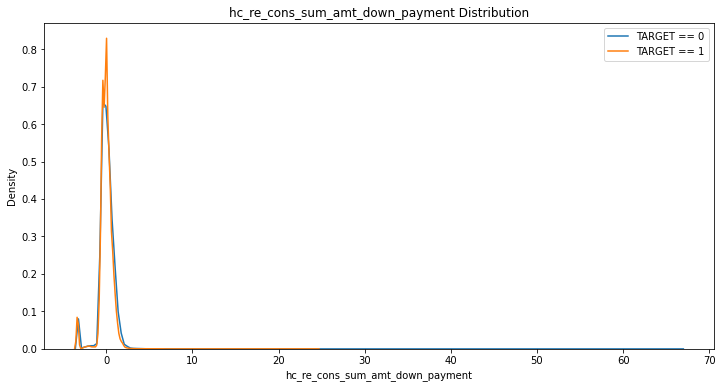

In [383]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_sum_amt_down_payment', app_train)

In [384]:
#columns = ['hc_re_cons_sum_amt_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_avg_amt_down_payment

In [385]:
app_train[['TARGET', 'hc_re_cons_avg_amt_down_payment']].corr()

TARGET  hc_re_cons_avg_amt_down_payment
TARGET                           1.000000                        -0.016352
hc_re_cons_avg_amt_down_payment -0.016352                         1.000000

The correlation between hc_re_cons_avg_amt_down_payment and the TARGET is -0.0164
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


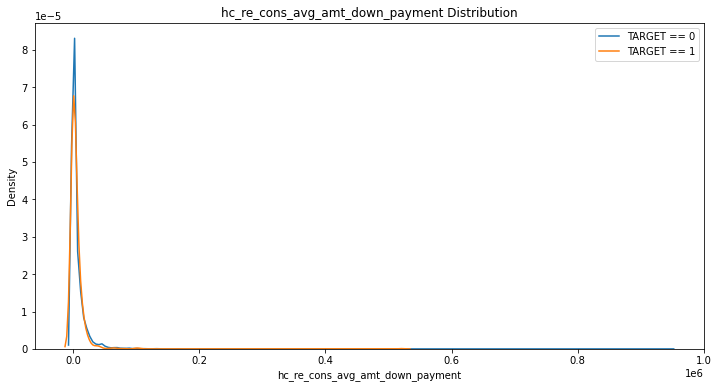

In [386]:
kde_target('hc_re_cons_avg_amt_down_payment', app_train)

In [387]:
app_train['hc_re_cons_avg_amt_down_payment'].isnull().sum()

286904

In [388]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_avg_amt_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_avg_amt_down_payment  
0  52.715068                     12526.509968  
1  49.490411                      7446.414799  
2  54.898630                     15369.270439  
3  38.290411                     30087.370123  
4  35.726027                     14572.448131  

[5 rows x 92 columns]

In [389]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [390]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [391]:
app_train['hc_re_cons_avg_amt_down_payment'].isnull().sum()

0

In [392]:
app_train[['TARGET', 'hc_re_cons_avg_amt_down_payment']].corr()

TARGET  hc_re_cons_avg_amt_down_payment
TARGET                           1.000000                        -0.019679
hc_re_cons_avg_amt_down_payment -0.019679                         1.000000

In [393]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_avg_amt_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_avg_amt_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_avg_amt_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_avg_amt_down_payment']].corr()

TARGET  hc_re_cons_avg_amt_down_payment
TARGET                           1.000000                        -0.022064
hc_re_cons_avg_amt_down_payment -0.022064                         1.000000

In [394]:
## 標準化
num_cols = ['hc_re_cons_avg_amt_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_avg_amt_down_payment', 'TARGET']].corr()

hc_re_cons_avg_amt_down_payment    TARGET
hc_re_cons_avg_amt_down_payment                         1.000000 -0.022064
TARGET                                                 -0.022064  1.000000

The correlation between hc_re_cons_avg_amt_down_payment and the TARGET is -0.0221
Median value for loan that was not repaid = -0.0990
Median value for loan that was repaid =     -0.0157


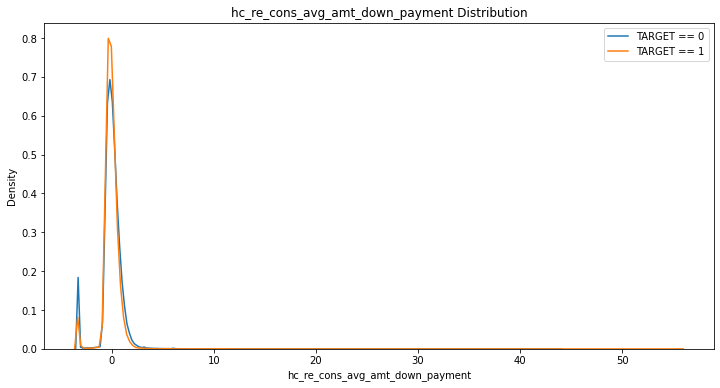

In [395]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_avg_amt_down_payment', app_train)

In [396]:
#columns = ['hc_re_cons_avg_amt_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_cnt_amt_down_payment

In [397]:
app_train[['TARGET', 'hc_re_cons_cnt_amt_down_payment']].corr()

TARGET  hc_re_cons_cnt_amt_down_payment
TARGET                           1.000000                        -0.023152
hc_re_cons_cnt_amt_down_payment -0.023152                         1.000000

The correlation between hc_re_cons_cnt_amt_down_payment and the TARGET is -0.0232
Median value for loan that was not repaid = 64.0000
Median value for loan that was repaid =     81.0000


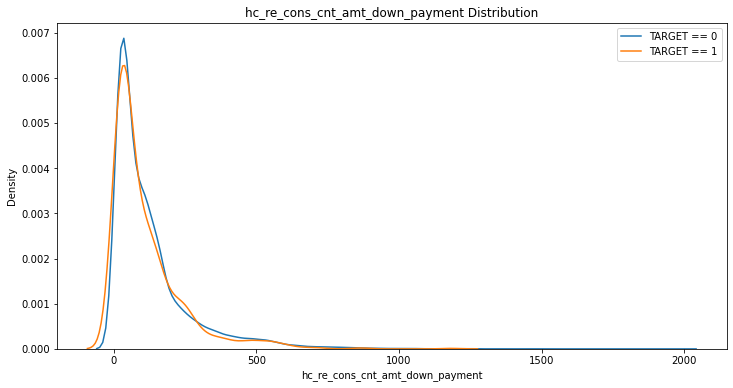

In [398]:
kde_target('hc_re_cons_cnt_amt_down_payment', app_train)

In [399]:
app_train['hc_re_cons_cnt_amt_down_payment'].isnull().sum()

286904

In [400]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_cnt_amt_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_cnt_amt_down_payment  
0  52.715068                       163.998265  
1  49.490411                       157.286037  
2  54.898630                       129.204913  
3  38.290411                        72.600350  
4  35.726027                       121.305041  

[5 rows x 92 columns]

In [401]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [402]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [403]:
app_train['hc_re_cons_cnt_amt_down_payment'].isnull().sum()

0

In [404]:
app_train[['TARGET', 'hc_re_cons_cnt_amt_down_payment']].corr()

TARGET  hc_re_cons_cnt_amt_down_payment
TARGET                           1.000000                        -0.012054
hc_re_cons_cnt_amt_down_payment -0.012054                         1.000000

In [405]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_cnt_amt_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_cnt_amt_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_cnt_amt_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_cnt_amt_down_payment']].corr()

TARGET  hc_re_cons_cnt_amt_down_payment
TARGET                           1.000000                        -0.012063
hc_re_cons_cnt_amt_down_payment -0.012063                         1.000000

In [406]:
## 標準化
num_cols = ['hc_re_cons_cnt_amt_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_cnt_amt_down_payment', 'TARGET']].corr()

hc_re_cons_cnt_amt_down_payment    TARGET
hc_re_cons_cnt_amt_down_payment                         1.000000 -0.012063
TARGET                                                 -0.012063  1.000000

The correlation between hc_re_cons_cnt_amt_down_payment and the TARGET is -0.0121
Median value for loan that was not repaid = -0.1294
Median value for loan that was repaid =     -0.0941


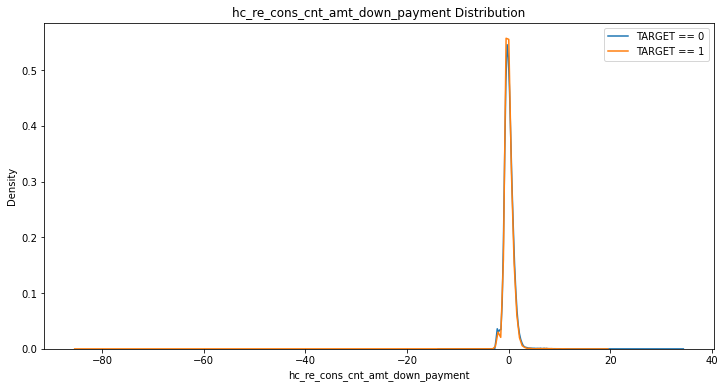

In [407]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_cnt_amt_down_payment', app_train)

In [408]:
#columns = ['hc_re_cons_cnt_amt_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_stddev_amt_down_payment

In [409]:
app_train[['TARGET', 'hc_re_cons_stddev_amt_down_payment']].corr()

TARGET  \
TARGET                              1.000000   
hc_re_cons_stddev_amt_down_payment -0.012332   

                                    hc_re_cons_stddev_amt_down_payment  
TARGET                                                       -0.012332  
hc_re_cons_stddev_amt_down_payment                            1.000000

The correlation between hc_re_cons_stddev_amt_down_payment and the TARGET is -0.0123
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


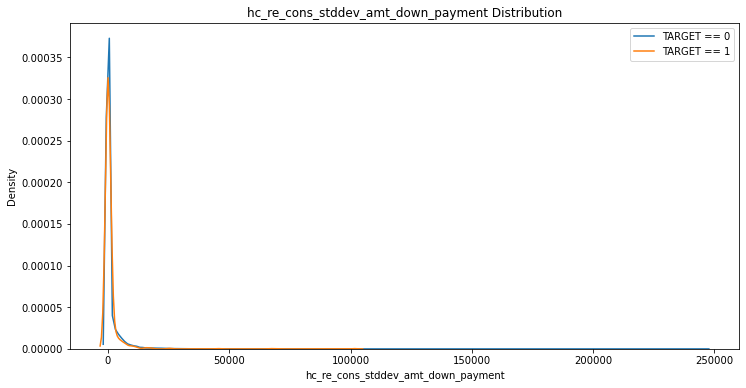

In [410]:
kde_target('hc_re_cons_stddev_amt_down_payment', app_train)

In [411]:
app_train['hc_re_cons_stddev_amt_down_payment'].isnull().sum()

286904

In [412]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_amt_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_amt_down_payment  
0  52.715068                         1720.422960  
1  49.490411                         1883.221511  
2  54.898630                         1625.163501  
3  38.290411                         1191.231189  
4  35.726027                         1659.977792  

[5 rows x 92 columns]

In [413]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [414]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [415]:
app_train['hc_re_cons_stddev_amt_down_payment'].isnull().sum()

0

In [416]:
app_train[['TARGET', 'hc_re_cons_stddev_amt_down_payment']].corr()

TARGET  \
TARGET                              1.000000   
hc_re_cons_stddev_amt_down_payment -0.016335   

                                    hc_re_cons_stddev_amt_down_payment  
TARGET                                                       -0.016335  
hc_re_cons_stddev_amt_down_payment                            1.000000

In [417]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_stddev_amt_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_stddev_amt_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_stddev_amt_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_stddev_amt_down_payment']].corr()

TARGET  \
TARGET                              1.000000   
hc_re_cons_stddev_amt_down_payment -0.012242   

                                    hc_re_cons_stddev_amt_down_payment  
TARGET                                                       -0.012242  
hc_re_cons_stddev_amt_down_payment                            1.000000

In [418]:
## 標準化
num_cols = ['hc_re_cons_stddev_amt_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_amt_down_payment', 'TARGET']].corr()

hc_re_cons_stddev_amt_down_payment  \
hc_re_cons_stddev_amt_down_payment                            1.000000   
TARGET                                                       -0.012242   

                                      TARGET  
hc_re_cons_stddev_amt_down_payment -0.012242  
TARGET                              1.000000

The correlation between hc_re_cons_stddev_amt_down_payment and the TARGET is -0.0122
Median value for loan that was not repaid = -0.0835
Median value for loan that was repaid =     -0.0336


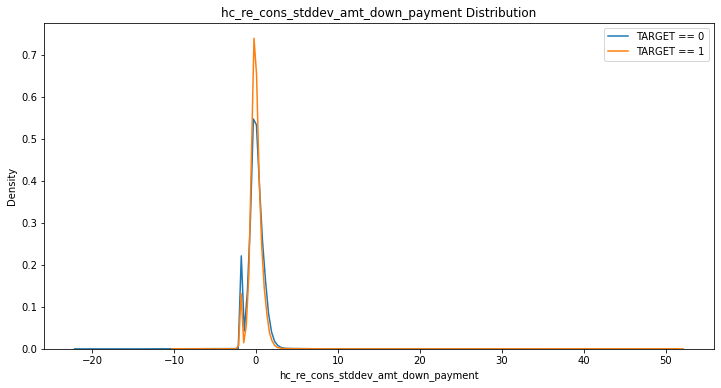

In [419]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_amt_down_payment', app_train)

In [420]:
#columns = ['hc_re_cons_stddev_amt_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_stddev_pop_amt_down_payment

In [421]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_down_payment']].corr()

TARGET  \
TARGET                                  1.000000   
hc_re_cons_stddev_pop_amt_down_payment -0.012332   

                                        hc_re_cons_stddev_pop_amt_down_payment  
TARGET                                                               -0.012332  
hc_re_cons_stddev_pop_amt_down_payment                                1.000000

The correlation between hc_re_cons_stddev_pop_amt_down_payment and the TARGET is -0.0123
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


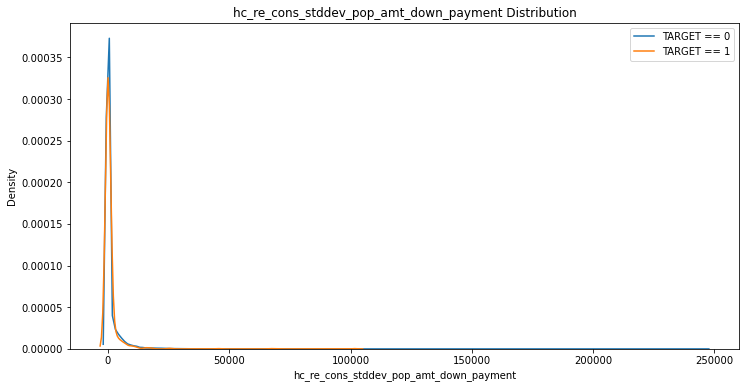

In [422]:
kde_target('hc_re_cons_stddev_pop_amt_down_payment', app_train)

In [423]:
app_train['hc_re_cons_stddev_pop_amt_down_payment'].isnull().sum()

286904

In [424]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_pop_amt_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_pop_amt_down_payment  
0  52.715068                             1720.422960  
1  49.490411                             1883.221511  
2  54.898630                             1625.163501  
3  38.290411                             1191.231189  
4  35.726027                             1659.977792  

[5 rows x 92 columns]

In [425]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [426]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [427]:
app_train['hc_re_cons_stddev_pop_amt_down_payment'].isnull().sum()

0

In [428]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_down_payment']].corr()

TARGET  \
TARGET                                  1.000000   
hc_re_cons_stddev_pop_amt_down_payment -0.016335   

                                        hc_re_cons_stddev_pop_amt_down_payment  
TARGET                                                               -0.016335  
hc_re_cons_stddev_pop_amt_down_payment                                1.000000

In [429]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_stddev_pop_amt_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_stddev_pop_amt_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_stddev_pop_amt_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_down_payment']].corr()

TARGET  \
TARGET                                  1.000000   
hc_re_cons_stddev_pop_amt_down_payment -0.012242   

                                        hc_re_cons_stddev_pop_amt_down_payment  
TARGET                                                               -0.012242  
hc_re_cons_stddev_pop_amt_down_payment                                1.000000

In [430]:
## 標準化
num_cols = ['hc_re_cons_stddev_pop_amt_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_pop_amt_down_payment', 'TARGET']].corr()

hc_re_cons_stddev_pop_amt_down_payment  \
hc_re_cons_stddev_pop_amt_down_payment                                1.000000   
TARGET                                                               -0.012242   

                                          TARGET  
hc_re_cons_stddev_pop_amt_down_payment -0.012242  
TARGET                                  1.000000

The correlation between hc_re_cons_stddev_pop_amt_down_payment and the TARGET is -0.0122
Median value for loan that was not repaid = -0.0835
Median value for loan that was repaid =     -0.0336


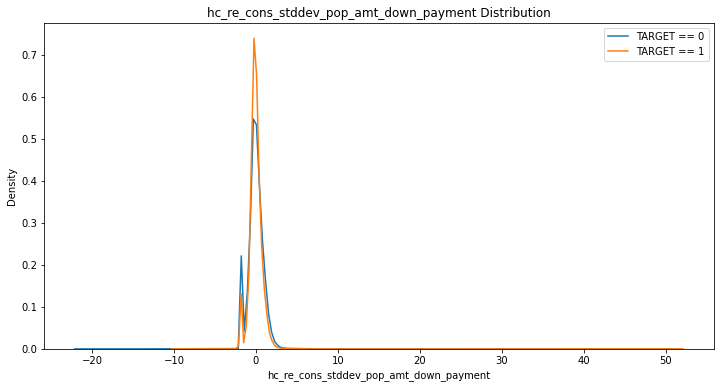

In [431]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_pop_amt_down_payment', app_train)

In [432]:
#columns = ['hc_re_cons_stddev_pop_amt_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_var_pop_amt_down_payment

In [433]:
app_train[['TARGET', 'hc_re_cons_var_pop_amt_down_payment']].corr()

TARGET  \
TARGET                               1.000000   
hc_re_cons_var_pop_amt_down_payment -0.001323   

                                     hc_re_cons_var_pop_amt_down_payment  
TARGET                                                         -0.001323  
hc_re_cons_var_pop_amt_down_payment                             1.000000

The correlation between hc_re_cons_var_pop_amt_down_payment and the TARGET is -0.0013
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


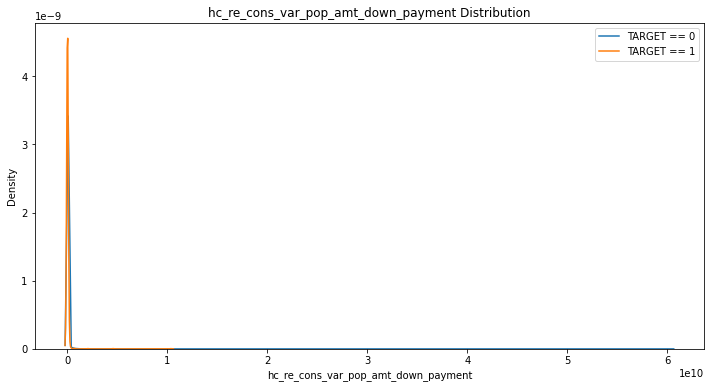

In [434]:
kde_target('hc_re_cons_var_pop_amt_down_payment', app_train)

In [435]:
app_train['hc_re_cons_var_pop_amt_down_payment'].isnull().sum()

286904

In [436]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_pop_amt_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_pop_amt_down_payment  
0  52.715068                         5.575166e+07  
1  49.490411                         5.575188e+07  
2  54.898630                         5.575154e+07  
3  38.290411                         5.575089e+07  
4  35.726027                         5.575157e+07  

[5 rows x 92 columns]

In [437]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [438]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [439]:
app_train['hc_re_cons_var_pop_amt_down_payment'].isnull().sum()

0

In [440]:
app_train[['TARGET', 'hc_re_cons_var_pop_amt_down_payment']].corr()

TARGET  \
TARGET                               1.000000   
hc_re_cons_var_pop_amt_down_payment -0.002296   

                                     hc_re_cons_var_pop_amt_down_payment  
TARGET                                                         -0.002296  
hc_re_cons_var_pop_amt_down_payment                             1.000000

In [441]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_var_pop_amt_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_var_pop_amt_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_var_pop_amt_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_var_pop_amt_down_payment']].corr()

TARGET  \
TARGET                               1.000000   
hc_re_cons_var_pop_amt_down_payment  0.001279   

                                     hc_re_cons_var_pop_amt_down_payment  
TARGET                                                          0.001279  
hc_re_cons_var_pop_amt_down_payment                             1.000000

In [442]:
## 標準化
num_cols = ['hc_re_cons_var_pop_amt_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_pop_amt_down_payment', 'TARGET']].corr()

hc_re_cons_var_pop_amt_down_payment  \
hc_re_cons_var_pop_amt_down_payment                             1.000000   
TARGET                                                          0.001279   

                                       TARGET  
hc_re_cons_var_pop_amt_down_payment  0.001279  
TARGET                               1.000000

The correlation between hc_re_cons_var_pop_amt_down_payment and the TARGET is 0.0013
Median value for loan that was not repaid = 0.0865
Median value for loan that was repaid =     0.1079


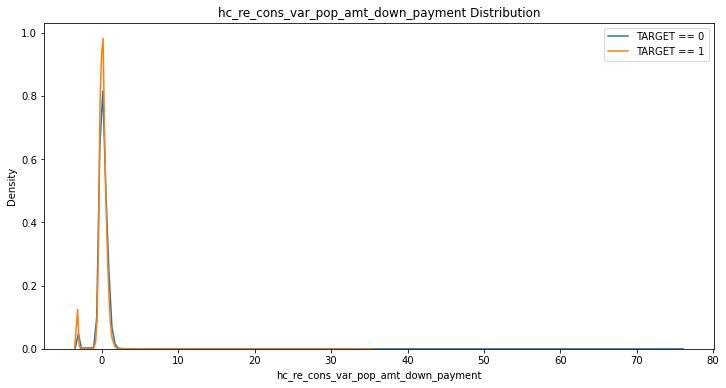

In [443]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_pop_amt_down_payment', app_train)

In [444]:
#columns = ['hc_re_cons_var_pop_amt_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_var_samp_amt_down_payment

In [445]:
app_train[['TARGET', 'hc_re_cons_var_samp_amt_down_payment']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_var_samp_amt_down_payment -0.001333   

                                      hc_re_cons_var_samp_amt_down_payment  
TARGET                                                           -0.001333  
hc_re_cons_var_samp_amt_down_payment                              1.000000

The correlation between hc_re_cons_var_samp_amt_down_payment and the TARGET is -0.0013
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


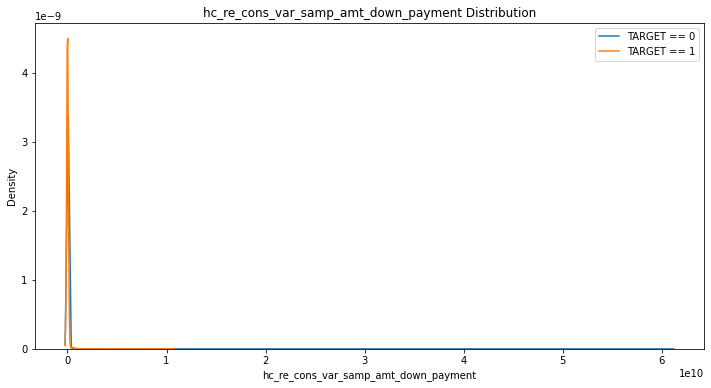

In [446]:
kde_target('hc_re_cons_var_samp_amt_down_payment', app_train)

In [447]:
app_train['hc_re_cons_var_samp_amt_down_payment'].isnull().sum()

286904

In [448]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_samp_amt_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_samp_amt_down_payment  
0  52.715068                          5.604345e+07  
1  49.490411                          5.604367e+07  
2  54.898630                          5.604333e+07  
3  38.290411                          5.604268e+07  
4  35.726027                          5.604335e+07  

[5 rows x 92 columns]

In [449]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [450]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [451]:
app_train['hc_re_cons_var_samp_amt_down_payment'].isnull().sum()

0

In [452]:
app_train[['TARGET', 'hc_re_cons_var_samp_amt_down_payment']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_var_samp_amt_down_payment -0.002301   

                                      hc_re_cons_var_samp_amt_down_payment  
TARGET                                                           -0.002301  
hc_re_cons_var_samp_amt_down_payment                              1.000000

In [453]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_var_samp_amt_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_var_samp_amt_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_var_samp_amt_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_var_samp_amt_down_payment']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_var_samp_amt_down_payment  0.001275   

                                      hc_re_cons_var_samp_amt_down_payment  
TARGET                                                            0.001275  
hc_re_cons_var_samp_amt_down_payment                              1.000000

In [454]:
## 標準化
num_cols = ['hc_re_cons_var_samp_amt_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_samp_amt_down_payment', 'TARGET']].corr()

hc_re_cons_var_samp_amt_down_payment  \
hc_re_cons_var_samp_amt_down_payment                              1.000000   
TARGET                                                            0.001275   

                                        TARGET  
hc_re_cons_var_samp_amt_down_payment  0.001275  
TARGET                                1.000000

The correlation between hc_re_cons_var_samp_amt_down_payment and the TARGET is 0.0013
Median value for loan that was not repaid = 0.0860
Median value for loan that was repaid =     0.1077


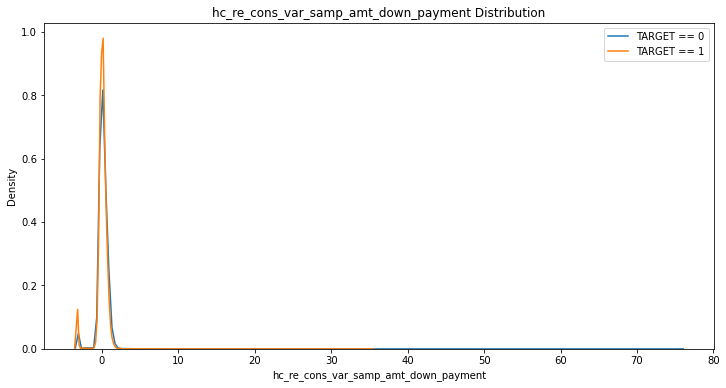

In [455]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_samp_amt_down_payment', app_train)

In [456]:
#columns = ['hc_re_cons_var_samp_amt_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_variance_samp_amt_down_payment

In [457]:
app_train[['TARGET', 'hc_re_cons_variance_samp_amt_down_payment']].corr()

TARGET  \
TARGET                                     1.000000   
hc_re_cons_variance_samp_amt_down_payment -0.001323   

                                           hc_re_cons_variance_samp_amt_down_payment  
TARGET                                                                     -0.001323  
hc_re_cons_variance_samp_amt_down_payment                                   1.000000

The correlation between hc_re_cons_variance_samp_amt_down_payment and the TARGET is -0.0013
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


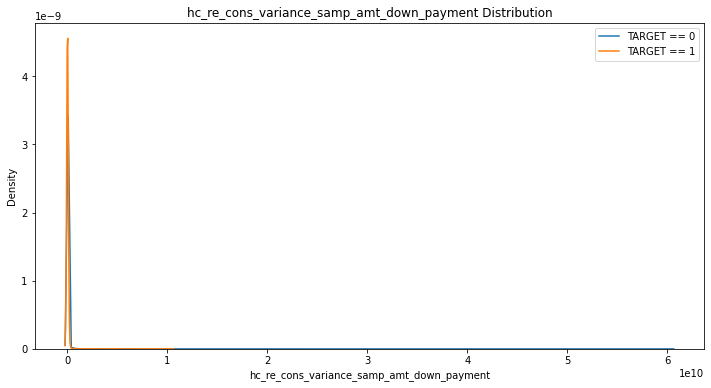

In [458]:
kde_target('hc_re_cons_variance_samp_amt_down_payment', app_train)

In [459]:
app_train['hc_re_cons_variance_samp_amt_down_payment'].isnull().sum()

286904

In [460]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_variance_samp_amt_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_variance_samp_amt_down_payment  
0  52.715068                               5.575166e+07  
1  49.490411                               5.575188e+07  
2  54.898630                               5.575154e+07  
3  38.290411                               5.575089e+07  
4  35.726027                               5.575157e+07  

[5 rows x 92 columns]

In [461]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [462]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [463]:
app_train['hc_re_cons_variance_samp_amt_down_payment'].isnull().sum()

0

In [464]:
app_train[['TARGET', 'hc_re_cons_variance_samp_amt_down_payment']].corr()

TARGET  \
TARGET                                     1.000000   
hc_re_cons_variance_samp_amt_down_payment -0.002296   

                                           hc_re_cons_variance_samp_amt_down_payment  
TARGET                                                                     -0.002296  
hc_re_cons_variance_samp_amt_down_payment                                   1.000000

In [465]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_variance_samp_amt_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_variance_samp_amt_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_variance_samp_amt_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_variance_samp_amt_down_payment']].corr()

TARGET  \
TARGET                                     1.000000   
hc_re_cons_variance_samp_amt_down_payment  0.001279   

                                           hc_re_cons_variance_samp_amt_down_payment  
TARGET                                                                      0.001279  
hc_re_cons_variance_samp_amt_down_payment                                   1.000000

In [466]:
## 標準化
num_cols = ['hc_re_cons_variance_samp_amt_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_variance_samp_amt_down_payment', 'TARGET']].corr()

hc_re_cons_variance_samp_amt_down_payment  \
hc_re_cons_variance_samp_amt_down_payment                                   1.000000   
TARGET                                                                      0.001279   

                                             TARGET  
hc_re_cons_variance_samp_amt_down_payment  0.001279  
TARGET                                     1.000000

The correlation between hc_re_cons_variance_samp_amt_down_payment and the TARGET is 0.0013
Median value for loan that was not repaid = 0.0865
Median value for loan that was repaid =     0.1079


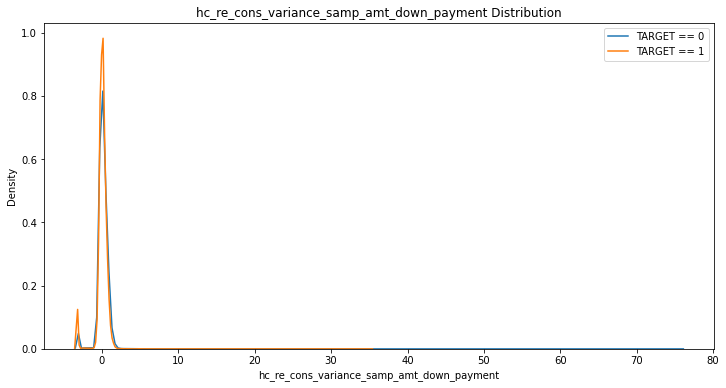

In [467]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_variance_samp_amt_down_payment', app_train)

In [468]:
#columns = ['hc_re_cons_variance_samp_amt_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_max_amt_goods_price

In [469]:
app_train[['TARGET', 'hc_re_cons_max_amt_goods_price']].corr()

TARGET  hc_re_cons_max_amt_goods_price
TARGET                          1.000000                       -0.046377
hc_re_cons_max_amt_goods_price -0.046377                        1.000000

The correlation between hc_re_cons_max_amt_goods_price and the TARGET is -0.0464
Median value for loan that was not repaid = 81841.5000
Median value for loan that was repaid =     98550.0000


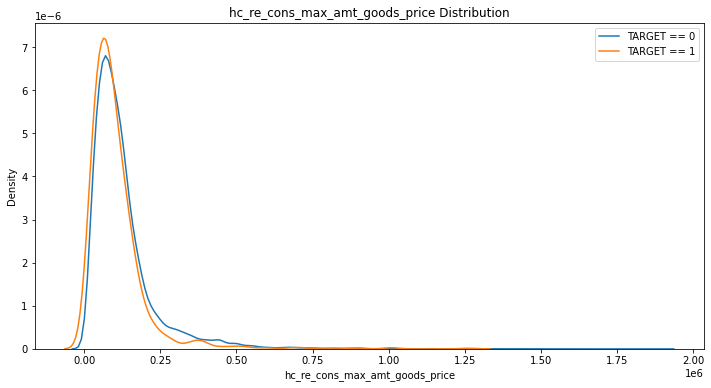

In [470]:
kde_target('hc_re_cons_max_amt_goods_price', app_train)

In [471]:
app_train['hc_re_cons_max_amt_goods_price'].isnull().sum()

286904

In [472]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_max_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_max_amt_goods_price  
0  52.715068                   232623.521131  
1  49.490411                   145483.947772  
2  54.898630                   264420.437074  
3  38.290411                   497616.262042  
4  35.726027                   252687.230875  

[5 rows x 92 columns]

In [473]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [474]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [475]:
app_train['hc_re_cons_max_amt_goods_price'].isnull().sum()

0

In [476]:
app_train[['TARGET', 'hc_re_cons_max_amt_goods_price']].corr()

TARGET  hc_re_cons_max_amt_goods_price
TARGET                          1.000000                       -0.033999
hc_re_cons_max_amt_goods_price -0.033999                        1.000000

In [477]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_max_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_max_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_max_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_max_amt_goods_price']].corr()

TARGET  hc_re_cons_max_amt_goods_price
TARGET                          1.000000                       -0.040929
hc_re_cons_max_amt_goods_price -0.040929                        1.000000

In [478]:
## 標準化
num_cols = ['hc_re_cons_max_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_max_amt_goods_price', 'TARGET']].corr()

hc_re_cons_max_amt_goods_price    TARGET
hc_re_cons_max_amt_goods_price                        1.000000 -0.040929
TARGET                                               -0.040929  1.000000

The correlation between hc_re_cons_max_amt_goods_price and the TARGET is -0.0409
Median value for loan that was not repaid = -0.2023
Median value for loan that was repaid =     -0.0487


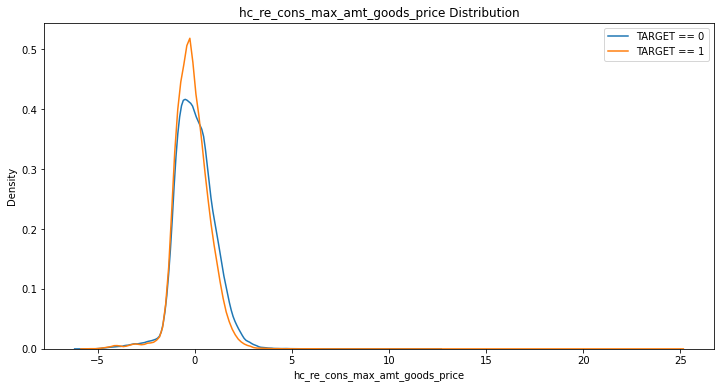

In [479]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_max_amt_goods_price', app_train)

### hc_re_cons_min_amt_goods_price

In [480]:
app_train[['TARGET', 'hc_re_cons_min_amt_goods_price']].corr()

TARGET  hc_re_cons_min_amt_goods_price
TARGET                          1.000000                       -0.041517
hc_re_cons_min_amt_goods_price -0.041517                        1.000000

The correlation between hc_re_cons_min_amt_goods_price and the TARGET is -0.0415
Median value for loan that was not repaid = 64325.0000
Median value for loan that was repaid =     76410.0000


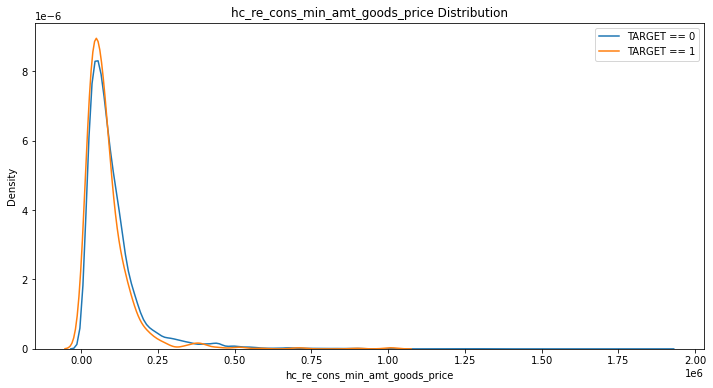

In [481]:
kde_target('hc_re_cons_min_amt_goods_price', app_train)

In [482]:
app_train['hc_re_cons_min_amt_goods_price'].isnull().sum()

286904

In [483]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_min_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_min_amt_goods_price  
0  52.715068                   194713.203052  
1  49.490411                   105439.343080  
2  54.898630                   231861.312527  
3  38.290411                   477164.738681  
4  35.726027                   219892.693447  

[5 rows x 92 columns]

In [484]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [485]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [486]:
app_train['hc_re_cons_min_amt_goods_price'].isnull().sum()

0

In [487]:
app_train[['TARGET', 'hc_re_cons_min_amt_goods_price']].corr()

TARGET  hc_re_cons_min_amt_goods_price
TARGET                          1.000000                       -0.035016
hc_re_cons_min_amt_goods_price -0.035016                        1.000000

In [488]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_min_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_min_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_min_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_min_amt_goods_price']].corr()

TARGET  hc_re_cons_min_amt_goods_price
TARGET                          1.000000                       -0.041314
hc_re_cons_min_amt_goods_price -0.041314                        1.000000

In [489]:
## 標準化
num_cols = ['hc_re_cons_min_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_min_amt_goods_price', 'TARGET']].corr()

hc_re_cons_min_amt_goods_price    TARGET
hc_re_cons_min_amt_goods_price                        1.000000 -0.041314
TARGET                                               -0.041314  1.000000

The correlation between hc_re_cons_min_amt_goods_price and the TARGET is -0.0413
Median value for loan that was not repaid = -0.2081
Median value for loan that was repaid =     -0.0404


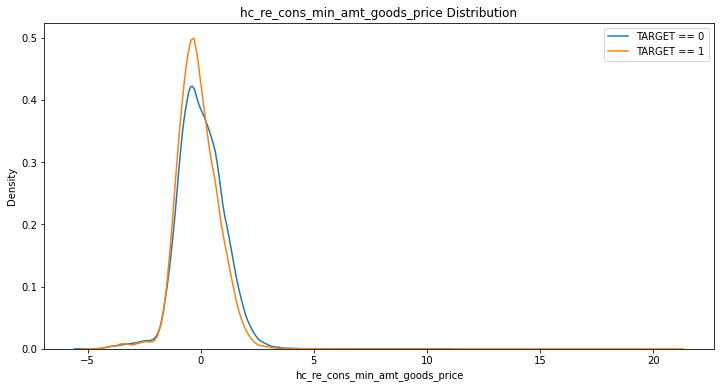

In [490]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_min_amt_goods_price', app_train)

### hc_re_cons_sum_amt_goods_price

In [491]:
app_train[['TARGET', 'hc_re_cons_sum_amt_goods_price']].corr()

TARGET  hc_re_cons_sum_amt_goods_price
TARGET                          1.000000                       -0.026303
hc_re_cons_sum_amt_goods_price -0.026303                        1.000000

The correlation between hc_re_cons_sum_amt_goods_price and the TARGET is -0.0263
Median value for loan that was not repaid = 4641063.0000
Median value for loan that was repaid =     6930180.0000


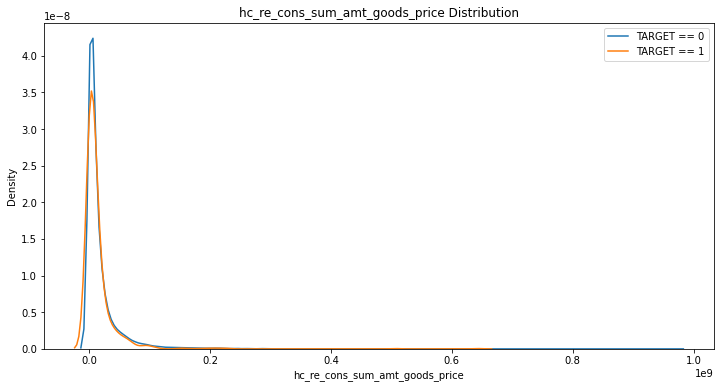

In [492]:
kde_target('hc_re_cons_sum_amt_goods_price', app_train)

In [493]:
app_train['hc_re_cons_sum_amt_goods_price'].isnull().sum()

286904

In [494]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_sum_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_sum_amt_goods_price  
0  52.715068                    2.641582e+07  
1  49.490411                    2.440344e+07  
2  54.898630                    2.719759e+07  
3  38.290411                    3.302820e+07  
4  35.726027                    2.704265e+07  

[5 rows x 92 columns]

In [495]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [496]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [497]:
app_train['hc_re_cons_sum_amt_goods_price'].isnull().sum()

0

In [498]:
app_train[['TARGET', 'hc_re_cons_sum_amt_goods_price']].corr()

TARGET  hc_re_cons_sum_amt_goods_price
TARGET                          1.000000                       -0.030392
hc_re_cons_sum_amt_goods_price -0.030392                        1.000000

In [499]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_sum_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_sum_amt_goods_price'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_sum_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_sum_amt_goods_price']].corr()

In [500]:
## 標準化
num_cols = ['hc_re_cons_sum_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_sum_amt_goods_price', 'TARGET']].corr()

hc_re_cons_sum_amt_goods_price    TARGET
hc_re_cons_sum_amt_goods_price                        1.000000 -0.030392
TARGET                                               -0.030392  1.000000

The correlation between hc_re_cons_sum_amt_goods_price and the TARGET is -0.0304
Median value for loan that was not repaid = -0.2101
Median value for loan that was repaid =     -0.1476


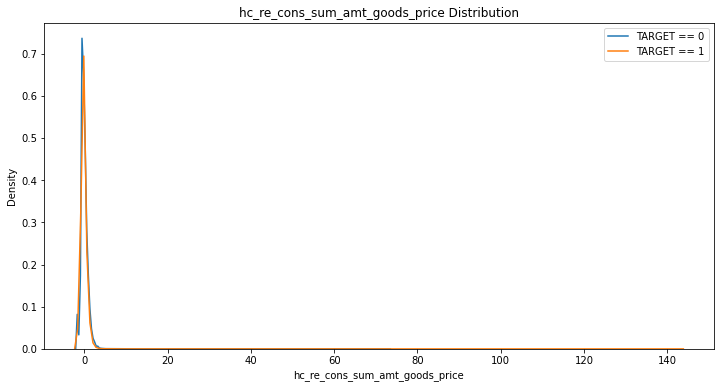

In [501]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_sum_amt_goods_price', app_train)

In [502]:
### hc_re_cons_cnt_amt_goods_price

In [503]:
app_train[['TARGET', 'hc_re_cons_cnt_amt_goods_price']].corr()

TARGET  hc_re_cons_cnt_amt_goods_price
TARGET                          1.000000                       -0.023163
hc_re_cons_cnt_amt_goods_price -0.023163                        1.000000

The correlation between hc_re_cons_cnt_amt_goods_price and the TARGET is -0.0232
Median value for loan that was not repaid = 64.0000
Median value for loan that was repaid =     81.0000


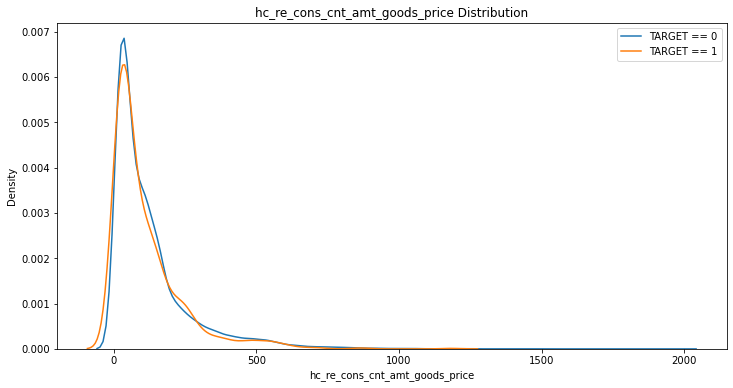

In [504]:
kde_target('hc_re_cons_cnt_amt_goods_price', app_train)

In [505]:
app_train['hc_re_cons_cnt_amt_goods_price'].isnull().sum()

286904

In [506]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_cnt_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_cnt_amt_goods_price  
0  52.715068                      163.998265  
1  49.490411                      157.286037  
2  54.898630                      129.204913  
3  38.290411                       72.600350  
4  35.726027                      121.305041  

[5 rows x 92 columns]

In [507]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [508]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [509]:
app_train['hc_re_cons_cnt_amt_goods_price'].isnull().sum()

0

In [510]:
app_train[['TARGET', 'hc_re_cons_cnt_amt_goods_price']].corr()

TARGET  hc_re_cons_cnt_amt_goods_price
TARGET                          1.00000                        -0.01208
hc_re_cons_cnt_amt_goods_price -0.01208                         1.00000

In [511]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_cnt_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_cnt_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_cnt_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_cnt_amt_goods_price']].corr()

TARGET  hc_re_cons_cnt_amt_goods_price
TARGET                          1.000000                       -0.012089
hc_re_cons_cnt_amt_goods_price -0.012089                        1.000000

In [512]:
## 標準化
num_cols = ['hc_re_cons_cnt_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_cnt_amt_goods_price', 'TARGET']].corr()

hc_re_cons_cnt_amt_goods_price    TARGET
hc_re_cons_cnt_amt_goods_price                        1.000000 -0.012089
TARGET                                               -0.012089  1.000000

The correlation between hc_re_cons_cnt_amt_goods_price and the TARGET is -0.0121
Median value for loan that was not repaid = -0.1295
Median value for loan that was repaid =     -0.0940


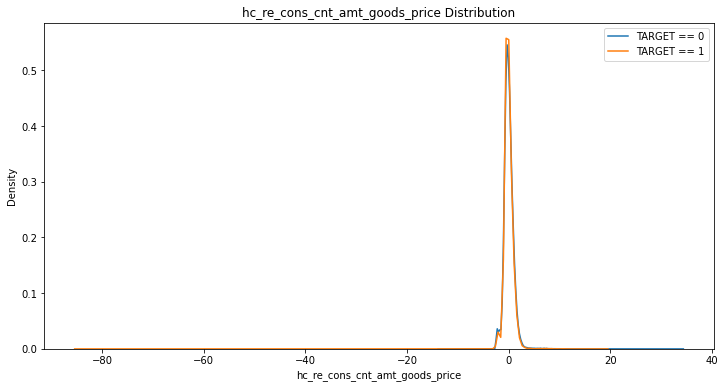

In [513]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_cnt_amt_goods_price', app_train)

### hc_re_cons_avg_amt_goods_price

In [514]:
app_train[['TARGET', 'hc_re_cons_avg_amt_goods_price']].corr()

TARGET  hc_re_cons_avg_amt_goods_price
TARGET                          1.000000                       -0.044081
hc_re_cons_avg_amt_goods_price -0.044081                        1.000000

The correlation between hc_re_cons_avg_amt_goods_price and the TARGET is -0.0441
Median value for loan that was not repaid = 76385.0000
Median value for loan that was repaid =     90049.0000


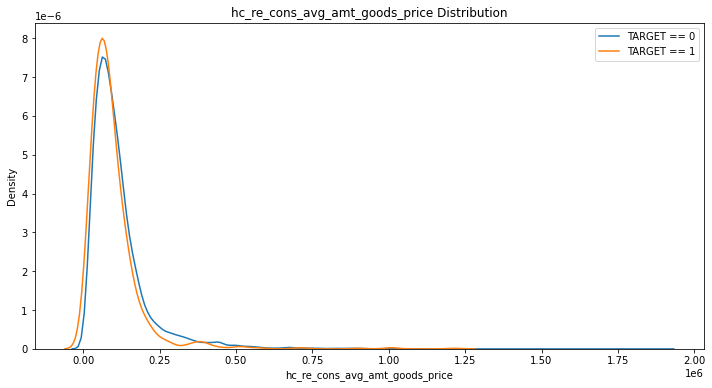

In [515]:
kde_target('hc_re_cons_avg_amt_goods_price', app_train)

In [516]:
app_train['hc_re_cons_avg_amt_goods_price'].isnull().sum()

286904

In [517]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_avg_amt_goods_price')
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_avg_amt_goods_price  
0  52.715068                   223009.287688  
1  49.490411                   134487.806309  
2  54.898630                   256674.621991  
3  38.290411                   495089.334386  
4  35.726027                   244685.281453  

[5 rows x 92 columns]

In [518]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [519]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [520]:
app_train['hc_re_cons_avg_amt_goods_price'].isnull().sum()

0

In [521]:
app_train[['TARGET', 'hc_re_cons_avg_amt_goods_price']].corr()

TARGET  hc_re_cons_avg_amt_goods_price
TARGET                          1.000000                       -0.035261
hc_re_cons_avg_amt_goods_price -0.035261                        1.000000

In [522]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_avg_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_avg_amt_goods_price'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_avg_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_avg_amt_goods_price']].corr()

TARGET  hc_re_cons_avg_amt_goods_price
TARGET                          1.000000                       -0.042749
hc_re_cons_avg_amt_goods_price -0.042749                        1.000000

In [523]:
## 標準化
num_cols = ['hc_re_cons_avg_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_avg_amt_goods_price', 'TARGET']].corr()

hc_re_cons_avg_amt_goods_price    TARGET
hc_re_cons_avg_amt_goods_price                        1.000000 -0.042749
TARGET                                               -0.042749  1.000000

The correlation between hc_re_cons_avg_amt_goods_price and the TARGET is -0.0427
Median value for loan that was not repaid = -0.2105
Median value for loan that was repaid =     -0.0452


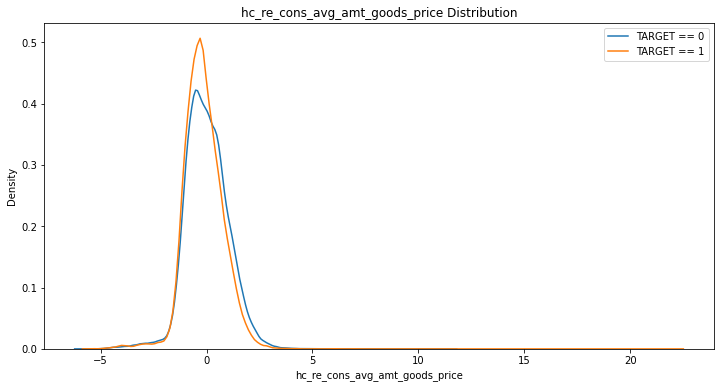

In [524]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_avg_amt_goods_price', app_train)

### hc_re_cons_stddev_amt_goods_price

In [525]:
app_train[['TARGET', 'hc_re_cons_stddev_amt_goods_price']].corr()

TARGET  hc_re_cons_stddev_amt_goods_price
TARGET                             1.000000                          -0.017648
hc_re_cons_stddev_amt_goods_price -0.017648                           1.000000

The correlation between hc_re_cons_stddev_amt_goods_price and the TARGET is -0.0176
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


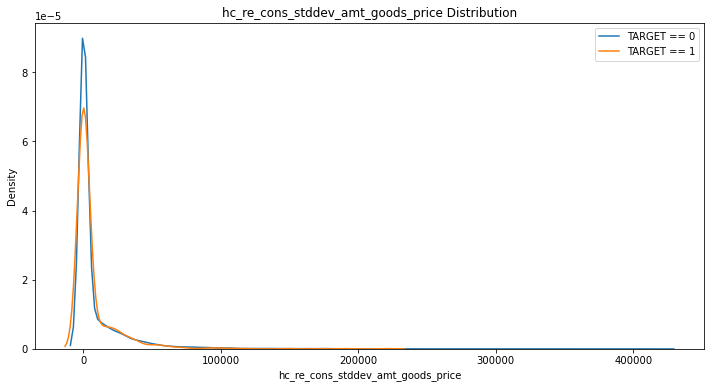

In [526]:
kde_target('hc_re_cons_stddev_amt_goods_price', app_train)

In [527]:
app_train['hc_re_cons_stddev_amt_goods_price'].isnull().sum()

286904

In [528]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_amt_goods_price  
0  52.715068                       12251.787093  
1  49.490411                       12277.175687  
2  54.898630                       12187.822133  
3  38.290411                       12017.066879  
4  35.726027                       12182.646288  

[5 rows x 92 columns]

In [529]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [530]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [531]:
app_train['hc_re_cons_stddev_amt_goods_price'].isnull().sum()

0

In [532]:
app_train[['TARGET', 'hc_re_cons_stddev_amt_goods_price']].corr()

TARGET  hc_re_cons_stddev_amt_goods_price
TARGET                             1.000000                          -0.030919
hc_re_cons_stddev_amt_goods_price -0.030919                           1.000000

In [533]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_stddev_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_stddev_amt_goods_price'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_stddev_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_stddev_amt_goods_price']].corr()

In [534]:
## 標準化
num_cols = ['hc_re_cons_stddev_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_amt_goods_price', 'TARGET']].corr()

hc_re_cons_stddev_amt_goods_price    TARGET
hc_re_cons_stddev_amt_goods_price                           1.000000 -0.030919
TARGET                                                     -0.030919  1.000000

The correlation between hc_re_cons_stddev_amt_goods_price and the TARGET is -0.0309
Median value for loan that was not repaid = -0.2644
Median value for loan that was repaid =     -0.1731


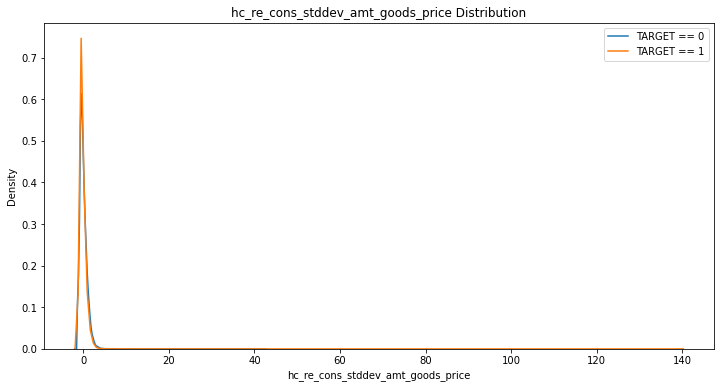

In [535]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_amt_goods_price', app_train)

### hc_re_cons_stddev_pop_amt_goods_price

In [536]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_goods_price']].corr()

TARGET  \
TARGET                                 1.000000   
hc_re_cons_stddev_pop_amt_goods_price -0.017648   

                                       hc_re_cons_stddev_pop_amt_goods_price  
TARGET                                                             -0.017648  
hc_re_cons_stddev_pop_amt_goods_price                               1.000000

The correlation between hc_re_cons_stddev_pop_amt_goods_price and the TARGET is -0.0176
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


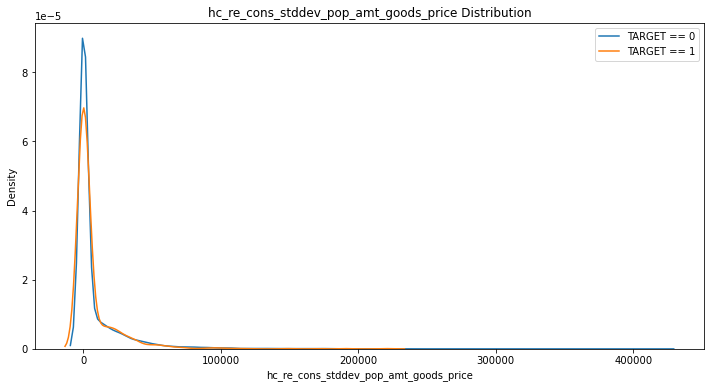

In [537]:
kde_target('hc_re_cons_stddev_pop_amt_goods_price', app_train)

In [538]:
app_train['hc_re_cons_stddev_pop_amt_goods_price'].isnull().sum()

286904

In [539]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_pop_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_pop_amt_goods_price  
0  52.715068                           12251.787093  
1  49.490411                           12277.175687  
2  54.898630                           12187.822133  
3  38.290411                           12017.066879  
4  35.726027                           12182.646288  

[5 rows x 92 columns]

In [540]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [541]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [542]:
app_train['hc_re_cons_stddev_pop_amt_goods_price'].isnull().sum()

0

In [543]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_goods_price']].corr()

TARGET  \
TARGET                                 1.000000   
hc_re_cons_stddev_pop_amt_goods_price -0.030919   

                                       hc_re_cons_stddev_pop_amt_goods_price  
TARGET                                                             -0.030919  
hc_re_cons_stddev_pop_amt_goods_price                               1.000000

In [544]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_stddev_pop_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_stddev_pop_amt_goods_price'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_stddev_pop_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_stddev_pop_amt_goods_price']].corr()

In [545]:
## 標準化
num_cols = ['hc_re_cons_stddev_pop_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_pop_amt_goods_price', 'TARGET']].corr()

hc_re_cons_stddev_pop_amt_goods_price  \
hc_re_cons_stddev_pop_amt_goods_price                               1.000000   
TARGET                                                             -0.030919   

                                         TARGET  
hc_re_cons_stddev_pop_amt_goods_price -0.030919  
TARGET                                 1.000000

The correlation between hc_re_cons_stddev_pop_amt_goods_price and the TARGET is -0.0309
Median value for loan that was not repaid = -0.2644
Median value for loan that was repaid =     -0.1731


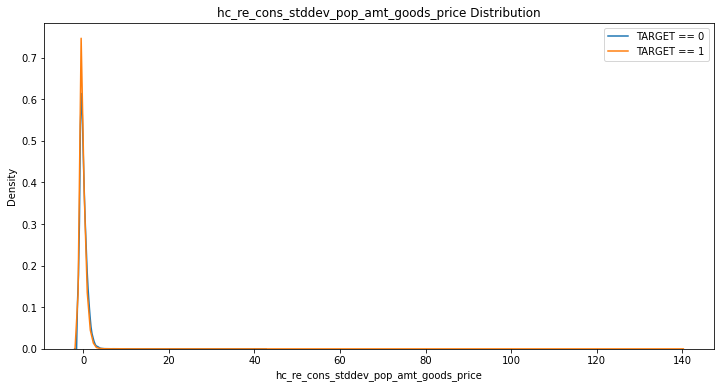

In [546]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_pop_amt_goods_price', app_train)

### hc_re_cons_var_pop_amt_goods_price

In [547]:
app_train[['TARGET', 'hc_re_cons_var_pop_amt_goods_price']].corr()

TARGET  hc_re_cons_var_pop_amt_goods_price
TARGET                              1.0000                             -0.0128
hc_re_cons_var_pop_amt_goods_price -0.0128                              1.0000

The correlation between hc_re_cons_var_pop_amt_goods_price and the TARGET is -0.0128
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


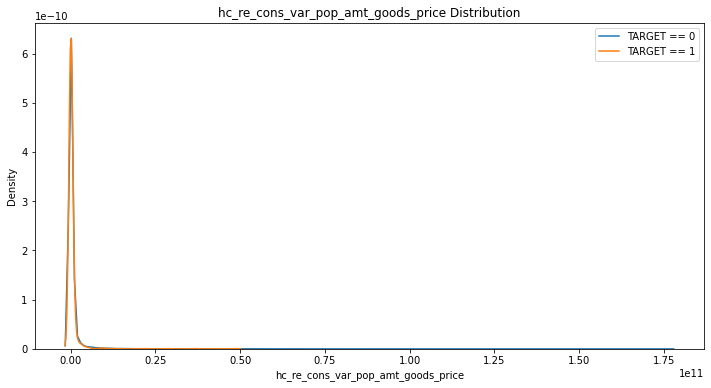

In [548]:
kde_target('hc_re_cons_var_pop_amt_goods_price', app_train)

In [549]:
app_train['hc_re_cons_var_pop_amt_goods_price'].isnull().sum()

286904

In [550]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_pop_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_pop_amt_goods_price  
0  52.715068                        8.887232e+08  
1  49.490411                        8.887232e+08  
2  54.898630                        8.887232e+08  
3  38.290411                        8.887232e+08  
4  35.726027                        8.887232e+08  

[5 rows x 92 columns]

In [551]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [552]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [553]:
app_train['hc_re_cons_var_pop_amt_goods_price'].isnull().sum()

0

In [554]:
app_train[['TARGET', 'hc_re_cons_var_pop_amt_goods_price']].corr()

TARGET  \
TARGET                              1.000000   
hc_re_cons_var_pop_amt_goods_price -0.019353   

                                    hc_re_cons_var_pop_amt_goods_price  
TARGET                                                       -0.019353  
hc_re_cons_var_pop_amt_goods_price                            1.000000

In [555]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_var_pop_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_var_pop_amt_goods_price'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_var_pop_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_var_pop_amt_goods_price']].corr()

In [556]:
## 標準化
num_cols = ['hc_re_cons_var_pop_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_pop_amt_goods_price', 'TARGET']].corr()

hc_re_cons_var_pop_amt_goods_price  \
hc_re_cons_var_pop_amt_goods_price                            1.000000   
TARGET                                                       -0.019353   

                                      TARGET  
hc_re_cons_var_pop_amt_goods_price -0.019353  
TARGET                              1.000000

The correlation between hc_re_cons_var_pop_amt_goods_price and the TARGET is -0.0194
Median value for loan that was not repaid = -0.1487
Median value for loan that was repaid =     -0.1046


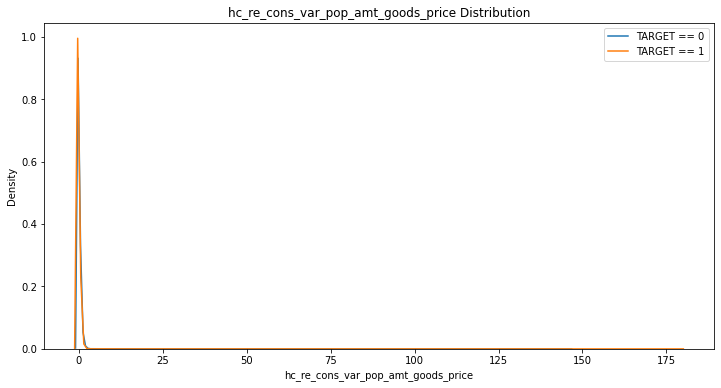

In [557]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_pop_amt_goods_price', app_train)

### hc_re_cons_var_samp_amt_goods_price

In [558]:
app_train[['TARGET', 'hc_re_cons_var_samp_amt_goods_price']].corr()

TARGET  \
TARGET                               1.00000   
hc_re_cons_var_samp_amt_goods_price -0.01287   

                                     hc_re_cons_var_samp_amt_goods_price  
TARGET                                                          -0.01287  
hc_re_cons_var_samp_amt_goods_price                              1.00000

The correlation between hc_re_cons_var_samp_amt_goods_price and the TARGET is -0.0129
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


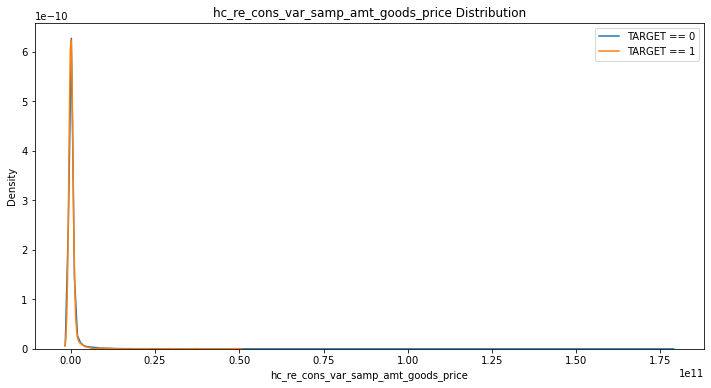

In [559]:
kde_target('hc_re_cons_var_samp_amt_goods_price', app_train)

In [560]:
app_train['hc_re_cons_var_samp_amt_goods_price'].isnull().sum()

286904

In [561]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_samp_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_samp_amt_goods_price  
0  52.715068                         8.935713e+08  
1  49.490411                         8.935713e+08  
2  54.898630                         8.935712e+08  
3  38.290411                         8.935712e+08  
4  35.726027                         8.935712e+08  

[5 rows x 92 columns]

In [562]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [563]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [564]:
app_train['hc_re_cons_var_samp_amt_goods_price'].isnull().sum()

0

In [565]:
app_train[['TARGET', 'hc_re_cons_var_samp_amt_goods_price']].corr()

TARGET  \
TARGET                               1.000000   
hc_re_cons_var_samp_amt_goods_price -0.019427   

                                     hc_re_cons_var_samp_amt_goods_price  
TARGET                                                         -0.019427  
hc_re_cons_var_samp_amt_goods_price                             1.000000

In [566]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_var_samp_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_var_samp_amt_goods_price'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_var_samp_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_var_samp_amt_goods_price']].corr()

In [567]:
## 標準化
num_cols = ['hc_re_cons_var_samp_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_samp_amt_goods_price', 'TARGET']].corr()

hc_re_cons_var_samp_amt_goods_price  \
hc_re_cons_var_samp_amt_goods_price                             1.000000   
TARGET                                                         -0.019427   

                                       TARGET  
hc_re_cons_var_samp_amt_goods_price -0.019427  
TARGET                               1.000000

The correlation between hc_re_cons_var_samp_amt_goods_price and the TARGET is -0.0194
Median value for loan that was not repaid = -0.1487
Median value for loan that was repaid =     -0.1043


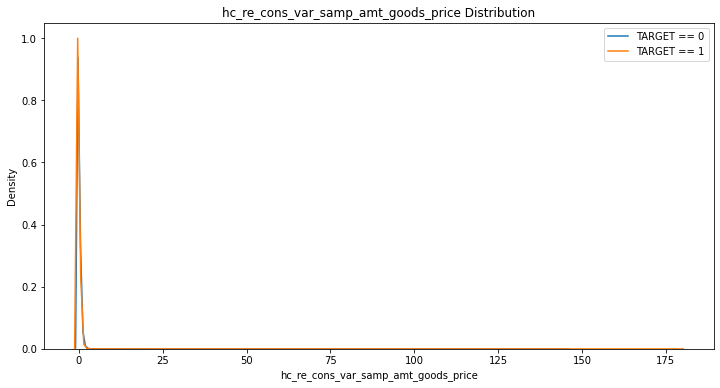

In [568]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_samp_amt_goods_price', app_train)

### hc_re_cons_variance_samp_amt_goods_price

In [569]:
app_train[['TARGET', 'hc_re_cons_variance_samp_amt_goods_price']].corr()

TARGET  \
TARGET                                    1.0000   
hc_re_cons_variance_samp_amt_goods_price -0.0128   

                                          hc_re_cons_variance_samp_amt_goods_price  
TARGET                                                                     -0.0128  
hc_re_cons_variance_samp_amt_goods_price                                    1.0000

The correlation between hc_re_cons_variance_samp_amt_goods_price and the TARGET is -0.0128
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


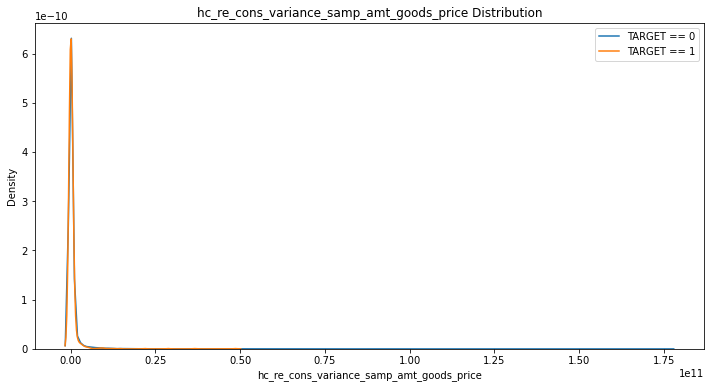

In [570]:
kde_target('hc_re_cons_variance_samp_amt_goods_price', app_train)

In [571]:
app_train['hc_re_cons_variance_samp_amt_goods_price'].isnull().sum()

286904

In [572]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_variance_samp_amt_goods_price')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_variance_samp_amt_goods_price  
0  52.715068                              8.887232e+08  
1  49.490411                              8.887232e+08  
2  54.898630                              8.887232e+08  
3  38.290411                              8.887232e+08  
4  35.726027                              8.887232e+08  

[5 rows x 92 columns]

In [573]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [574]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [575]:
app_train['hc_re_cons_variance_samp_amt_goods_price'].isnull().sum()

0

In [576]:
app_train[['TARGET', 'hc_re_cons_variance_samp_amt_goods_price']].corr()

TARGET  \
TARGET                                    1.000000   
hc_re_cons_variance_samp_amt_goods_price -0.019353   

                                          hc_re_cons_variance_samp_amt_goods_price  
TARGET                                                                   -0.019353  
hc_re_cons_variance_samp_amt_goods_price                                  1.000000

In [577]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_variance_samp_amt_goods_price']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_variance_samp_amt_goods_price'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_variance_samp_amt_goods_price'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_variance_samp_amt_goods_price']].corr()

In [578]:
## 標準化
num_cols = ['hc_re_cons_variance_samp_amt_goods_price']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_variance_samp_amt_goods_price', 'TARGET']].corr()

hc_re_cons_variance_samp_amt_goods_price  \
hc_re_cons_variance_samp_amt_goods_price                                  1.000000   
TARGET                                                                   -0.019353   

                                            TARGET  
hc_re_cons_variance_samp_amt_goods_price -0.019353  
TARGET                                    1.000000

The correlation between hc_re_cons_variance_samp_amt_goods_price and the TARGET is -0.0194
Median value for loan that was not repaid = -0.1487
Median value for loan that was repaid =     -0.1046


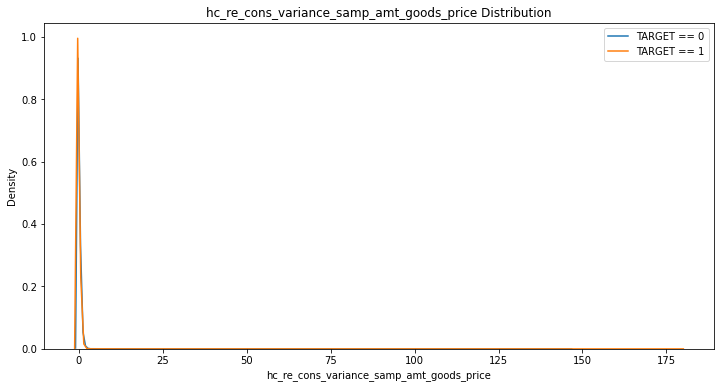

In [579]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_variance_samp_amt_goods_price', app_train)

### hc_re_cons_max_rate_down_payment

In [580]:
app_train['hc_re_cons_max_rate_down_payment'].value_counts()

0.000000    10999
0.108909     1055
0.217818      330
0.326727       49
0.544545       27
            ...  
0.101221        1
0.110875        1
0.103967        1
0.099456        1
0.097771        1
Name: hc_re_cons_max_rate_down_payment, Length: 7675, dtype: int64

In [581]:
app_train[['TARGET', 'hc_re_cons_max_rate_down_payment']].corr()

TARGET  hc_re_cons_max_rate_down_payment
TARGET                            1.00000                          -0.01686
hc_re_cons_max_rate_down_payment -0.01686                           1.00000

The correlation between hc_re_cons_max_rate_down_payment and the TARGET is -0.0169
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


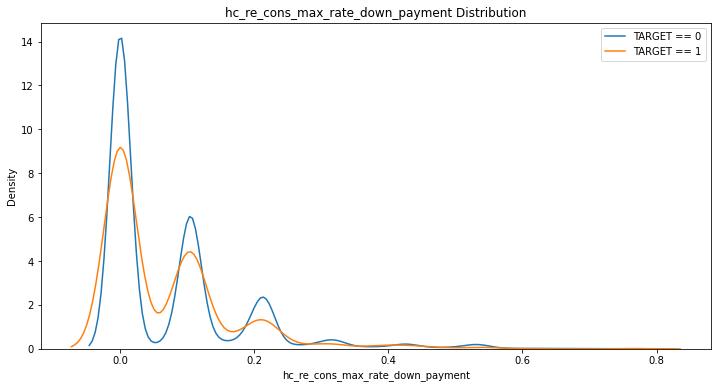

In [582]:
kde_target('hc_re_cons_max_rate_down_payment', app_train)

In [583]:
app_train['hc_re_cons_max_rate_down_payment'].isnull().sum()

286904

In [584]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_max_rate_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_max_rate_down_payment  
0  52.715068                          0.031555  
1  49.490411                          0.039406  
2  54.898630                          0.053909  
3  38.290411                          0.179505  
4  35.726027                          0.105396  

[5 rows x 92 columns]

In [585]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [586]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [587]:
app_train['hc_re_cons_max_rate_down_payment'].isnull().sum()

0

In [588]:
app_train[['TARGET', 'hc_re_cons_max_rate_down_payment']].corr()

TARGET  hc_re_cons_max_rate_down_payment
TARGET                            1.000000                         -0.017245
hc_re_cons_max_rate_down_payment -0.017245                          1.000000

In [589]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_max_rate_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_max_rate_down_payment'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_max_rate_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_max_rate_down_payment']].corr()

In [590]:
## 標準化
num_cols = ['hc_re_cons_max_rate_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_max_rate_down_payment', 'TARGET']].corr()

hc_re_cons_max_rate_down_payment    TARGET
hc_re_cons_max_rate_down_payment                          1.000000 -0.017245
TARGET                                                   -0.017245  1.000000

The correlation between hc_re_cons_max_rate_down_payment and the TARGET is -0.0172
Median value for loan that was not repaid = -0.0853
Median value for loan that was repaid =     -0.0450


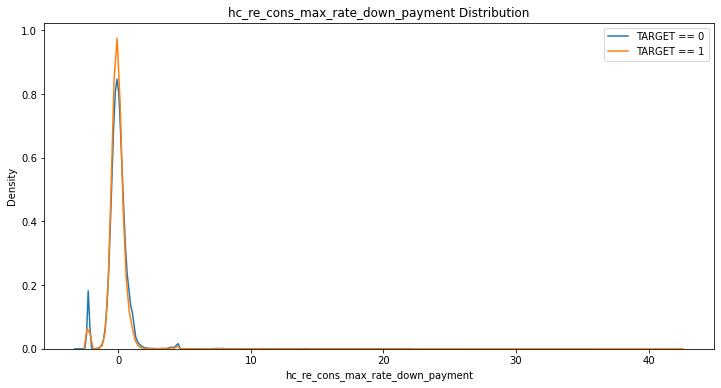

In [591]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_max_rate_down_payment', app_train)

In [592]:
#columns = ['hc_re_cons_max_rate_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_min_rate_down_payment

In [593]:
app_train['hc_re_cons_min_rate_down_payment'].value_counts()

0.000000    13910
0.108909      767
0.217818      188
0.326727       33
0.099460       15
            ...  
0.167209        1
0.108936        1
0.243626        1
0.155312        1
0.089270        1
Name: hc_re_cons_min_rate_down_payment, Length: 5447, dtype: int64

The correlation between hc_re_cons_min_rate_down_payment and the TARGET is -0.0037
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


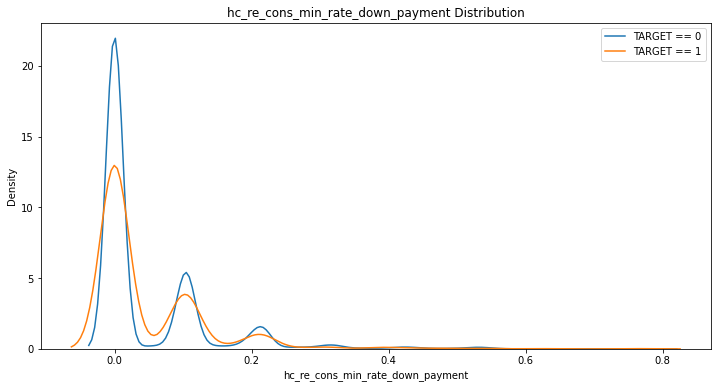

In [594]:
kde_target('hc_re_cons_min_rate_down_payment', app_train)

In [595]:
app_train['hc_re_cons_min_rate_down_payment'].isnull().sum()

286904

In [596]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_min_rate_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_min_rate_down_payment  
0  52.715068                          0.043110  
1  49.490411                          0.042659  
2  54.898630                          0.045219  
3  38.290411                          0.133752  
4  35.726027                          0.067543  

[5 rows x 92 columns]

In [597]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [598]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [599]:
app_train['hc_re_cons_min_rate_down_payment'].isnull().sum()

0

In [600]:
app_train[['TARGET', 'hc_re_cons_min_rate_down_payment']].corr()

TARGET  hc_re_cons_min_rate_down_payment
TARGET                            1.00000                          -0.02061
hc_re_cons_min_rate_down_payment -0.02061                           1.00000

In [601]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_min_rate_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_min_rate_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_min_rate_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_min_rate_down_payment']].corr()

TARGET  hc_re_cons_min_rate_down_payment
TARGET                            1.000000                         -0.021569
hc_re_cons_min_rate_down_payment -0.021569                          1.000000

In [602]:
## 標準化
num_cols = ['hc_re_cons_min_rate_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_min_rate_down_payment', 'TARGET']].corr()

hc_re_cons_min_rate_down_payment    TARGET
hc_re_cons_min_rate_down_payment                          1.000000 -0.021569
TARGET                                                   -0.021569  1.000000

The correlation between hc_re_cons_min_rate_down_payment and the TARGET is -0.0216
Median value for loan that was not repaid = 0.0444
Median value for loan that was repaid =     0.1423


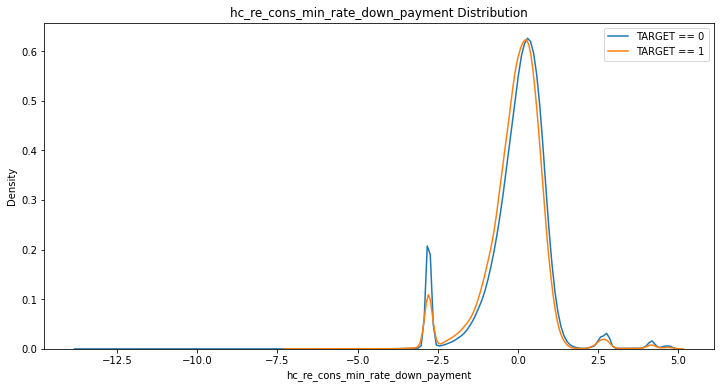

In [603]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_min_rate_down_payment', app_train)

In [604]:
#columns = ['hc_re_cons_min_rate_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_sum_rate_down_payment

In [605]:
app_train['hc_re_cons_sum_rate_down_payment'].value_counts()

0.000000     10999
4.574182        80
11.980000       60
3.267273        48
2.178182        44
             ...  
14.810846        1
0.011373         1
7.853526         1
8.204075         1
0.782168         1
Name: hc_re_cons_sum_rate_down_payment, Length: 8523, dtype: int64

The correlation between hc_re_cons_sum_rate_down_payment and the TARGET is -0.0105
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


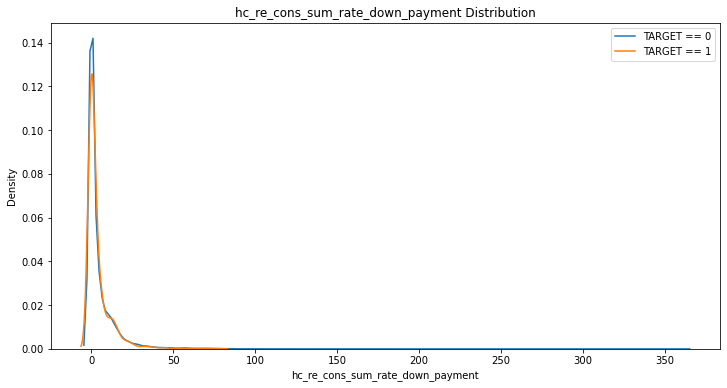

In [606]:
kde_target('hc_re_cons_sum_rate_down_payment', app_train)

In [607]:
app_train['hc_re_cons_sum_rate_down_payment'].isnull().sum()

286904

In [608]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('hc_re_cons_sum_rate_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [609]:
# 欠損値を補完した列を再結合
#app_rain[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [610]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [611]:
#app_train['hc_re_cons_sum_rate_down_payment'].isnull().sum()

In [612]:
#app_train[['TARGET', 'hc_re_cons_sum_rate_down_payment']].corr()

In [613]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_sum_rate_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_sum_rate_down_payment'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_sum_rate_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_sum_rate_down_payment']].corr()

In [614]:
## 標準化
#num_cols = ['hc_re_cons_sum_rate_down_payment']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['hc_re_cons_sum_rate_down_payment', 'TARGET']].corr()

In [615]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('hc_re_cons_sum_rate_down_payment', app_train)

In [616]:
columns = ['hc_re_cons_sum_rate_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_avg_rate_down_payment

In [617]:
app_train['hc_re_cons_avg_rate_down_payment'].value_counts()

0.000000    10999
0.108909      220
0.108909      210
0.108909      205
0.217818       71
            ...  
0.200929        1
0.098645        1
0.020873        1
0.108227        1
0.005285        1
Name: hc_re_cons_avg_rate_down_payment, Length: 8599, dtype: int64

In [618]:
app_train[['TARGET', 'hc_re_cons_cnt_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_cnt_rate_interest_primary -0.003526   

                                      hc_re_cons_cnt_rate_interest_primary  
TARGET                                                           -0.003526  
hc_re_cons_cnt_rate_interest_primary                              1.000000

The correlation between hc_re_cons_avg_rate_down_payment and the TARGET is -0.0067
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


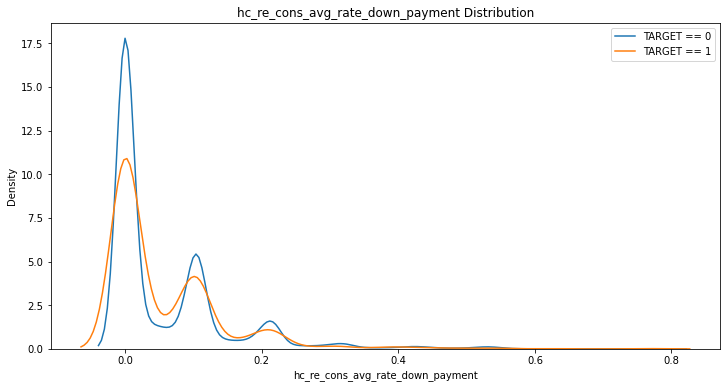

In [619]:
kde_target('hc_re_cons_avg_rate_down_payment', app_train)

In [620]:
app_train['hc_re_cons_avg_rate_down_payment'].isnull().sum()

286904

In [621]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_avg_rate_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_avg_rate_down_payment  
0  52.715068                          0.047008  
1  49.490411                          0.040739  
2  54.898630                          0.055777  
3  38.290411                          0.169089  
4  35.726027                          0.090323  

[5 rows x 92 columns]

In [622]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [623]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [624]:
app_train['hc_re_cons_avg_rate_down_payment'].isnull().sum()

0

In [625]:
app_train[['TARGET', 'hc_re_cons_avg_rate_down_payment']].corr()

TARGET  hc_re_cons_avg_rate_down_payment
TARGET                            1.000000                         -0.018816
hc_re_cons_avg_rate_down_payment -0.018816                          1.000000

In [626]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_avg_rate_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_avg_rate_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_avg_rate_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_avg_rate_down_payment']].corr()

TARGET  hc_re_cons_avg_rate_down_payment
TARGET                            1.000000                         -0.017148
hc_re_cons_avg_rate_down_payment -0.017148                          1.000000

In [627]:
## 標準化
num_cols = ['hc_re_cons_avg_rate_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_avg_rate_down_payment', 'TARGET']].corr()

hc_re_cons_avg_rate_down_payment    TARGET
hc_re_cons_avg_rate_down_payment                          1.000000 -0.017148
TARGET                                                   -0.017148  1.000000

The correlation between hc_re_cons_avg_rate_down_payment and the TARGET is -0.0171
Median value for loan that was not repaid = 0.0197
Median value for loan that was repaid =     0.0966


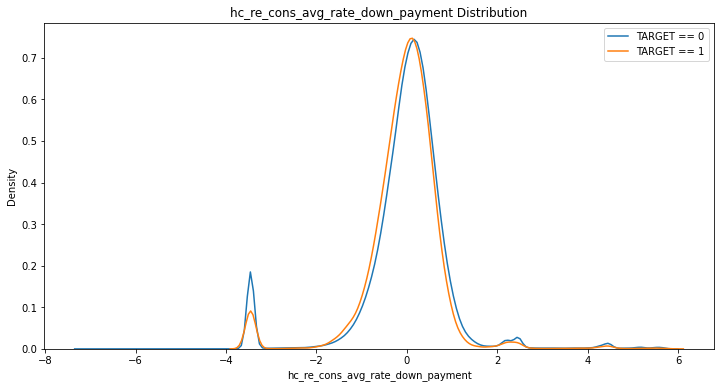

In [628]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_avg_rate_down_payment', app_train)

In [629]:
#columns = ['hc_re_cons_avg_rate_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_cnt_rate_down_payment

In [630]:
app_train['hc_re_cons_cnt_rate_down_payment'].value_counts()

42.0     1116
20.0      813
30.0      696
25.0      620
110.0     617
         ... 
838.0       1
633.0       1
849.0       1
499.0       1
872.0       1
Name: hc_re_cons_cnt_rate_down_payment, Length: 769, dtype: int64

In [631]:
app_train[['TARGET', 'hc_re_cons_cnt_rate_down_payment']].corr()

TARGET  hc_re_cons_cnt_rate_down_payment
TARGET                            1.000000                         -0.023152
hc_re_cons_cnt_rate_down_payment -0.023152                          1.000000

The correlation between hc_re_cons_cnt_rate_down_payment and the TARGET is -0.0232
Median value for loan that was not repaid = 64.0000
Median value for loan that was repaid =     81.0000


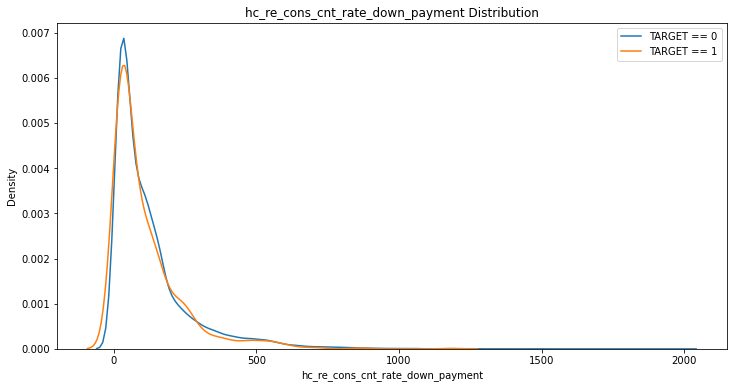

In [632]:
kde_target('hc_re_cons_cnt_rate_down_payment', app_train)

In [633]:
app_train['hc_re_cons_cnt_rate_down_payment'].isnull().sum()

286904

In [634]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_cnt_rate_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_cnt_rate_down_payment  
0  52.715068                        163.998265  
1  49.490411                        157.286037  
2  54.898630                        129.204913  
3  38.290411                         72.600350  
4  35.726027                        121.305041  

[5 rows x 92 columns]

In [635]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [636]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [637]:
app_train['hc_re_cons_cnt_rate_down_payment'].isnull().sum()

0

In [638]:
app_train[['TARGET', 'hc_re_cons_cnt_rate_down_payment']].corr()

TARGET  hc_re_cons_cnt_rate_down_payment
TARGET                            1.000000                         -0.012054
hc_re_cons_cnt_rate_down_payment -0.012054                          1.000000

In [639]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_cnt_rate_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_cnt_rate_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_cnt_rate_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_cnt_rate_down_payment']].corr()

TARGET  hc_re_cons_cnt_rate_down_payment
TARGET                            1.000000                         -0.012063
hc_re_cons_cnt_rate_down_payment -0.012063                          1.000000

In [640]:
## 標準化
num_cols = ['hc_re_cons_cnt_rate_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_cnt_rate_down_payment', 'TARGET']].corr()

hc_re_cons_cnt_rate_down_payment    TARGET
hc_re_cons_cnt_rate_down_payment                          1.000000 -0.012063
TARGET                                                   -0.012063  1.000000

The correlation between hc_re_cons_cnt_rate_down_payment and the TARGET is -0.0121
Median value for loan that was not repaid = -0.1294
Median value for loan that was repaid =     -0.0941


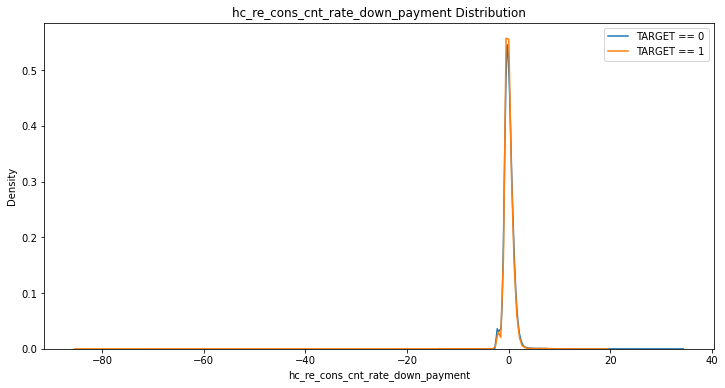

In [641]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_cnt_rate_down_payment', app_train)

In [642]:
#columns = ['hc_re_cons_cnt_rate_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_stddev_rate_down_payment

In [643]:
app_train['hc_re_cons_stddev_rate_down_payment'].value_counts()

0.000000    16748
0.054455        7
0.049200        4
0.048677        4
0.053896        4
            ...  
0.045033        1
0.040223        1
0.107504        1
0.061103        1
0.022108        1
Name: hc_re_cons_stddev_rate_down_payment, Length: 3795, dtype: int64

In [644]:
app_train[['TARGET', 'hc_re_cons_stddev_rate_down_payment']].corr()

TARGET  \
TARGET                               1.000000   
hc_re_cons_stddev_rate_down_payment -0.017855   

                                     hc_re_cons_stddev_rate_down_payment  
TARGET                                                         -0.017855  
hc_re_cons_stddev_rate_down_payment                             1.000000

The correlation between hc_re_cons_stddev_rate_down_payment and the TARGET is -0.0179
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


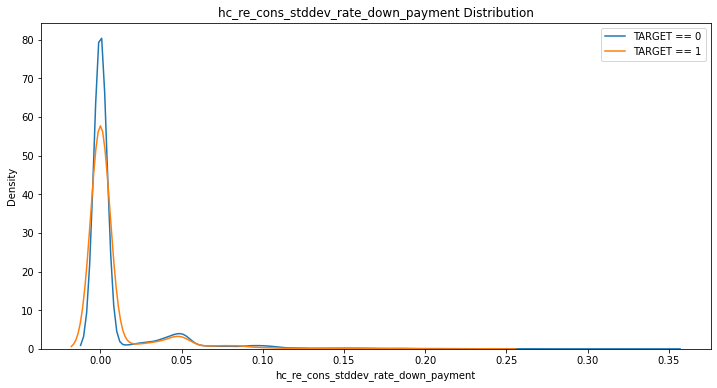

In [645]:
kde_target('hc_re_cons_stddev_rate_down_payment', app_train)

In [646]:
app_train['hc_re_cons_stddev_rate_down_payment'].isnull().sum()

286904

In [647]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_rate_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_rate_down_payment  
0  52.715068                            -0.005651  
1  49.490411                            -0.001292  
2  54.898630                             0.001160  
3  38.290411                             0.014899  
4  35.726027                             0.016116  

[5 rows x 92 columns]

In [648]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [649]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [650]:
app_train['hc_re_cons_stddev_rate_down_payment'].isnull().sum()

0

In [651]:
app_train[['TARGET', 'hc_re_cons_stddev_rate_down_payment']].corr()

TARGET  \
TARGET                               1.00000   
hc_re_cons_stddev_rate_down_payment  0.00156   

                                     hc_re_cons_stddev_rate_down_payment  
TARGET                                                           0.00156  
hc_re_cons_stddev_rate_down_payment                              1.00000

In [652]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_stddev_rate_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_stddev_rate_down_payment'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_stddev_rate_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_stddev_rate_down_payment']].corr()

In [653]:
## 標準化
num_cols = ['hc_re_cons_stddev_rate_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_rate_down_payment', 'TARGET']].corr()

hc_re_cons_stddev_rate_down_payment  \
hc_re_cons_stddev_rate_down_payment                              1.00000   
TARGET                                                           0.00156   

                                      TARGET  
hc_re_cons_stddev_rate_down_payment  0.00156  
TARGET                               1.00000

The correlation between hc_re_cons_stddev_rate_down_payment and the TARGET is 0.0016
Median value for loan that was not repaid = -0.0442
Median value for loan that was repaid =     -0.0739


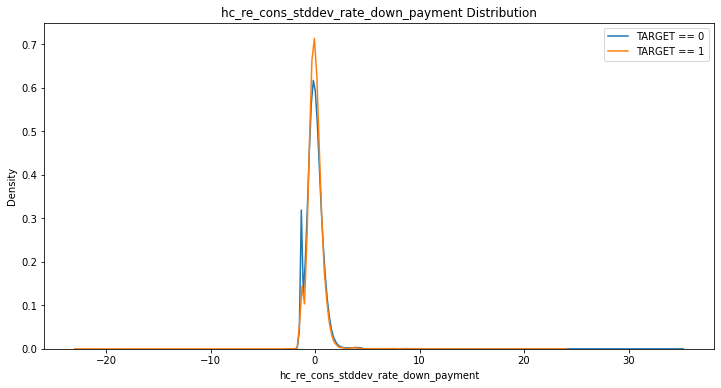

In [654]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_rate_down_payment', app_train)

In [655]:
#columns = ['hc_re_cons_stddev_rate_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_stddev_pop_rate_down_payment

In [656]:
app_train['hc_re_cons_stddev_pop_rate_down_payment'].value_counts()

0.000000    16748
0.054455        7
0.049200        4
0.048677        4
0.053896        4
            ...  
0.045033        1
0.040223        1
0.107504        1
0.061103        1
0.022108        1
Name: hc_re_cons_stddev_pop_rate_down_payment, Length: 3795, dtype: int64

In [657]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_rate_down_payment']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_stddev_pop_rate_down_payment -0.017855   

                                         hc_re_cons_stddev_pop_rate_down_payment  
TARGET                                                                 -0.017855  
hc_re_cons_stddev_pop_rate_down_payment                                 1.000000

The correlation between hc_re_cons_stddev_pop_rate_down_payment and the TARGET is -0.0179
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


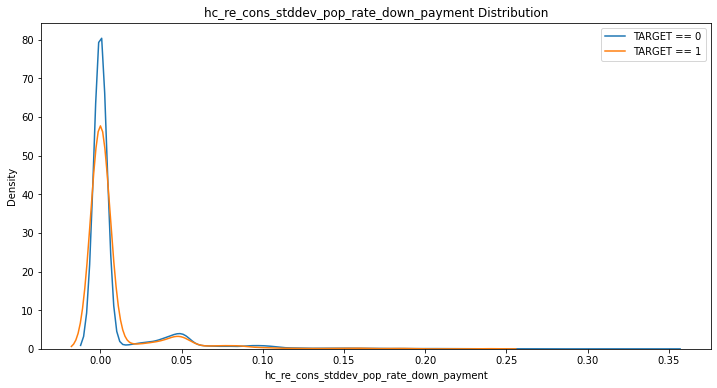

In [658]:
kde_target('hc_re_cons_stddev_pop_rate_down_payment', app_train)

In [659]:
app_train['hc_re_cons_stddev_pop_rate_down_payment'].isnull().sum()

286904

In [660]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('hc_re_cons_stddev_pop_rate_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [661]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [662]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [663]:
app_train['hc_re_cons_stddev_pop_rate_down_payment'].isnull().sum()

286904

In [664]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_rate_down_payment']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_stddev_pop_rate_down_payment -0.017855   

                                         hc_re_cons_stddev_pop_rate_down_payment  
TARGET                                                                 -0.017855  
hc_re_cons_stddev_pop_rate_down_payment                                 1.000000

In [665]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_stddev_pop_rate_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_stddev_pop_rate_down_payment'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_stddev_pop_rate_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_stddev_pop_rate_down_payment']].corr()

In [666]:
## 標準化
#num_cols = ['hc_re_cons_stddev_pop_rate_down_payment']
#scaler = StandardScaler()
#scaler.fit(app_train[num_cols])

#app_train[num_cols] = scaler.transform(app_train[num_cols])
#app_test[num_cols] = scaler.transform(app_test[num_cols])
#app_train[['hc_re_cons_stddev_pop_rate_down_payment', 'TARGET']].corr()

The correlation between hc_re_cons_stddev_pop_rate_down_payment and the TARGET is -0.0179
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


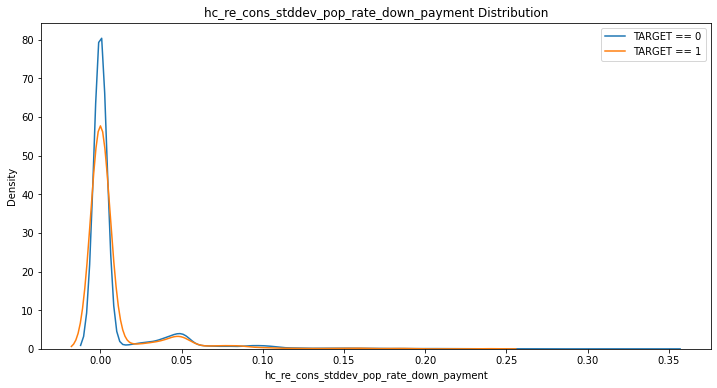

In [667]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_pop_rate_down_payment', app_train)

In [668]:
columns = ['hc_re_cons_stddev_pop_rate_down_payment']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_var_pop_rate_down_payment

In [669]:
app_train['hc_re_cons_var_pop_rate_down_payment'].value_counts()

0.000000    16748
0.002965        7
0.002636        4
0.002780        4
0.002369        4
            ...  
0.001618        1
0.011557        1
0.003734        1
0.000958        1
0.000489        1
Name: hc_re_cons_var_pop_rate_down_payment, Length: 3788, dtype: int64

In [670]:
app_train[['TARGET', 'hc_re_cons_var_pop_rate_down_payment']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_var_pop_rate_down_payment -0.015124   

                                      hc_re_cons_var_pop_rate_down_payment  
TARGET                                                           -0.015124  
hc_re_cons_var_pop_rate_down_payment                              1.000000

The correlation between hc_re_cons_var_pop_rate_down_payment and the TARGET is -0.0151
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


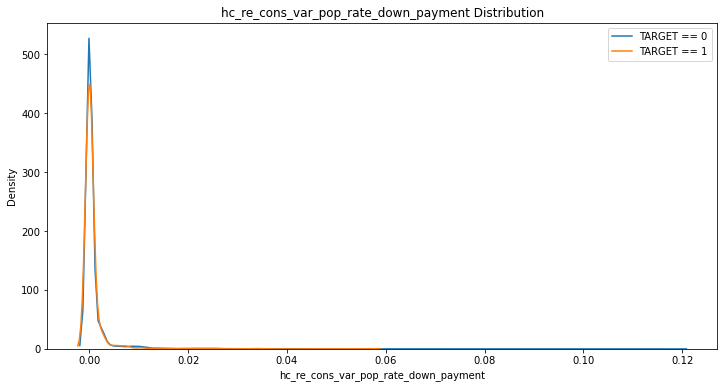

In [671]:
kde_target('hc_re_cons_var_pop_rate_down_payment', app_train)

In [672]:
app_train['hc_re_cons_var_pop_rate_down_payment'].isnull().sum()

286904

In [673]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_pop_rate_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_pop_rate_down_payment  
0  52.715068                             -0.001663  
1  49.490411                             -0.001619  
2  54.898630                             -0.000790  
3  38.290411                              0.000371  
4  35.726027                              0.002819  

[5 rows x 92 columns]

In [674]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [675]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [676]:
app_train['hc_re_cons_var_pop_rate_down_payment'].isnull().sum()

0

In [677]:
app_train[['TARGET', 'hc_re_cons_var_pop_rate_down_payment']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_var_pop_rate_down_payment -0.011097   

                                      hc_re_cons_var_pop_rate_down_payment  
TARGET                                                           -0.011097  
hc_re_cons_var_pop_rate_down_payment                              1.000000

In [678]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_var_pop_rate_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_var_pop_rate_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_var_pop_rate_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_var_pop_rate_down_payment']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_var_pop_rate_down_payment -0.013117   

                                      hc_re_cons_var_pop_rate_down_payment  
TARGET                                                           -0.013117  
hc_re_cons_var_pop_rate_down_payment                              1.000000

In [679]:
## 標準化
num_cols = ['hc_re_cons_var_pop_rate_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_pop_rate_down_payment', 'TARGET']].corr()

hc_re_cons_var_pop_rate_down_payment  \
hc_re_cons_var_pop_rate_down_payment                              1.000000   
TARGET                                                           -0.013117   

                                        TARGET  
hc_re_cons_var_pop_rate_down_payment -0.013117  
TARGET                                1.000000

The correlation between hc_re_cons_var_pop_rate_down_payment and the TARGET is -0.0131
Median value for loan that was not repaid = -0.0888
Median value for loan that was repaid =     -0.0647


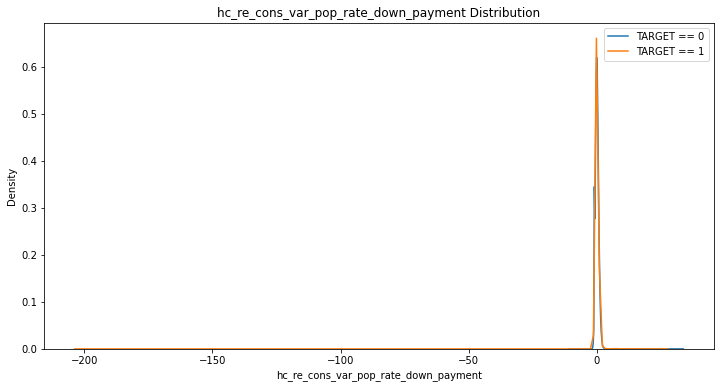

In [680]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_pop_rate_down_payment', app_train)

In [681]:
#columns = ['hc_re_cons_var_pop_rate_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_var_samp_rate_down_payment

In [682]:
app_train['hc_re_cons_var_samp_rate_down_payment'].value_counts()

0.000000    16748
0.002411        4
0.003001        3
0.001913        3
0.002924        3
            ...  
0.051552        1
0.002974        1
0.002077        1
0.001650        1
0.000492        1
Name: hc_re_cons_var_samp_rate_down_payment, Length: 3826, dtype: int64

In [683]:
app_train[['TARGET', 'hc_re_cons_var_samp_rate_down_payment']].corr()

TARGET  \
TARGET                                 1.00000   
hc_re_cons_var_samp_rate_down_payment -0.01508   

                                       hc_re_cons_var_samp_rate_down_payment  
TARGET                                                              -0.01508  
hc_re_cons_var_samp_rate_down_payment                                1.00000

The correlation between hc_re_cons_var_samp_rate_down_payment and the TARGET is -0.0151
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


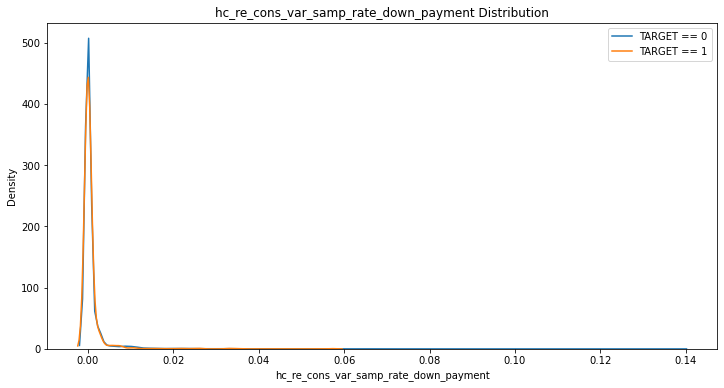

In [684]:
kde_target('hc_re_cons_var_samp_rate_down_payment', app_train)

In [685]:
app_train['hc_re_cons_var_samp_rate_down_payment'].isnull().sum()

286904

In [686]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_samp_rate_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_samp_rate_down_payment  
0  52.715068                              -0.001653  
1  49.490411                              -0.001613  
2  54.898630                              -0.000779  
3  38.290411                               0.000396  
4  35.726027                               0.002861  

[5 rows x 92 columns]

In [687]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [688]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [689]:
app_train['hc_re_cons_var_samp_rate_down_payment'].isnull().sum()

0

In [690]:
app_train[['TARGET', 'hc_re_cons_var_samp_rate_down_payment']].corr()

TARGET  \
TARGET                                 1.000000   
hc_re_cons_var_samp_rate_down_payment -0.010644   

                                       hc_re_cons_var_samp_rate_down_payment  
TARGET                                                             -0.010644  
hc_re_cons_var_samp_rate_down_payment                               1.000000

In [691]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_var_samp_rate_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_var_samp_rate_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_var_samp_rate_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_var_samp_rate_down_payment']].corr()

TARGET  \
TARGET                                 1.000000   
hc_re_cons_var_samp_rate_down_payment -0.012645   

                                       hc_re_cons_var_samp_rate_down_payment  
TARGET                                                             -0.012645  
hc_re_cons_var_samp_rate_down_payment                               1.000000

In [692]:
## 標準化
num_cols = ['hc_re_cons_var_samp_rate_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_samp_rate_down_payment', 'TARGET']].corr()

hc_re_cons_var_samp_rate_down_payment  \
hc_re_cons_var_samp_rate_down_payment                               1.000000   
TARGET                                                             -0.012645   

                                         TARGET  
hc_re_cons_var_samp_rate_down_payment -0.012645  
TARGET                                 1.000000

The correlation between hc_re_cons_var_samp_rate_down_payment and the TARGET is -0.0126
Median value for loan that was not repaid = -0.0867
Median value for loan that was repaid =     -0.0639


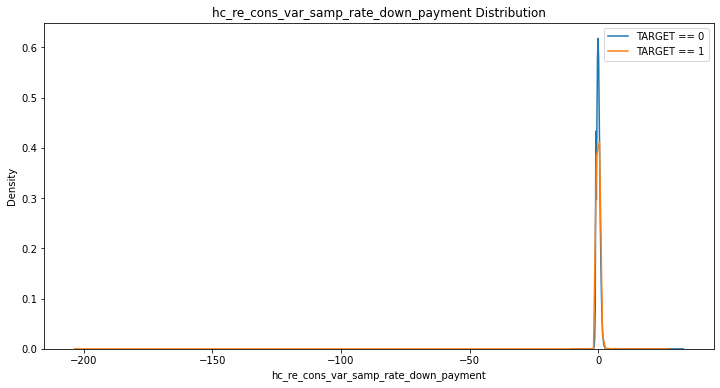

In [693]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_samp_rate_down_payment', app_train)

In [694]:
#columns = ['hc_re_cons_var_samp_rate_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_variance_samp_rate_down_payment

In [695]:
app_train['hc_re_cons_variance_samp_rate_down_payment'].value_counts()

0.000000    16748
0.002965        7
0.002636        4
0.002780        4
0.002369        4
            ...  
0.001618        1
0.011557        1
0.003734        1
0.000958        1
0.000489        1
Name: hc_re_cons_variance_samp_rate_down_payment, Length: 3788, dtype: int64

In [696]:
app_train[['TARGET', 'hc_re_cons_variance_samp_rate_down_payment']].corr()

TARGET  \
TARGET                                      1.000000   
hc_re_cons_variance_samp_rate_down_payment -0.015124   

                                            hc_re_cons_variance_samp_rate_down_payment  
TARGET                                                                       -0.015124  
hc_re_cons_variance_samp_rate_down_payment                                    1.000000

The correlation between hc_re_cons_variance_samp_rate_down_payment and the TARGET is -0.0151
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


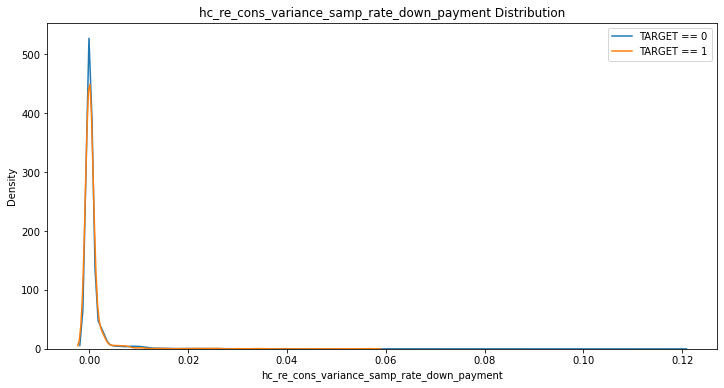

In [697]:
kde_target('hc_re_cons_variance_samp_rate_down_payment', app_train)

In [698]:
app_train['hc_re_cons_variance_samp_rate_down_payment'].isnull().sum()

286904

In [699]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_variance_samp_rate_down_payment')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_variance_samp_rate_down_payment  
0  52.715068                                   -0.001663  
1  49.490411                                   -0.001619  
2  54.898630                                   -0.000790  
3  38.290411                                    0.000371  
4  35.726027                                    0.002819  

[5 rows x 92 columns]

In [700]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [701]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [702]:
app_train['hc_re_cons_variance_samp_rate_down_payment'].isnull().sum()

0

In [703]:
app_train[['TARGET', 'hc_re_cons_variance_samp_rate_down_payment']].corr()

TARGET  \
TARGET                                      1.000000   
hc_re_cons_variance_samp_rate_down_payment -0.011097   

                                            hc_re_cons_variance_samp_rate_down_payment  
TARGET                                                                       -0.011097  
hc_re_cons_variance_samp_rate_down_payment                                    1.000000

In [704]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_variance_samp_rate_down_payment']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_variance_samp_rate_down_payment'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_variance_samp_rate_down_payment'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_variance_samp_rate_down_payment']].corr()

TARGET  \
TARGET                                      1.000000   
hc_re_cons_variance_samp_rate_down_payment -0.013117   

                                            hc_re_cons_variance_samp_rate_down_payment  
TARGET                                                                       -0.013117  
hc_re_cons_variance_samp_rate_down_payment                                    1.000000

In [705]:
## 標準化
num_cols = ['hc_re_cons_variance_samp_rate_down_payment']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_variance_samp_rate_down_payment', 'TARGET']].corr()

hc_re_cons_variance_samp_rate_down_payment  \
hc_re_cons_variance_samp_rate_down_payment                                    1.000000   
TARGET                                                                       -0.013117   

                                              TARGET  
hc_re_cons_variance_samp_rate_down_payment -0.013117  
TARGET                                      1.000000

The correlation between hc_re_cons_variance_samp_rate_down_payment and the TARGET is -0.0131
Median value for loan that was not repaid = -0.0888
Median value for loan that was repaid =     -0.0647


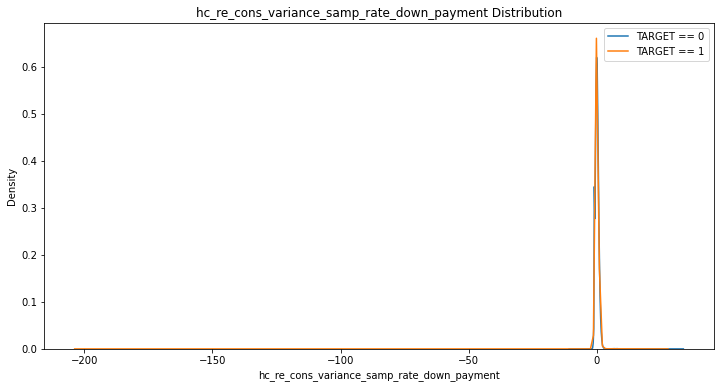

In [706]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_variance_samp_rate_down_payment', app_train)

In [707]:
#columns = ['hc_re_cons_variance_samp_rate_down_payment']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_max_rate_interest_primary

In [708]:
#app_train['hc_re_cons_max_rate_interest_primary'].value_counts()

In [709]:
app_train[['TARGET', 'hc_re_cons_max_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_max_rate_interest_primary -0.010572   

                                      hc_re_cons_max_rate_interest_primary  
TARGET                                                           -0.010572  
hc_re_cons_max_rate_interest_primary                              1.000000

The correlation between hc_re_cons_max_rate_interest_primary and the TARGET is -0.0106
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


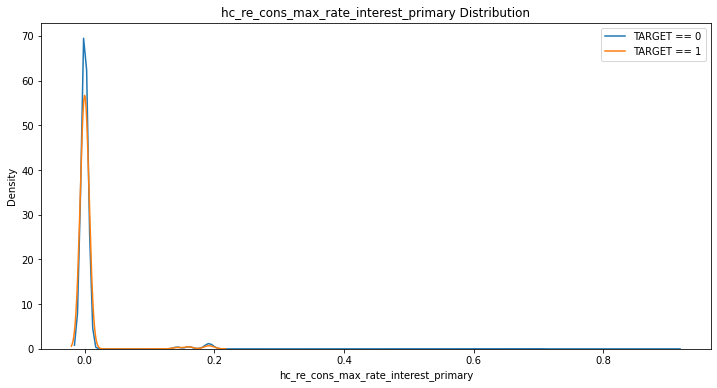

In [710]:
kde_target('hc_re_cons_max_rate_interest_primary', app_train)

In [711]:
app_train['hc_re_cons_max_rate_interest_primary'].isnull().sum()

286904

In [712]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_max_rate_interest_primary')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_max_rate_interest_primary  
0  52.715068                              0.005025  
1  49.490411                              0.004238  
2  54.898630                              0.008801  
3  38.290411                              0.039349  
4  35.726027                              0.015185  

[5 rows x 92 columns]

In [713]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [714]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [715]:
app_train['hc_re_cons_max_rate_interest_primary'].isnull().sum()

0

In [716]:
app_train[['TARGET', 'hc_re_cons_max_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_max_rate_interest_primary  0.001379   

                                      hc_re_cons_max_rate_interest_primary  
TARGET                                                            0.001379  
hc_re_cons_max_rate_interest_primary                              1.000000

In [717]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_max_rate_interest_primary']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_max_rate_interest_primary'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_max_rate_interest_primary'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_max_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_max_rate_interest_primary  0.021926   

                                      hc_re_cons_max_rate_interest_primary  
TARGET                                                            0.021926  
hc_re_cons_max_rate_interest_primary                              1.000000

In [718]:
## 標準化
num_cols = ['hc_re_cons_max_rate_interest_primary']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_max_rate_interest_primary', 'TARGET']].corr()

hc_re_cons_max_rate_interest_primary  \
hc_re_cons_max_rate_interest_primary                              1.000000   
TARGET                                                            0.021926   

                                        TARGET  
hc_re_cons_max_rate_interest_primary  0.021926  
TARGET                                1.000000

The correlation between hc_re_cons_max_rate_interest_primary and the TARGET is 0.0219
Median value for loan that was not repaid = 0.1594
Median value for loan that was repaid =     0.0607


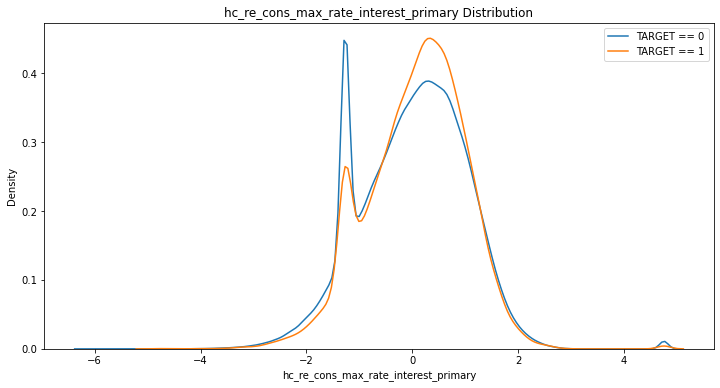

In [719]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_max_rate_interest_primary', app_train)

In [720]:
#columns = ['hc_re_cons_max_rate_interest_primary']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_min_rate_interest_primary

In [721]:
#app_train['hc_re_cons_min_rate_interest_primary'].value_counts()

In [722]:
app_train[['TARGET', 'hc_re_cons_min_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_min_rate_interest_primary -0.010605   

                                      hc_re_cons_min_rate_interest_primary  
TARGET                                                           -0.010605  
hc_re_cons_min_rate_interest_primary                              1.000000

The correlation between hc_re_cons_min_rate_interest_primary and the TARGET is -0.0106
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


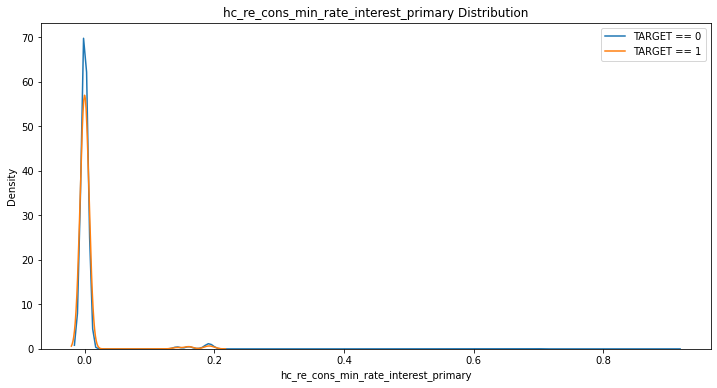

In [723]:
kde_target('hc_re_cons_min_rate_interest_primary', app_train)

In [724]:
app_train['hc_re_cons_min_rate_interest_primary'].isnull().sum()

286904

In [725]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_min_rate_interest_primary')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_min_rate_interest_primary  
0  52.715068                              0.004715  
1  49.490411                              0.003406  
2  54.898630                              0.008285  
3  38.290411                              0.038457  
4  35.726027                              0.014413  

[5 rows x 92 columns]

In [726]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [727]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [728]:
app_train['hc_re_cons_min_rate_interest_primary'].isnull().sum()

0

In [729]:
app_train[['TARGET', 'hc_re_cons_min_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_min_rate_interest_primary  0.001411   

                                      hc_re_cons_min_rate_interest_primary  
TARGET                                                            0.001411  
hc_re_cons_min_rate_interest_primary                              1.000000

In [730]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_min_rate_interest_primary']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_min_rate_interest_primary'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_min_rate_interest_primary'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_min_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_min_rate_interest_primary  0.022084   

                                      hc_re_cons_min_rate_interest_primary  
TARGET                                                            0.022084  
hc_re_cons_min_rate_interest_primary                              1.000000

In [731]:
## 標準化
num_cols = ['hc_re_cons_min_rate_interest_primary']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_min_rate_interest_primary', 'TARGET']].corr()

hc_re_cons_min_rate_interest_primary  \
hc_re_cons_min_rate_interest_primary                              1.000000   
TARGET                                                            0.022084   

                                        TARGET  
hc_re_cons_min_rate_interest_primary  0.022084  
TARGET                                1.000000

The correlation between hc_re_cons_min_rate_interest_primary and the TARGET is 0.0221
Median value for loan that was not repaid = 0.1620
Median value for loan that was repaid =     0.0607


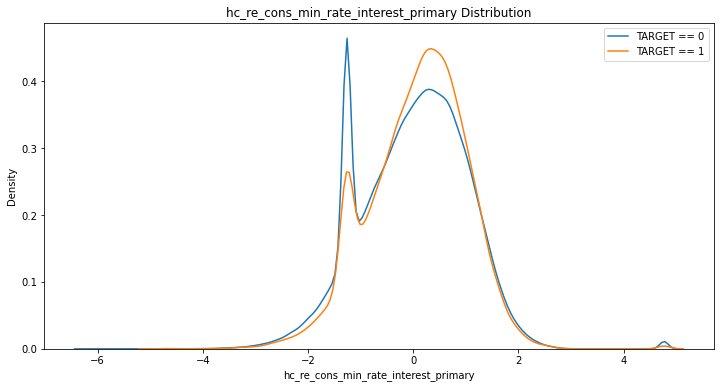

In [732]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_min_rate_interest_primary', app_train)

In [733]:
#columns = ['hc_re_cons_min_rate_interest_primary']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_sum_rate_interest_primary

In [734]:
#app_train['hc_re_cons_sum_rate_interest_primary'].value_counts()

In [735]:
app_train[['TARGET', 'hc_re_cons_sum_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_sum_rate_interest_primary -0.005757   

                                      hc_re_cons_sum_rate_interest_primary  
TARGET                                                           -0.005757  
hc_re_cons_sum_rate_interest_primary                              1.000000

The correlation between hc_re_cons_sum_rate_interest_primary and the TARGET is -0.0058
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


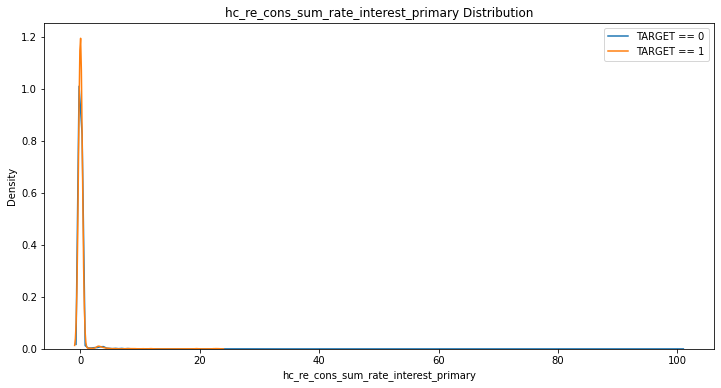

In [736]:
kde_target('hc_re_cons_sum_rate_interest_primary', app_train)

In [737]:
app_train['hc_re_cons_sum_rate_interest_primary'].isnull().sum()

286904

In [738]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_sum_rate_interest_primary')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_sum_rate_interest_primary  
0  52.715068                              0.275073  
1  49.490411                              0.161598  
2  54.898630                              0.235116  
3  38.290411                              0.703088  
4  35.726027                              0.283624  

[5 rows x 92 columns]

In [739]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [740]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [741]:
app_train['hc_re_cons_sum_rate_interest_primary'].isnull().sum()

0

In [742]:
app_train[['TARGET', 'hc_re_cons_sum_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_sum_rate_interest_primary  0.008474   

                                      hc_re_cons_sum_rate_interest_primary  
TARGET                                                            0.008474  
hc_re_cons_sum_rate_interest_primary                              1.000000

In [743]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_sum_rate_interest_primary']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_sum_rate_interest_primary'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_sum_rate_interest_primary'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_sum_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_sum_rate_interest_primary  0.046207   

                                      hc_re_cons_sum_rate_interest_primary  
TARGET                                                            0.046207  
hc_re_cons_sum_rate_interest_primary                              1.000000

In [744]:
## 標準化
num_cols = ['hc_re_cons_sum_rate_interest_primary']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_sum_rate_interest_primary', 'TARGET']].corr()

hc_re_cons_sum_rate_interest_primary  \
hc_re_cons_sum_rate_interest_primary                              1.000000   
TARGET                                                            0.046207   

                                        TARGET  
hc_re_cons_sum_rate_interest_primary  0.046207  
TARGET                                1.000000

The correlation between hc_re_cons_sum_rate_interest_primary and the TARGET is 0.0462
Median value for loan that was not repaid = 0.2897
Median value for loan that was repaid =     0.1314


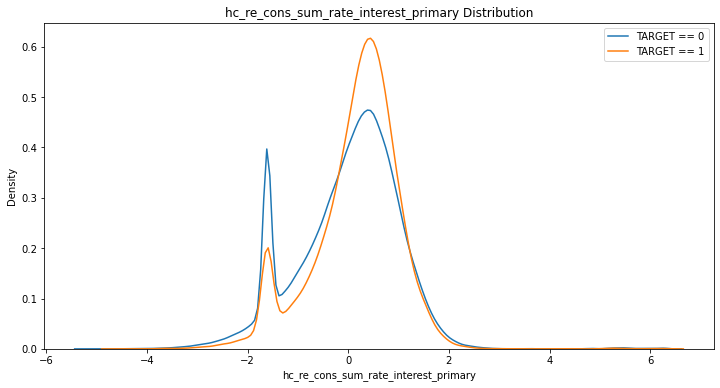

In [745]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_sum_rate_interest_primary', app_train)

In [746]:
#columns = ['hc_re_cons_sum_rate_interest_primary']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_avg_rate_interest_primary

In [747]:
#app_train['hc_re_cons_avg_rate_interest_primary'].value_counts()

In [748]:
app_train[['TARGET', 'hc_re_cons_avg_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_avg_rate_interest_primary -0.010578   

                                      hc_re_cons_avg_rate_interest_primary  
TARGET                                                           -0.010578  
hc_re_cons_avg_rate_interest_primary                              1.000000

The correlation between hc_re_cons_avg_rate_interest_primary and the TARGET is -0.0106
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


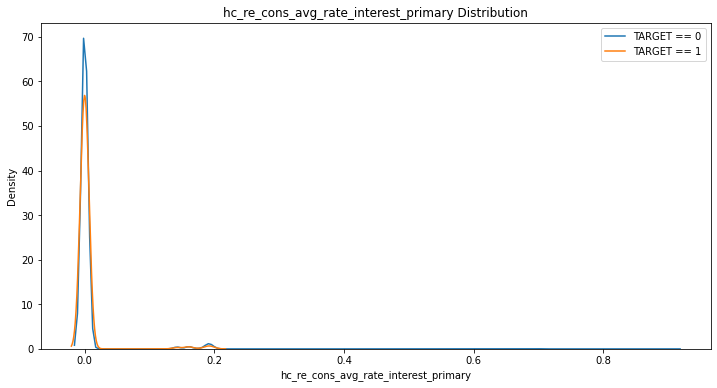

In [749]:
kde_target('hc_re_cons_avg_rate_interest_primary', app_train)

In [750]:
app_train['hc_re_cons_avg_rate_interest_primary'].isnull().sum()

286904

In [751]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_avg_rate_interest_primary')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_avg_rate_interest_primary  
0  52.715068                              0.004868  
1  49.490411                              0.003820  
2  54.898630                              0.008543  
3  38.290411                              0.038903  
4  35.726027                              0.014802  

[5 rows x 92 columns]

In [752]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [753]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [754]:
app_train['hc_re_cons_avg_rate_interest_primary'].isnull().sum()

0

In [755]:
app_train[['TARGET', 'hc_re_cons_avg_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_avg_rate_interest_primary  0.001435   

                                      hc_re_cons_avg_rate_interest_primary  
TARGET                                                            0.001435  
hc_re_cons_avg_rate_interest_primary                              1.000000

In [756]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_avg_rate_interest_primary']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_avg_rate_interest_primary'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_avg_rate_interest_primary'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_avg_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_avg_rate_interest_primary  0.022114   

                                      hc_re_cons_avg_rate_interest_primary  
TARGET                                                            0.022114  
hc_re_cons_avg_rate_interest_primary                              1.000000

In [757]:
## 標準化
num_cols = ['hc_re_cons_avg_rate_interest_primary']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_avg_rate_interest_primary', 'TARGET']].corr()

hc_re_cons_avg_rate_interest_primary  \
hc_re_cons_avg_rate_interest_primary                              1.000000   
TARGET                                                            0.022114   

                                        TARGET  
hc_re_cons_avg_rate_interest_primary  0.022114  
TARGET                                1.000000

The correlation between hc_re_cons_avg_rate_interest_primary and the TARGET is 0.0221
Median value for loan that was not repaid = 0.1618
Median value for loan that was repaid =     0.0605


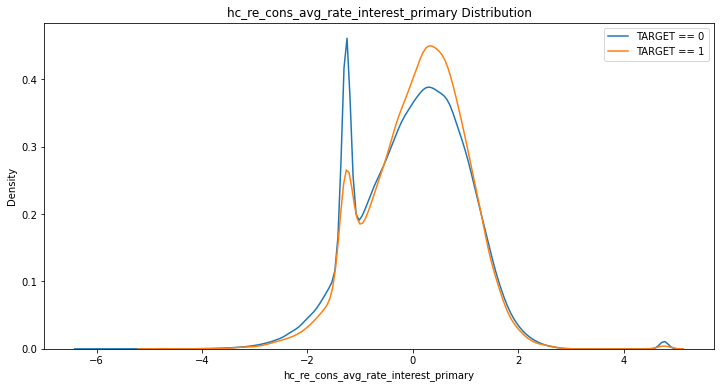

In [758]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_avg_rate_interest_primary', app_train)

In [759]:
#columns = ['hc_re_cons_avg_rate_interest_primary']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_cnt_rate_interest_primary

In [760]:
#app_train['hc_re_cons_cnt_rate_interest_primary'].value_counts()

In [761]:
app_train[['TARGET', 'hc_re_cons_cnt_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_cnt_rate_interest_primary -0.003526   

                                      hc_re_cons_cnt_rate_interest_primary  
TARGET                                                           -0.003526  
hc_re_cons_cnt_rate_interest_primary                              1.000000

The correlation between hc_re_cons_cnt_rate_interest_primary and the TARGET is -0.0035
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


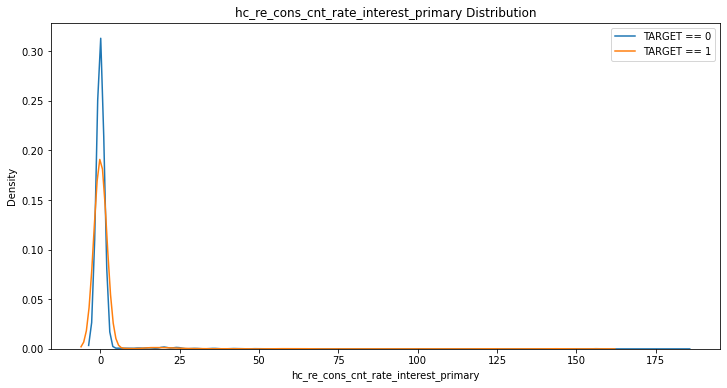

In [762]:
kde_target('hc_re_cons_cnt_rate_interest_primary', app_train)

In [763]:
app_train['hc_re_cons_cnt_rate_interest_primary'].isnull().sum()

286904

In [764]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_cnt_rate_interest_primary')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_cnt_rate_interest_primary  
0  52.715068                              1.506796  
1  49.490411                              0.906887  
2  54.898630                              1.379729  
3  38.290411                              3.588640  
4  35.726027                              1.600152  

[5 rows x 92 columns]

In [765]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [766]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [767]:
app_train['hc_re_cons_cnt_rate_interest_primary'].isnull().sum()

0

In [768]:
app_train[['TARGET', 'hc_re_cons_cnt_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_cnt_rate_interest_primary  0.015177   

                                      hc_re_cons_cnt_rate_interest_primary  
TARGET                                                            0.015177  
hc_re_cons_cnt_rate_interest_primary                              1.000000

In [769]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_cnt_rate_interest_primary']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_cnt_rate_interest_primary'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_cnt_rate_interest_primary'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_cnt_rate_interest_primary']].corr()

TARGET  \
TARGET                                1.000000   
hc_re_cons_cnt_rate_interest_primary  0.067416   

                                      hc_re_cons_cnt_rate_interest_primary  
TARGET                                                            0.067416  
hc_re_cons_cnt_rate_interest_primary                              1.000000

In [770]:
## 標準化
num_cols = ['hc_re_cons_cnt_rate_interest_primary']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_cnt_rate_interest_primary', 'TARGET']].corr()

hc_re_cons_cnt_rate_interest_primary  \
hc_re_cons_cnt_rate_interest_primary                              1.000000   
TARGET                                                            0.067416   

                                        TARGET  
hc_re_cons_cnt_rate_interest_primary  0.067416  
TARGET                                1.000000

The correlation between hc_re_cons_cnt_rate_interest_primary and the TARGET is 0.0674
Median value for loan that was not repaid = 0.4087
Median value for loan that was repaid =     0.1684


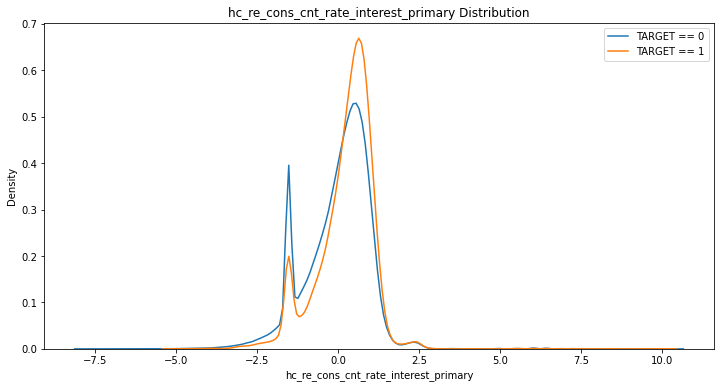

In [771]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_cnt_rate_interest_primary', app_train)

In [772]:
#columns = ['hc_re_cons_cnt_rate_interest_primary']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_stddev_rate_interest_primary

In [773]:
#app_train['hc_re_cons_stddev_rate_interest_primary'].value_counts()

In [774]:
app_train[['TARGET', 'hc_re_cons_stddev_rate_interest_primary']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_stddev_rate_interest_primary  0.000825   

                                         hc_re_cons_stddev_rate_interest_primary  
TARGET                                                                  0.000825  
hc_re_cons_stddev_rate_interest_primary                                 1.000000

The correlation between hc_re_cons_stddev_rate_interest_primary and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


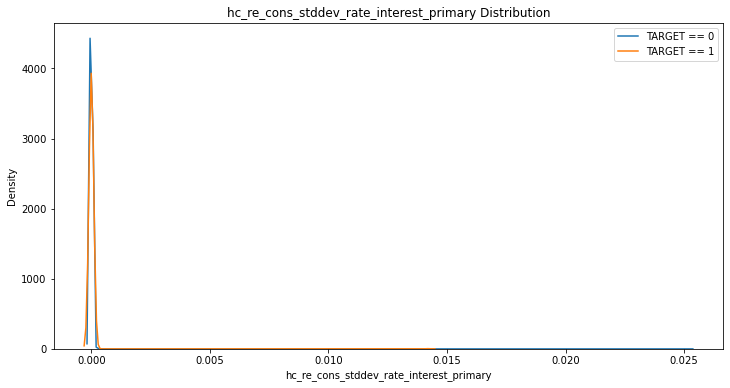

In [775]:
kde_target('hc_re_cons_stddev_rate_interest_primary', app_train)

In [776]:
app_train['hc_re_cons_stddev_rate_interest_primary'].isnull().sum()

286904

In [777]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_rate_interest_primary')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_rate_interest_primary  
0  52.715068                                 0.000021  
1  49.490411                                 0.000499  
2  54.898630                                 0.000491  
3  38.290411                                 0.000130  
4  35.726027                                 0.000722  

[5 rows x 92 columns]

In [778]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [779]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [780]:
app_train['hc_re_cons_stddev_rate_interest_primary'].isnull().sum()

0

In [781]:
app_train[['TARGET', 'hc_re_cons_stddev_rate_interest_primary']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_stddev_rate_interest_primary  0.003685   

                                         hc_re_cons_stddev_rate_interest_primary  
TARGET                                                                  0.003685  
hc_re_cons_stddev_rate_interest_primary                                 1.000000

In [782]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_stddev_rate_interest_primary']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_stddev_rate_interest_primary'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_stddev_rate_interest_primary'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_stddev_rate_interest_primary']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_stddev_rate_interest_primary  0.013467   

                                         hc_re_cons_stddev_rate_interest_primary  
TARGET                                                                  0.013467  
hc_re_cons_stddev_rate_interest_primary                                 1.000000

In [783]:
## 標準化
num_cols = ['hc_re_cons_stddev_rate_interest_primary']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_rate_interest_primary', 'TARGET']].corr()

hc_re_cons_stddev_rate_interest_primary  \
hc_re_cons_stddev_rate_interest_primary                                 1.000000   
TARGET                                                                  0.013467   

                                           TARGET  
hc_re_cons_stddev_rate_interest_primary  0.013467  
TARGET                                   1.000000

The correlation between hc_re_cons_stddev_rate_interest_primary and the TARGET is 0.0135
Median value for loan that was not repaid = 0.0714
Median value for loan that was repaid =     0.0398


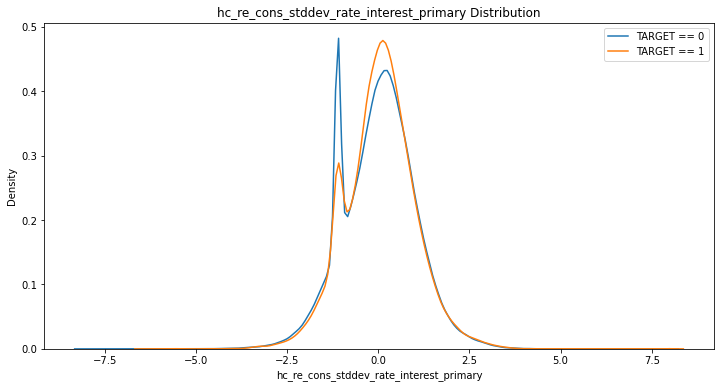

In [784]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_rate_interest_primary', app_train)

In [785]:
#columns = ['hc_re_cons_stddev_rate_interest_primary']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_stddev_pop_rate_interest_primary

In [786]:
#app_train['hc_re_cons_stddev_pop_rate_interest_primary'].value_counts()

In [787]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_rate_interest_primary']].corr()

TARGET  \
TARGET                                       1.000000   
hc_re_cons_stddev_pop_rate_interest_primary  0.000825   

                                             hc_re_cons_stddev_pop_rate_interest_primary  
TARGET                                                                          0.000825  
hc_re_cons_stddev_pop_rate_interest_primary                                     1.000000

The correlation between hc_re_cons_stddev_pop_rate_interest_primary and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


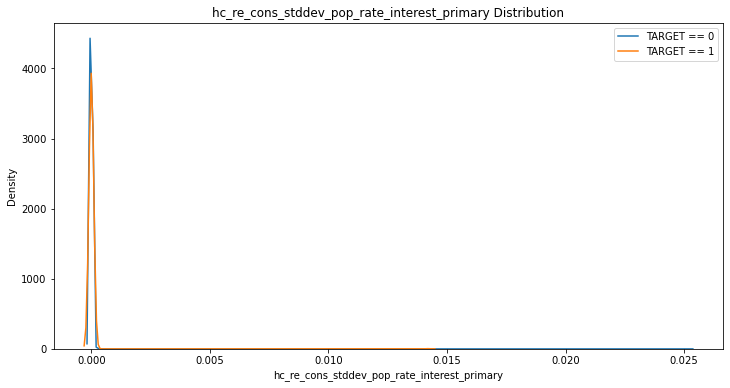

In [788]:
kde_target('hc_re_cons_stddev_pop_rate_interest_primary', app_train)

In [789]:
app_train['hc_re_cons_stddev_pop_rate_interest_primary'].isnull().sum()

286904

In [790]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_pop_rate_interest_primary')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_pop_rate_interest_primary  
0  52.715068                                     0.000021  
1  49.490411                                     0.000499  
2  54.898630                                     0.000491  
3  38.290411                                     0.000130  
4  35.726027                                     0.000722  

[5 rows x 92 columns]

In [791]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [792]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [793]:
app_train['hc_re_cons_stddev_pop_rate_interest_primary'].isnull().sum()

0

In [794]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_rate_interest_primary']].corr()

TARGET  \
TARGET                                       1.000000   
hc_re_cons_stddev_pop_rate_interest_primary  0.003685   

                                             hc_re_cons_stddev_pop_rate_interest_primary  
TARGET                                                                          0.003685  
hc_re_cons_stddev_pop_rate_interest_primary                                     1.000000

In [795]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_stddev_pop_rate_interest_primary']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_stddev_pop_rate_interest_primary'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_stddev_pop_rate_interest_primary'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_stddev_pop_rate_interest_primary']].corr()

TARGET  \
TARGET                                       1.000000   
hc_re_cons_stddev_pop_rate_interest_primary  0.013467   

                                             hc_re_cons_stddev_pop_rate_interest_primary  
TARGET                                                                          0.013467  
hc_re_cons_stddev_pop_rate_interest_primary                                     1.000000

In [796]:
## 標準化
num_cols = ['hc_re_cons_stddev_pop_rate_interest_primary']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_pop_rate_interest_primary', 'TARGET']].corr()

hc_re_cons_stddev_pop_rate_interest_primary  \
hc_re_cons_stddev_pop_rate_interest_primary                                     1.000000   
TARGET                                                                          0.013467   

                                               TARGET  
hc_re_cons_stddev_pop_rate_interest_primary  0.013467  
TARGET                                       1.000000

The correlation between hc_re_cons_stddev_pop_rate_interest_primary and the TARGET is 0.0135
Median value for loan that was not repaid = 0.0714
Median value for loan that was repaid =     0.0398


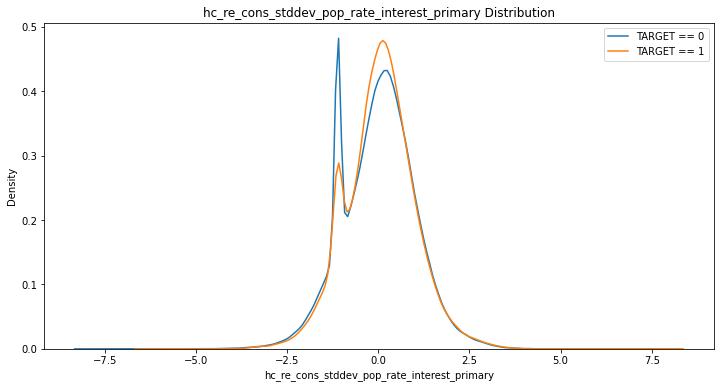

In [797]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_pop_rate_interest_primary', app_train)

In [798]:
#columns = ['hc_re_cons_stddev_pop_rate_interest_primary']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_var_pop_rate_interest_primary

In [799]:
#app_train['hc_re_cons_var_pop_rate_interest_primary'].value_counts()

In [800]:
app_train[['TARGET', 'hc_re_cons_var_pop_rate_interest_primary']].corr()

TARGET  \
TARGET                                    1.00000   
hc_re_cons_var_pop_rate_interest_primary -0.00049   

                                          hc_re_cons_var_pop_rate_interest_primary  
TARGET                                                                    -0.00049  
hc_re_cons_var_pop_rate_interest_primary                                   1.00000

The correlation between hc_re_cons_var_pop_rate_interest_primary and the TARGET is -0.0005
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


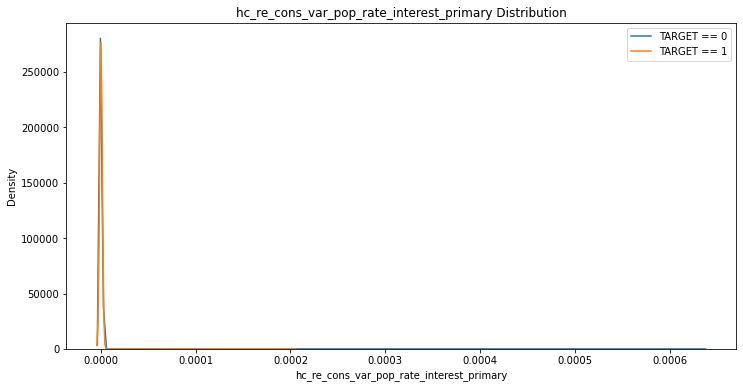

In [801]:
kde_target('hc_re_cons_var_pop_rate_interest_primary', app_train)

In [802]:
app_train['hc_re_cons_var_pop_rate_interest_primary'].isnull().sum()

286904

In [803]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_pop_rate_interest_primary')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_pop_rate_interest_primary  
0  52.715068                                 -0.000002  
1  49.490411                                  0.000018  
2  54.898630                                  0.000008  
3  38.290411                                 -0.000015  
4  35.726027                                  0.000012  

[5 rows x 92 columns]

In [804]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [805]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [806]:
app_train['hc_re_cons_var_pop_rate_interest_primary'].isnull().sum()

0

In [807]:
app_train[['TARGET', 'hc_re_cons_var_pop_rate_interest_primary']].corr()

TARGET  \
TARGET                                    1.000000   
hc_re_cons_var_pop_rate_interest_primary  0.004759   

                                          hc_re_cons_var_pop_rate_interest_primary  
TARGET                                                                    0.004759  
hc_re_cons_var_pop_rate_interest_primary                                  1.000000

In [808]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_var_pop_rate_interest_primary']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_var_pop_rate_interest_primary'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_var_pop_rate_interest_primary'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関

In [809]:
## 標準化
num_cols = ['hc_re_cons_var_pop_rate_interest_primary']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_pop_rate_interest_primary', 'TARGET']].corr()

hc_re_cons_var_pop_rate_interest_primary  \
hc_re_cons_var_pop_rate_interest_primary                                  1.000000   
TARGET                                                                    0.017584   

                                            TARGET  
hc_re_cons_var_pop_rate_interest_primary  0.017584  
TARGET                                    1.000000

The correlation between hc_re_cons_var_pop_rate_interest_primary and the TARGET is 0.0176
Median value for loan that was not repaid = 0.0963
Median value for loan that was repaid =     0.0608


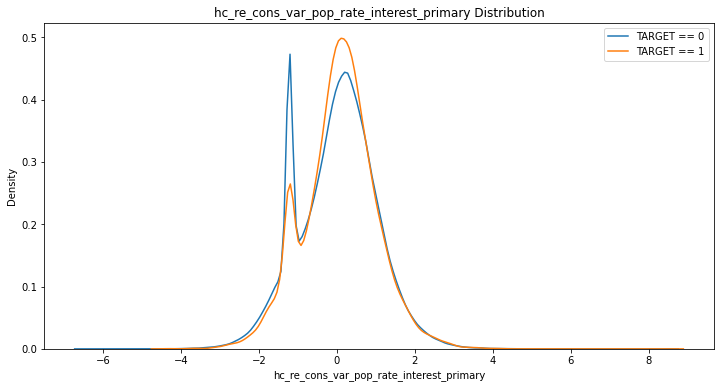

In [810]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_pop_rate_interest_primary', app_train)

In [811]:
#columns = ['hc_re_cons_var_pop_rate_interest_primary']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_var_samp_rate_interest_primary

In [812]:
#app_train['hc_re_cons_var_samp_rate_interest_primary'].value_counts()

In [813]:
app_train[['TARGET', 'hc_re_cons_var_samp_rate_interest_primary']].corr()

TARGET  \
TARGET                                     1.000000   
hc_re_cons_var_samp_rate_interest_primary -0.000321   

                                           hc_re_cons_var_samp_rate_interest_primary  
TARGET                                                                     -0.000321  
hc_re_cons_var_samp_rate_interest_primary                                   1.000000

The correlation between hc_re_cons_var_samp_rate_interest_primary and the TARGET is -0.0003
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


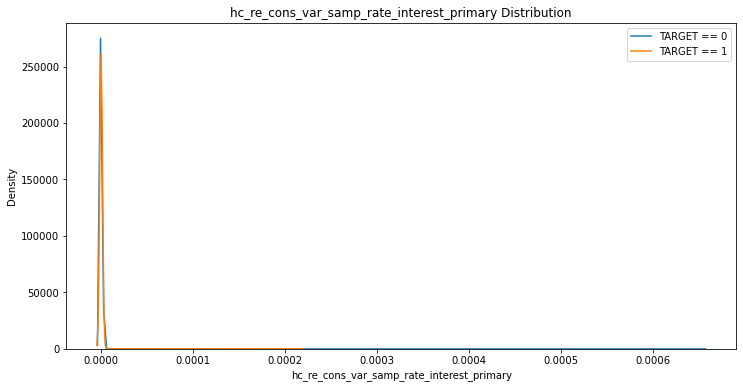

In [814]:
kde_target('hc_re_cons_var_samp_rate_interest_primary', app_train)

In [815]:
app_train['hc_re_cons_var_samp_rate_interest_primary'].isnull().sum()

286904

In [816]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_samp_rate_interest_primary')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_samp_rate_interest_primary  
0  52.715068                                  -0.000002  
1  49.490411                                   0.000018  
2  54.898630                                   0.000008  
3  38.290411                                  -0.000015  
4  35.726027                                   0.000013  

[5 rows x 92 columns]

In [817]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [818]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [819]:
app_train['hc_re_cons_var_samp_rate_interest_primary'].isnull().sum()

0

In [820]:
app_train[['TARGET', 'hc_re_cons_var_samp_rate_interest_primary']].corr()

TARGET  \
TARGET                                     1.000000   
hc_re_cons_var_samp_rate_interest_primary  0.004831   

                                           hc_re_cons_var_samp_rate_interest_primary  
TARGET                                                                      0.004831  
hc_re_cons_var_samp_rate_interest_primary                                   1.000000

In [821]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_var_samp_rate_interest_primary']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_var_samp_rate_interest_primary'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_var_samp_rate_interest_primary'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_var_samp_rate_interest_primary']].corr()

TARGET  \
TARGET                                     1.000000   
hc_re_cons_var_samp_rate_interest_primary  0.017679   

                                           hc_re_cons_var_samp_rate_interest_primary  
TARGET                                                                      0.017679  
hc_re_cons_var_samp_rate_interest_primary                                   1.000000

In [822]:
## 標準化
num_cols = ['hc_re_cons_var_samp_rate_interest_primary']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_samp_rate_interest_primary', 'TARGET']].corr()

hc_re_cons_var_samp_rate_interest_primary  \
hc_re_cons_var_samp_rate_interest_primary                                   1.000000   
TARGET                                                                      0.017679   

                                             TARGET  
hc_re_cons_var_samp_rate_interest_primary  0.017679  
TARGET                                     1.000000

The correlation between hc_re_cons_var_samp_rate_interest_primary and the TARGET is 0.0177
Median value for loan that was not repaid = 0.0977
Median value for loan that was repaid =     0.0616


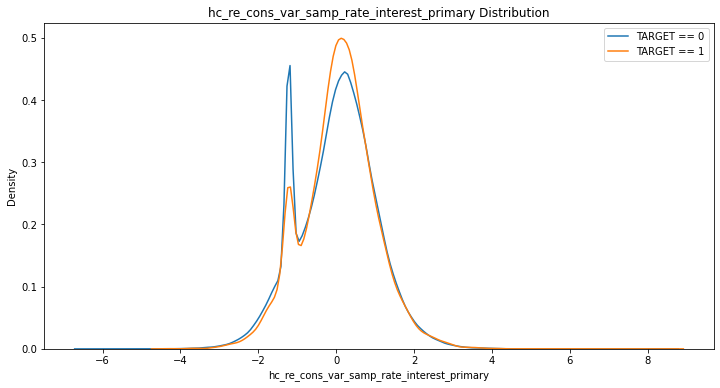

In [823]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_samp_rate_interest_primary', app_train)

In [824]:
#columns = ['hc_re_cons_var_samp_rate_interest_primary']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_variance_samp_rate_interest_primary

In [825]:
#app_train['hc_re_cons_variance_samp_rate_interest_primary'].value_counts()

In [826]:
app_train[['TARGET', 'hc_re_cons_variance_samp_rate_interest_primary']].corr()

TARGET  \
TARGET                                          1.00000   
hc_re_cons_variance_samp_rate_interest_primary -0.00049   

                                                hc_re_cons_variance_samp_rate_interest_primary  
TARGET                                                                                -0.00049  
hc_re_cons_variance_samp_rate_interest_primary                                         1.00000

The correlation between hc_re_cons_variance_samp_rate_interest_primary and the TARGET is -0.0005
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


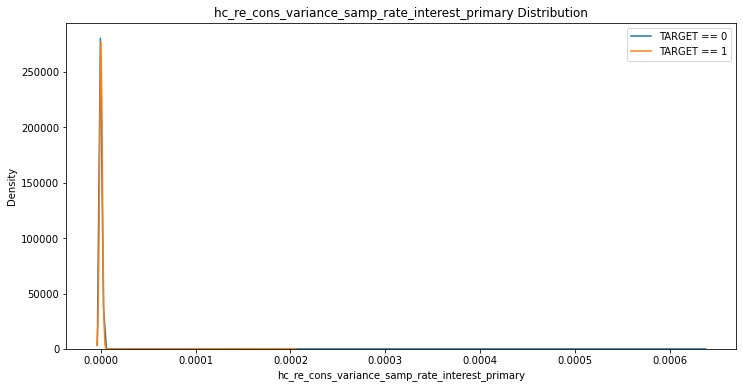

In [827]:
kde_target('hc_re_cons_variance_samp_rate_interest_primary', app_train)

In [828]:
app_train['hc_re_cons_variance_samp_rate_interest_primary'].isnull().sum()

286904

In [829]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_variance_samp_rate_interest_primary')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_variance_samp_rate_interest_primary  
0  52.715068                                       -0.000002  
1  49.490411                                        0.000018  
2  54.898630                                        0.000008  
3  38.290411                                       -0.000015  
4  35.726027                                        0.000012  

[5 rows x 92 columns]

In [830]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [831]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [832]:
app_train['hc_re_cons_variance_samp_rate_interest_primary'].isnull().sum()

0

In [833]:
app_train[['TARGET', 'hc_re_cons_variance_samp_rate_interest_primary']].corr()

TARGET  \
TARGET                                          1.000000   
hc_re_cons_variance_samp_rate_interest_primary  0.004759   

                                                hc_re_cons_variance_samp_rate_interest_primary  
TARGET                                                                                0.004759  
hc_re_cons_variance_samp_rate_interest_primary                                        1.000000

In [834]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_variance_samp_rate_interest_primary']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_variance_samp_rate_interest_primary'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_variance_samp_rate_interest_primary'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_variance_samp_rate_interest_primary']].corr()

TARGET  \
TARGET                                          1.000000   
hc_re_cons_variance_samp_rate_interest_primary  0.017584   

                                                hc_re_cons_variance_samp_rate_interest_primary  
TARGET                                                                                0.017584  
hc_re_cons_variance_samp_rate_interest_primary                                        1.000000

In [835]:
## 標準化
num_cols = ['hc_re_cons_variance_samp_rate_interest_primary']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_variance_samp_rate_interest_primary', 'TARGET']].corr()

hc_re_cons_variance_samp_rate_interest_primary  \
hc_re_cons_variance_samp_rate_interest_primary                                        1.000000   
TARGET                                                                                0.017584   

                                                  TARGET  
hc_re_cons_variance_samp_rate_interest_primary  0.017584  
TARGET                                          1.000000

The correlation between hc_re_cons_variance_samp_rate_interest_primary and the TARGET is 0.0176
Median value for loan that was not repaid = 0.0963
Median value for loan that was repaid =     0.0608


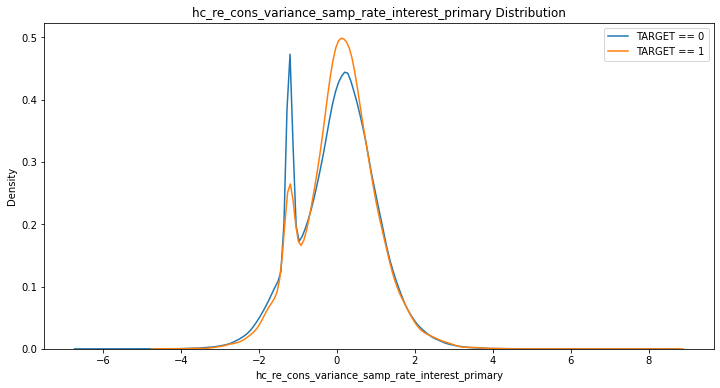

In [836]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_variance_samp_rate_interest_primary', app_train)

In [837]:
#columns = ['hc_re_cons_variance_samp_rate_interest_primary']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_max_rate_interest_privileged

In [838]:
#app_train['hc_re_cons_max_rate_interest_privileged'].value_counts()

In [839]:
app_train[['TARGET', 'hc_re_cons_max_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_max_rate_interest_privileged -0.008734   

                                         hc_re_cons_max_rate_interest_privileged  
TARGET                                                                 -0.008734  
hc_re_cons_max_rate_interest_privileged                                 1.000000

The correlation between hc_re_cons_max_rate_interest_privileged and the TARGET is -0.0087
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


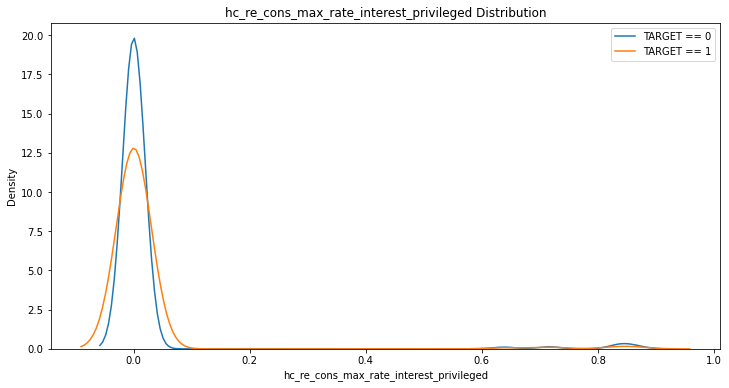

In [840]:
kde_target('hc_re_cons_max_rate_interest_privileged', app_train)

In [841]:
app_train['hc_re_cons_max_rate_interest_privileged'].isnull().sum()

286904

In [842]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_max_rate_interest_privileged')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_max_rate_interest_privileged  
0  52.715068                                 0.026880  
1  49.490411                                 0.019773  
2  54.898630                                 0.040106  
3  38.290411                                 0.168018  
4  35.726027                                 0.060370  

[5 rows x 92 columns]

In [843]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [844]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [845]:
app_train['hc_re_cons_max_rate_interest_privileged'].isnull().sum()

0

In [846]:
app_train[['TARGET', 'hc_re_cons_max_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_max_rate_interest_privileged  0.004234   

                                         hc_re_cons_max_rate_interest_privileged  
TARGET                                                                  0.004234  
hc_re_cons_max_rate_interest_privileged                                 1.000000

In [847]:
## Yao-Johnson変換
#num_cols = ['hc_re_cons_max_rate_interest_privileged']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['hc_re_cons_max_rate_interest_privileged'] = pt.transform(app_train[num_cols])
#app_test['hc_re_cons_max_rate_interest_privileged'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'hc_re_cons_max_rate_interest_privileged']].corr()

In [848]:
## 標準化
num_cols = ['hc_re_cons_max_rate_interest_privileged']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_max_rate_interest_privileged', 'TARGET']].corr()

hc_re_cons_max_rate_interest_privileged  \
hc_re_cons_max_rate_interest_privileged                                 1.000000   
TARGET                                                                  0.004234   

                                           TARGET  
hc_re_cons_max_rate_interest_privileged  0.004234  
TARGET                                   1.000000

The correlation between hc_re_cons_max_rate_interest_privileged and the TARGET is 0.0042
Median value for loan that was not repaid = -0.0183
Median value for loan that was repaid =     -0.0619


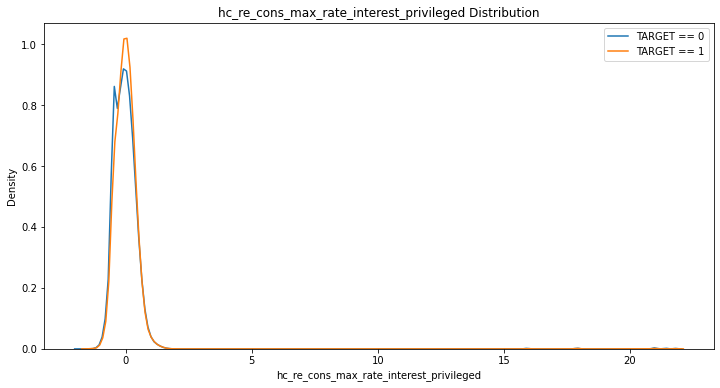

In [849]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_max_rate_interest_privileged', app_train)

In [850]:
#columns = ['hc_re_cons_max_rate_interest_privileged']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_min_rate_interest_privileged

In [851]:
#app_train['hc_re_cons_min_rate_interest_privileged'].value_counts()

In [852]:
app_train[['TARGET', 'hc_re_cons_min_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_min_rate_interest_privileged -0.008768   

                                         hc_re_cons_min_rate_interest_privileged  
TARGET                                                                 -0.008768  
hc_re_cons_min_rate_interest_privileged                                 1.000000

The correlation between hc_re_cons_min_rate_interest_privileged and the TARGET is -0.0088
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


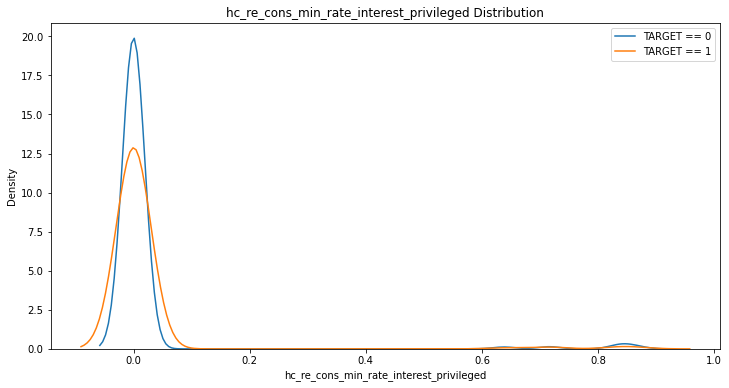

In [853]:
kde_target('hc_re_cons_min_rate_interest_privileged', app_train)

In [854]:
app_train['hc_re_cons_min_rate_interest_privileged'].isnull().sum()

286904

In [855]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_min_rate_interest_privileged')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_min_rate_interest_privileged  
0  52.715068                                 0.025794  
1  49.490411                                 0.015821  
2  54.898630                                 0.038503  
3  38.290411                                 0.164481  
4  35.726027                                 0.056834  

[5 rows x 92 columns]

In [856]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [857]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [858]:
app_train['hc_re_cons_min_rate_interest_privileged'].isnull().sum()

0

In [859]:
app_train[['TARGET', 'hc_re_cons_min_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_min_rate_interest_privileged  0.004211   

                                         hc_re_cons_min_rate_interest_privileged  
TARGET                                                                  0.004211  
hc_re_cons_min_rate_interest_privileged                                 1.000000

In [860]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_min_rate_interest_privileged']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_min_rate_interest_privileged'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_min_rate_interest_privileged'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_min_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_min_rate_interest_privileged  0.026856   

                                         hc_re_cons_min_rate_interest_privileged  
TARGET                                                                  0.026856  
hc_re_cons_min_rate_interest_privileged                                 1.000000

In [861]:
## 標準化
num_cols = ['hc_re_cons_min_rate_interest_privileged']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_min_rate_interest_privileged', 'TARGET']].corr()

hc_re_cons_min_rate_interest_privileged  \
hc_re_cons_min_rate_interest_privileged                                 1.000000   
TARGET                                                                  0.026856   

                                           TARGET  
hc_re_cons_min_rate_interest_privileged  0.026856  
TARGET                                   1.000000

The correlation between hc_re_cons_min_rate_interest_privileged and the TARGET is 0.0269
Median value for loan that was not repaid = 0.1639
Median value for loan that was repaid =     0.0550


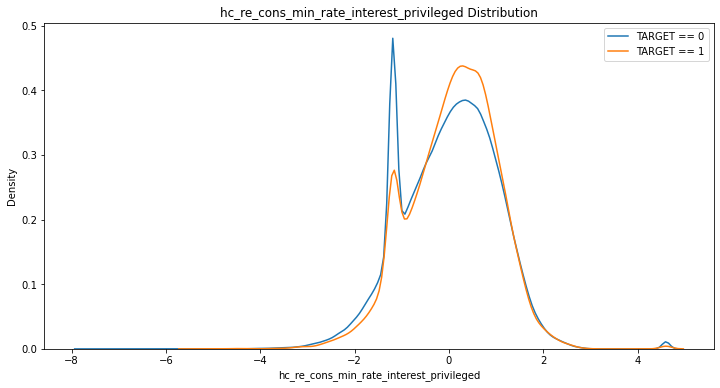

In [862]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_min_rate_interest_privileged', app_train)

In [863]:
#columns = ['hc_re_cons_min_rate_interest_privileged']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_sum_rate_interest_privileged

In [864]:
#app_train['hc_re_cons_sum_rate_interest_privileged'].value_counts()

In [865]:
app_train[['TARGET', 'hc_re_cons_sum_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.00000   
hc_re_cons_sum_rate_interest_privileged -0.00384   

                                         hc_re_cons_sum_rate_interest_privileged  
TARGET                                                                  -0.00384  
hc_re_cons_sum_rate_interest_privileged                                  1.00000

The correlation between hc_re_cons_sum_rate_interest_privileged and the TARGET is -0.0038
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


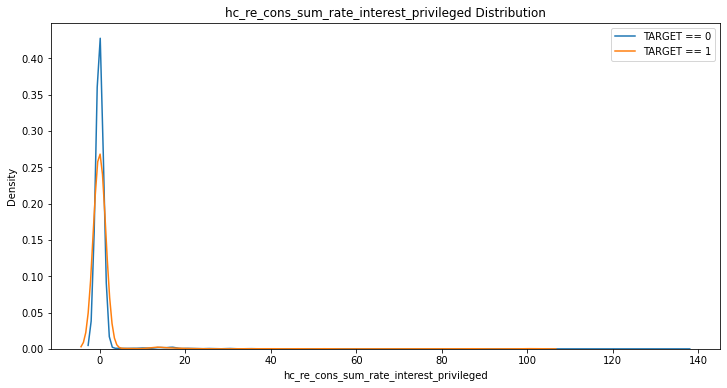

In [866]:
kde_target('hc_re_cons_sum_rate_interest_privileged', app_train)

In [867]:
app_train['hc_re_cons_sum_rate_interest_privileged'].isnull().sum()

286904

In [868]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_sum_rate_interest_privileged')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_sum_rate_interest_privileged  
0  52.715068                                 1.215997  
1  49.490411                                 0.716518  
2  54.898630                                 1.061630  
3  38.290411                                 2.925610  
4  35.726027                                 1.279580  

[5 rows x 92 columns]

In [869]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [870]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [871]:
app_train['hc_re_cons_sum_rate_interest_privileged'].isnull().sum()

0

In [872]:
app_train[['TARGET', 'hc_re_cons_sum_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_sum_rate_interest_privileged  0.015227   

                                         hc_re_cons_sum_rate_interest_privileged  
TARGET                                                                  0.015227  
hc_re_cons_sum_rate_interest_privileged                                 1.000000

In [873]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_sum_rate_interest_privileged']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_sum_rate_interest_privileged'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_sum_rate_interest_privileged'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_sum_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_sum_rate_interest_privileged  0.067245   

                                         hc_re_cons_sum_rate_interest_privileged  
TARGET                                                                  0.067245  
hc_re_cons_sum_rate_interest_privileged                                 1.000000

In [874]:
## 標準化
num_cols = ['hc_re_cons_sum_rate_interest_privileged']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_sum_rate_interest_privileged', 'TARGET']].corr()

hc_re_cons_sum_rate_interest_privileged  \
hc_re_cons_sum_rate_interest_privileged                                 1.000000   
TARGET                                                                  0.067245   

                                           TARGET  
hc_re_cons_sum_rate_interest_privileged  0.067245  
TARGET                                   1.000000

The correlation between hc_re_cons_sum_rate_interest_privileged and the TARGET is 0.0672
Median value for loan that was not repaid = 0.4110
Median value for loan that was repaid =     0.1709


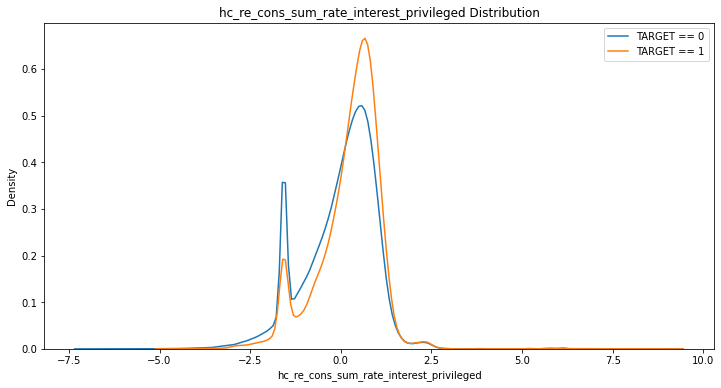

In [875]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_sum_rate_interest_privileged', app_train)

In [876]:
#columns = ['hc_re_cons_sum_rate_interest_privileged']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_avg_rate_interest_privileged

In [877]:
#app_train['hc_re_cons_avg_rate_interest_privileged'].value_counts()

In [878]:
app_train[['TARGET', 'hc_re_cons_avg_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_avg_rate_interest_privileged -0.008738   

                                         hc_re_cons_avg_rate_interest_privileged  
TARGET                                                                 -0.008738  
hc_re_cons_avg_rate_interest_privileged                                 1.000000

The correlation between hc_re_cons_avg_rate_interest_privileged and the TARGET is -0.0087
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


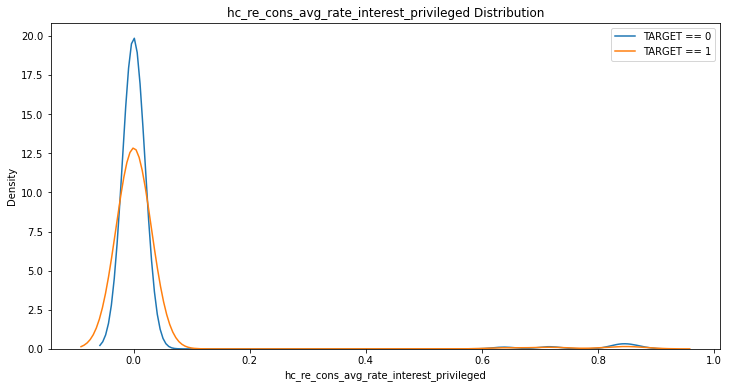

In [879]:
kde_target('hc_re_cons_avg_rate_interest_privileged', app_train)

In [880]:
app_train['hc_re_cons_avg_rate_interest_privileged'].isnull().sum()

286904

In [881]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_avg_rate_interest_privileged')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_avg_rate_interest_privileged  
0  52.715068                                 0.026336  
1  49.490411                                 0.017796  
2  54.898630                                 0.039305  
3  38.290411                                 0.166262  
4  35.726027                                 0.058601  

[5 rows x 92 columns]

In [882]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [883]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [884]:
app_train['hc_re_cons_avg_rate_interest_privileged'].isnull().sum()

0

In [885]:
app_train[['TARGET', 'hc_re_cons_avg_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_avg_rate_interest_privileged  0.004259   

                                         hc_re_cons_avg_rate_interest_privileged  
TARGET                                                                  0.004259  
hc_re_cons_avg_rate_interest_privileged                                 1.000000

In [886]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_avg_rate_interest_privileged']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_avg_rate_interest_privileged'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_avg_rate_interest_privileged'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_avg_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.00000   
hc_re_cons_avg_rate_interest_privileged  0.02693   

                                         hc_re_cons_avg_rate_interest_privileged  
TARGET                                                                   0.02693  
hc_re_cons_avg_rate_interest_privileged                                  1.00000

In [887]:
## 標準化
num_cols = ['hc_re_cons_avg_rate_interest_privileged']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_avg_rate_interest_privileged', 'TARGET']].corr()

hc_re_cons_avg_rate_interest_privileged  \
hc_re_cons_avg_rate_interest_privileged                                  1.00000   
TARGET                                                                   0.02693   

                                          TARGET  
hc_re_cons_avg_rate_interest_privileged  0.02693  
TARGET                                   1.00000

The correlation between hc_re_cons_avg_rate_interest_privileged and the TARGET is 0.0269
Median value for loan that was not repaid = 0.1644
Median value for loan that was repaid =     0.0552


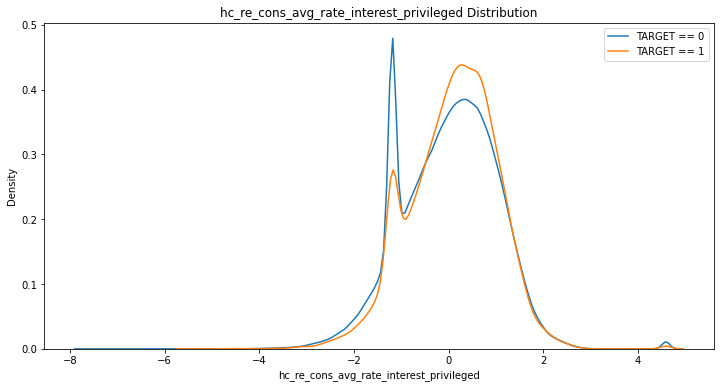

In [888]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_avg_rate_interest_privileged', app_train)

In [889]:
#columns = ['hc_re_cons_avg_rate_interest_privileged']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_cnt_rate_interest_privileged

In [890]:
#app_train['hc_re_cons_cnt_rate_interest_privileged'].value_counts()

In [891]:
app_train[['TARGET', 'hc_re_cons_cnt_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_cnt_rate_interest_privileged -0.003526   

                                         hc_re_cons_cnt_rate_interest_privileged  
TARGET                                                                 -0.003526  
hc_re_cons_cnt_rate_interest_privileged                                 1.000000

The correlation between hc_re_cons_cnt_rate_interest_privileged and the TARGET is -0.0035
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


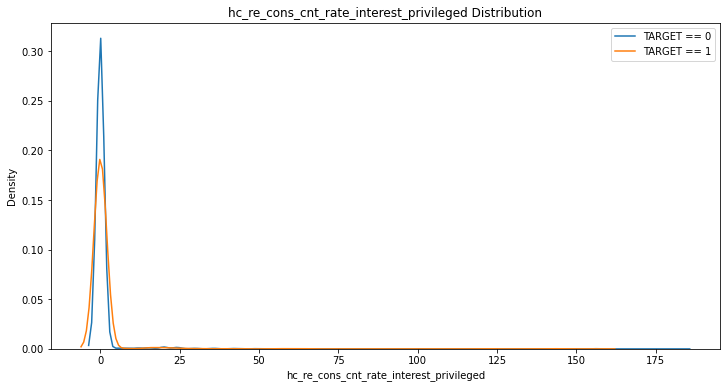

In [892]:
kde_target('hc_re_cons_cnt_rate_interest_privileged', app_train)

In [893]:
app_train['hc_re_cons_cnt_rate_interest_privileged'].isnull().sum()

286904

In [894]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_cnt_rate_interest_privileged')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_cnt_rate_interest_privileged  
0  52.715068                                 1.506796  
1  49.490411                                 0.906887  
2  54.898630                                 1.379729  
3  38.290411                                 3.588640  
4  35.726027                                 1.600152  

[5 rows x 92 columns]

In [895]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [896]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [897]:
app_train['hc_re_cons_cnt_rate_interest_privileged'].isnull().sum()

0

In [898]:
app_train[['TARGET', 'hc_re_cons_cnt_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_cnt_rate_interest_privileged  0.015177   

                                         hc_re_cons_cnt_rate_interest_privileged  
TARGET                                                                  0.015177  
hc_re_cons_cnt_rate_interest_privileged                                 1.000000

In [899]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_cnt_rate_interest_privileged']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_cnt_rate_interest_privileged'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_cnt_rate_interest_privileged'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_cnt_rate_interest_privileged']].corr()

TARGET  \
TARGET                                   1.000000   
hc_re_cons_cnt_rate_interest_privileged  0.067416   

                                         hc_re_cons_cnt_rate_interest_privileged  
TARGET                                                                  0.067416  
hc_re_cons_cnt_rate_interest_privileged                                 1.000000

In [900]:
## 標準化
num_cols = ['hc_re_cons_cnt_rate_interest_privileged']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_cnt_rate_interest_privileged', 'TARGET']].corr()

hc_re_cons_cnt_rate_interest_privileged  \
hc_re_cons_cnt_rate_interest_privileged                                 1.000000   
TARGET                                                                  0.067416   

                                           TARGET  
hc_re_cons_cnt_rate_interest_privileged  0.067416  
TARGET                                   1.000000

The correlation between hc_re_cons_cnt_rate_interest_privileged and the TARGET is 0.0674
Median value for loan that was not repaid = 0.4087
Median value for loan that was repaid =     0.1684


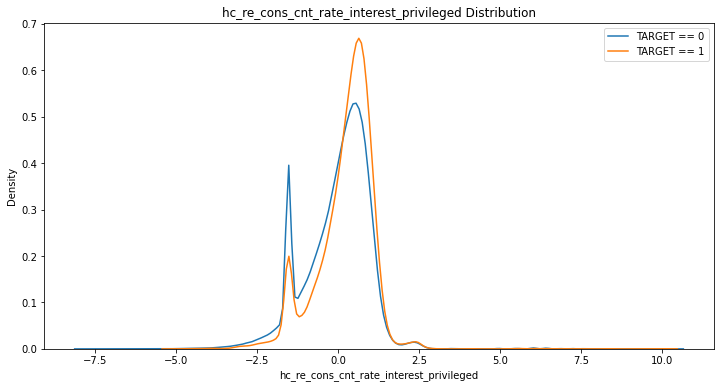

In [901]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_cnt_rate_interest_privileged', app_train)

In [902]:
#columns = ['hc_re_cons_cnt_rate_interest_privileged']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_stddev_rate_interest_privileged

In [903]:
#app_train['hc_re_cons_stddev_rate_interest_privileged'].value_counts()

In [904]:
app_train[['TARGET', 'hc_re_cons_stddev_rate_interest_privileged']].corr()

TARGET  \
TARGET                                      1.000000   
hc_re_cons_stddev_rate_interest_privileged  0.000762   

                                            hc_re_cons_stddev_rate_interest_privileged  
TARGET                                                                        0.000762  
hc_re_cons_stddev_rate_interest_privileged                                    1.000000

The correlation between hc_re_cons_stddev_rate_interest_privileged and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


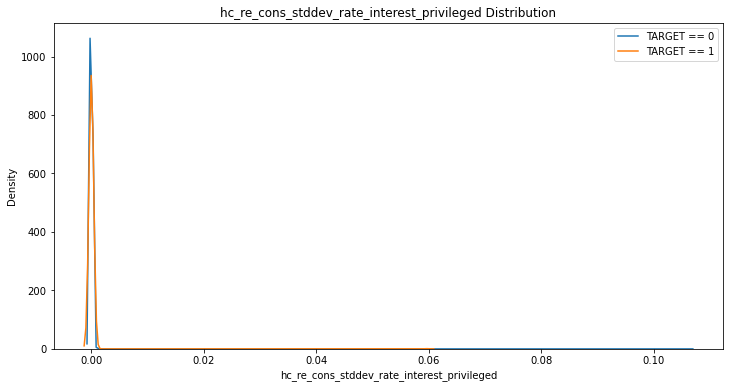

In [905]:
kde_target('hc_re_cons_stddev_rate_interest_privileged', app_train)

In [906]:
app_train['hc_re_cons_stddev_rate_interest_privileged'].isnull().sum()

286904

In [907]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_rate_interest_privileged')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_rate_interest_privileged  
0  52.715068                                    0.000510  
1  49.490411                                    0.001514  
2  54.898630                                    0.001358  
3  38.290411                                    0.001404  
4  35.726027                                    0.002358  

[5 rows x 92 columns]

In [908]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [909]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [910]:
app_train['hc_re_cons_stddev_rate_interest_privileged'].isnull().sum()

0

In [911]:
app_train[['TARGET', 'hc_re_cons_stddev_rate_interest_privileged']].corr()

TARGET  \
TARGET                                      1.00000   
hc_re_cons_stddev_rate_interest_privileged  0.00396   

                                            hc_re_cons_stddev_rate_interest_privileged  
TARGET                                                                         0.00396  
hc_re_cons_stddev_rate_interest_privileged                                     1.00000

In [912]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_stddev_rate_interest_privileged']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_stddev_rate_interest_privileged'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_stddev_rate_interest_privileged'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_stddev_rate_interest_privileged']].corr()

TARGET  \
TARGET                                      1.000000   
hc_re_cons_stddev_rate_interest_privileged  0.015294   

                                            hc_re_cons_stddev_rate_interest_privileged  
TARGET                                                                        0.015294  
hc_re_cons_stddev_rate_interest_privileged                                    1.000000

In [913]:
## 標準化
num_cols = ['hc_re_cons_stddev_rate_interest_privileged']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_rate_interest_privileged', 'TARGET']].corr()

hc_re_cons_stddev_rate_interest_privileged  \
hc_re_cons_stddev_rate_interest_privileged                                    1.000000   
TARGET                                                                        0.015294   

                                              TARGET  
hc_re_cons_stddev_rate_interest_privileged  0.015294  
TARGET                                      1.000000

The correlation between hc_re_cons_stddev_rate_interest_privileged and the TARGET is 0.0153
Median value for loan that was not repaid = 0.0744
Median value for loan that was repaid =     0.0304


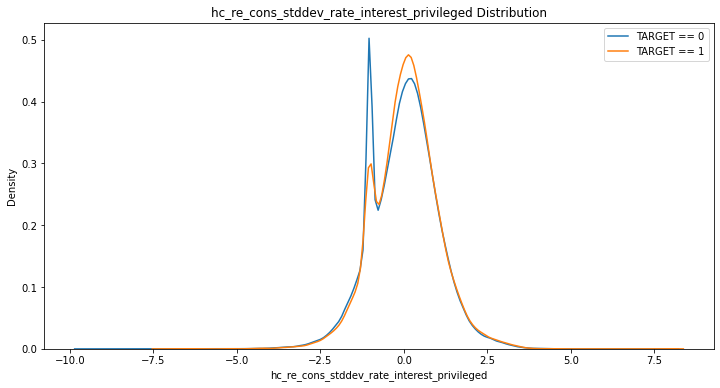

In [914]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_rate_interest_privileged', app_train)

In [915]:
#columns = ['hc_re_cons_stddev_rate_interest_privileged']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_stddev_pop_rate_interest_privileged

In [916]:
#app_train['hc_re_cons_stddev_pop_rate_interest_privileged'].value_counts()

In [917]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_rate_interest_privileged']].corr()

TARGET  \
TARGET                                          1.000000   
hc_re_cons_stddev_pop_rate_interest_privileged  0.000762   

                                                hc_re_cons_stddev_pop_rate_interest_privileged  
TARGET                                                                                0.000762  
hc_re_cons_stddev_pop_rate_interest_privileged                                        1.000000

The correlation between hc_re_cons_stddev_pop_rate_interest_privileged and the TARGET is 0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


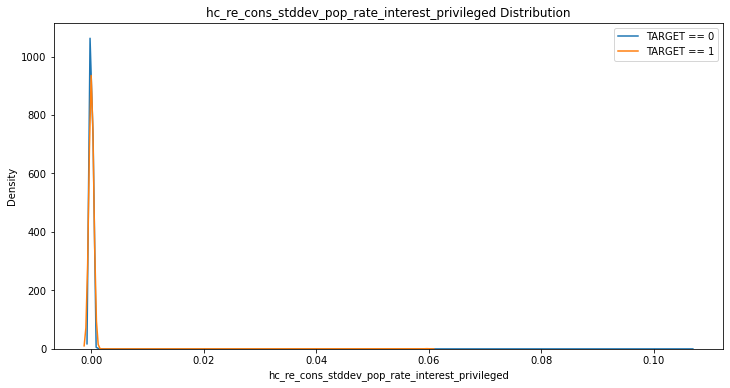

In [918]:
kde_target('hc_re_cons_stddev_pop_rate_interest_privileged', app_train)

In [919]:
app_train['hc_re_cons_stddev_pop_rate_interest_privileged'].isnull().sum()

286904

In [920]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_pop_rate_interest_privileged')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_pop_rate_interest_privileged  
0  52.715068                                        0.000510  
1  49.490411                                        0.001514  
2  54.898630                                        0.001358  
3  38.290411                                        0.001404  
4  35.726027                                        0.002358  

[5 rows x 92 columns]

In [921]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [922]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [923]:
app_train['hc_re_cons_stddev_pop_rate_interest_privileged'].isnull().sum()

0

In [924]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_rate_interest_privileged']].corr()

TARGET  \
TARGET                                          1.00000   
hc_re_cons_stddev_pop_rate_interest_privileged  0.00396   

                                                hc_re_cons_stddev_pop_rate_interest_privileged  
TARGET                                                                                 0.00396  
hc_re_cons_stddev_pop_rate_interest_privileged                                         1.00000

In [925]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_stddev_pop_rate_interest_privileged']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_stddev_pop_rate_interest_privileged'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_stddev_pop_rate_interest_privileged'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_stddev_pop_rate_interest_privileged']].corr()

TARGET  \
TARGET                                          1.000000   
hc_re_cons_stddev_pop_rate_interest_privileged  0.015294   

                                                hc_re_cons_stddev_pop_rate_interest_privileged  
TARGET                                                                                0.015294  
hc_re_cons_stddev_pop_rate_interest_privileged                                        1.000000

In [926]:
## 標準化
num_cols = ['hc_re_cons_stddev_pop_rate_interest_privileged']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_pop_rate_interest_privileged', 'TARGET']].corr()

hc_re_cons_stddev_pop_rate_interest_privileged  \
hc_re_cons_stddev_pop_rate_interest_privileged                                        1.000000   
TARGET                                                                                0.015294   

                                                  TARGET  
hc_re_cons_stddev_pop_rate_interest_privileged  0.015294  
TARGET                                          1.000000

The correlation between hc_re_cons_stddev_pop_rate_interest_privileged and the TARGET is 0.0153
Median value for loan that was not repaid = 0.0744
Median value for loan that was repaid =     0.0304


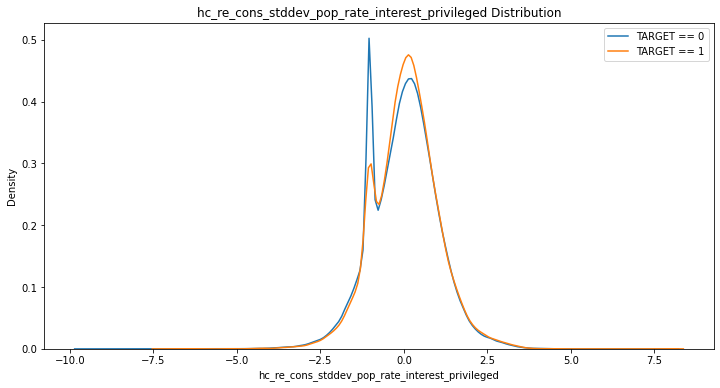

In [927]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_pop_rate_interest_privileged', app_train)

In [928]:
#columns = ['hc_re_cons_stddev_pop_rate_interest_privileged']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_var_pop_rate_interest_privileged

In [929]:
#app_train['hc_re_cons_var_pop_rate_interest_privileged'].value_counts()

In [930]:
app_train[['TARGET', 'hc_re_cons_var_pop_rate_interest_privileged']].corr()

TARGET  \
TARGET                                       1.000000   
hc_re_cons_var_pop_rate_interest_privileged -0.000484   

                                             hc_re_cons_var_pop_rate_interest_privileged  
TARGET                                                                         -0.000484  
hc_re_cons_var_pop_rate_interest_privileged                                     1.000000

The correlation between hc_re_cons_var_pop_rate_interest_privileged and the TARGET is -0.0005
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


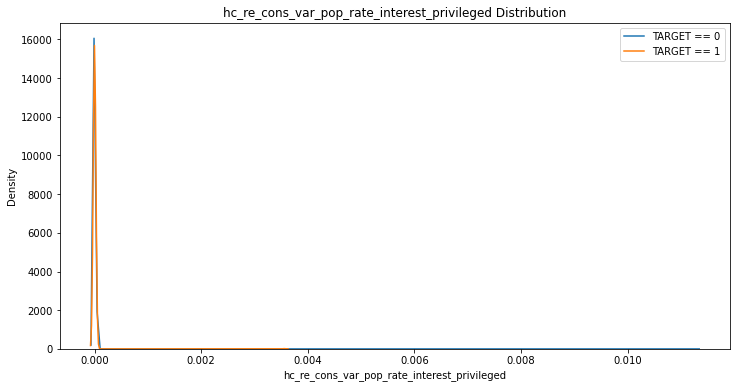

In [931]:
kde_target('hc_re_cons_var_pop_rate_interest_privileged', app_train)

In [932]:
app_train['hc_re_cons_var_pop_rate_interest_privileged'].isnull().sum()

286904

In [933]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_pop_rate_interest_privileged')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_pop_rate_interest_privileged  
0  52.715068                                    -0.000013  
1  49.490411                                     0.000256  
2  54.898630                                     0.000255  
3  38.290411                                    -0.000033  
4  35.726027                                     0.000349  

[5 rows x 92 columns]

In [934]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [935]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [936]:
app_train['hc_re_cons_var_pop_rate_interest_privileged'].isnull().sum()

0

In [937]:
app_train[['TARGET', 'hc_re_cons_var_pop_rate_interest_privileged']].corr()

TARGET  \
TARGET                                       1.000000   
hc_re_cons_var_pop_rate_interest_privileged  0.006555   

                                             hc_re_cons_var_pop_rate_interest_privileged  
TARGET                                                                          0.006555  
hc_re_cons_var_pop_rate_interest_privileged                                     1.000000

In [938]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_var_pop_rate_interest_privileged']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_var_pop_rate_interest_privileged'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_var_pop_rate_interest_privileged'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_var_pop_rate_interest_privileged']].corr()

TARGET  \
TARGET                                       1.000000   
hc_re_cons_var_pop_rate_interest_privileged  0.023048   

                                             hc_re_cons_var_pop_rate_interest_privileged  
TARGET                                                                          0.023048  
hc_re_cons_var_pop_rate_interest_privileged                                     1.000000

In [939]:
## 標準化
num_cols = ['hc_re_cons_var_pop_rate_interest_privileged']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_pop_rate_interest_privileged', 'TARGET']].corr()

hc_re_cons_var_pop_rate_interest_privileged  \
hc_re_cons_var_pop_rate_interest_privileged                                     1.000000   
TARGET                                                                          0.023048   

                                               TARGET  
hc_re_cons_var_pop_rate_interest_privileged  0.023048  
TARGET                                       1.000000

The correlation between hc_re_cons_var_pop_rate_interest_privileged and the TARGET is 0.0230
Median value for loan that was not repaid = 0.1277
Median value for loan that was repaid =     0.0726


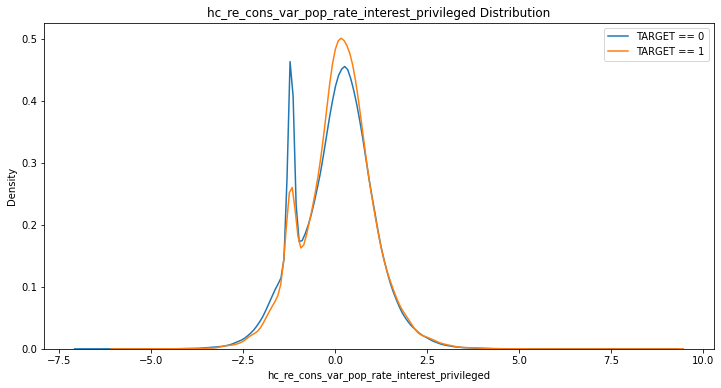

In [940]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_pop_rate_interest_privileged', app_train)

In [941]:
#columns = ['hc_re_cons_var_pop_rate_interest_privileged']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_var_samp_rate_interest_privileged

In [942]:
#app_train['hc_re_cons_var_samp_rate_interest_privileged'].value_counts()

In [943]:
app_train[['TARGET', 'hc_re_cons_var_samp_rate_interest_privileged']].corr()

TARGET  \
TARGET                                        1.000000   
hc_re_cons_var_samp_rate_interest_privileged -0.000322   

                                              hc_re_cons_var_samp_rate_interest_privileged  
TARGET                                                                           -0.000322  
hc_re_cons_var_samp_rate_interest_privileged                                      1.000000

The correlation between hc_re_cons_var_samp_rate_interest_privileged and the TARGET is -0.0003
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


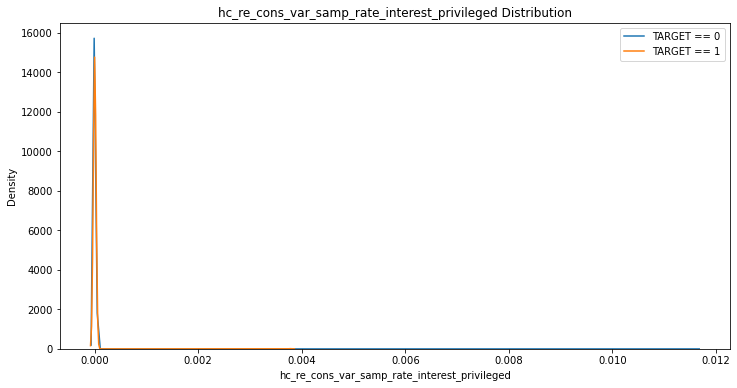

In [944]:
kde_target('hc_re_cons_var_samp_rate_interest_privileged', app_train)

In [945]:
app_train['hc_re_cons_var_samp_rate_interest_privileged'].isnull().sum()

286904

In [946]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_samp_rate_interest_privileged')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_samp_rate_interest_privileged  
0  52.715068                                     -0.000013  
1  49.490411                                      0.000262  
2  54.898630                                      0.000262  
3  38.290411                                     -0.000030  
4  35.726027                                      0.000359  

[5 rows x 92 columns]

In [947]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [948]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [949]:
app_train['hc_re_cons_var_samp_rate_interest_privileged'].isnull().sum()

0

In [950]:
app_train[['TARGET', 'hc_re_cons_var_samp_rate_interest_privileged']].corr()

TARGET  \
TARGET                                        1.00000   
hc_re_cons_var_samp_rate_interest_privileged  0.00658   

                                              hc_re_cons_var_samp_rate_interest_privileged  
TARGET                                                                             0.00658  
hc_re_cons_var_samp_rate_interest_privileged                                       1.00000

In [951]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_var_samp_rate_interest_privileged']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_var_samp_rate_interest_privileged'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_var_samp_rate_interest_privileged'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_var_samp_rate_interest_privileged']].corr()

TARGET  \
TARGET                                        1.000000   
hc_re_cons_var_samp_rate_interest_privileged  0.023005   

                                              hc_re_cons_var_samp_rate_interest_privileged  
TARGET                                                                            0.023005  
hc_re_cons_var_samp_rate_interest_privileged                                      1.000000

In [952]:
## 標準化
num_cols = ['hc_re_cons_var_samp_rate_interest_privileged']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_samp_rate_interest_privileged', 'TARGET']].corr()

hc_re_cons_var_samp_rate_interest_privileged  \
hc_re_cons_var_samp_rate_interest_privileged                                      1.000000   
TARGET                                                                            0.023005   

                                                TARGET  
hc_re_cons_var_samp_rate_interest_privileged  0.023005  
TARGET                                        1.000000

The correlation between hc_re_cons_var_samp_rate_interest_privileged and the TARGET is 0.0230
Median value for loan that was not repaid = 0.1274
Median value for loan that was repaid =     0.0735


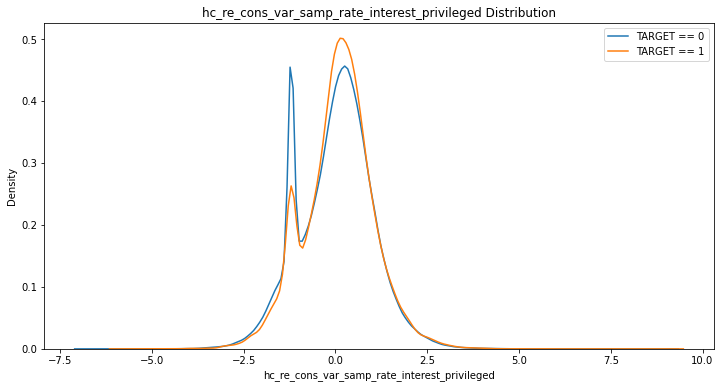

In [953]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_samp_rate_interest_privileged', app_train)

In [954]:
#columns = ['hc_re_cons_var_samp_rate_interest_privileged']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_variance_samp_rate_interest_privileged

In [955]:
#app_train['hc_re_cons_variance_samp_rate_interest_privileged'].value_counts()

In [956]:
app_train[['TARGET', 'hc_re_cons_variance_samp_rate_interest_privileged']].corr()

TARGET  \
TARGET                                             1.000000   
hc_re_cons_variance_samp_rate_interest_privileged -0.000484   

                                                   hc_re_cons_variance_samp_rate_interest_privileged  
TARGET                                                                                     -0.000484  
hc_re_cons_variance_samp_rate_interest_privileged                                           1.000000

The correlation between hc_re_cons_variance_samp_rate_interest_privileged and the TARGET is -0.0005
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


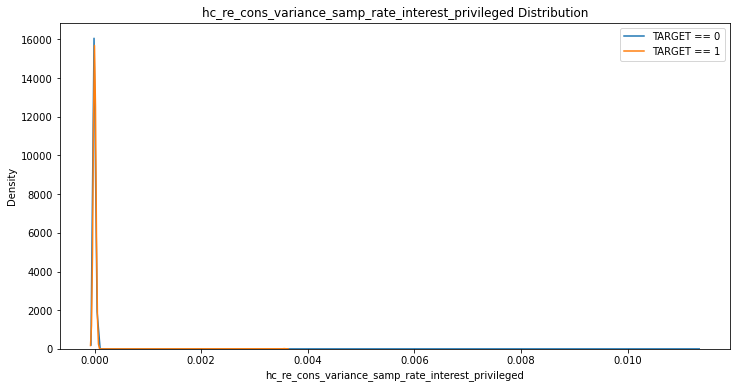

In [957]:
kde_target('hc_re_cons_variance_samp_rate_interest_privileged', app_train)

In [958]:
app_train['hc_re_cons_variance_samp_rate_interest_privileged'].isnull().sum()

286904

In [959]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_variance_samp_rate_interest_privileged')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_variance_samp_rate_interest_privileged  
0  52.715068                                          -0.000013  
1  49.490411                                           0.000256  
2  54.898630                                           0.000255  
3  38.290411                                          -0.000033  
4  35.726027                                           0.000349  

[5 rows x 92 columns]

In [960]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [961]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [962]:
app_train['hc_re_cons_variance_samp_rate_interest_privileged'].isnull().sum()

0

In [963]:
app_train[['TARGET', 'hc_re_cons_variance_samp_rate_interest_privileged']].corr()

TARGET  \
TARGET                                             1.000000   
hc_re_cons_variance_samp_rate_interest_privileged  0.006555   

                                                   hc_re_cons_variance_samp_rate_interest_privileged  
TARGET                                                                                      0.006555  
hc_re_cons_variance_samp_rate_interest_privileged                                           1.000000

In [964]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_variance_samp_rate_interest_privileged']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_variance_samp_rate_interest_privileged'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_variance_samp_rate_interest_privileged'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_variance_samp_rate_interest_privileged']].corr()

TARGET  \
TARGET                                             1.000000   
hc_re_cons_variance_samp_rate_interest_privileged  0.023048   

                                                   hc_re_cons_variance_samp_rate_interest_privileged  
TARGET                                                                                      0.023048  
hc_re_cons_variance_samp_rate_interest_privileged                                           1.000000

In [965]:
## 標準化
num_cols = ['hc_re_cons_variance_samp_rate_interest_privileged']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_variance_samp_rate_interest_privileged', 'TARGET']].corr()

hc_re_cons_variance_samp_rate_interest_privileged  \
hc_re_cons_variance_samp_rate_interest_privileged                                           1.000000   
TARGET                                                                                      0.023048   

                                                     TARGET  
hc_re_cons_variance_samp_rate_interest_privileged  0.023048  
TARGET                                             1.000000

The correlation between hc_re_cons_variance_samp_rate_interest_privileged and the TARGET is 0.0230
Median value for loan that was not repaid = 0.1277
Median value for loan that was repaid =     0.0726


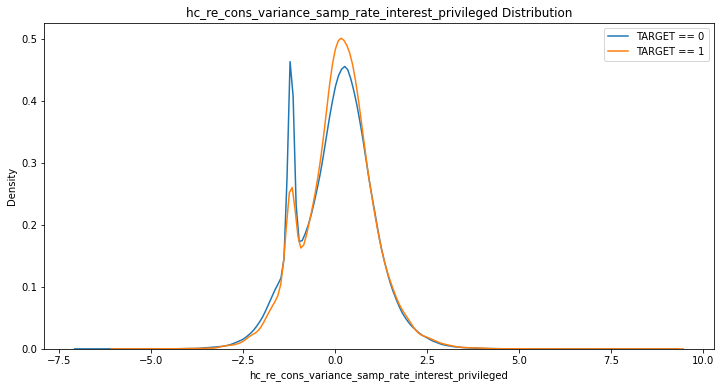

In [966]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_variance_samp_rate_interest_privileged', app_train)

In [967]:
#columns = ['hc_re_cons_variance_samp_rate_interest_privileged']
#app_train.drop(columns, axis=1, inplace=True)
#app_test.drop(columns, axis=1, inplace=True)

### hc_re_cons_max_sk_dpd

In [968]:
app_train[['TARGET', 'hc_re_cons_max_sk_dpd']].corr()

TARGET  hc_re_cons_max_sk_dpd
TARGET                 1.000000              -0.004655
hc_re_cons_max_sk_dpd -0.004655               1.000000

The correlation between hc_re_cons_max_sk_dpd and the TARGET is -0.0047
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


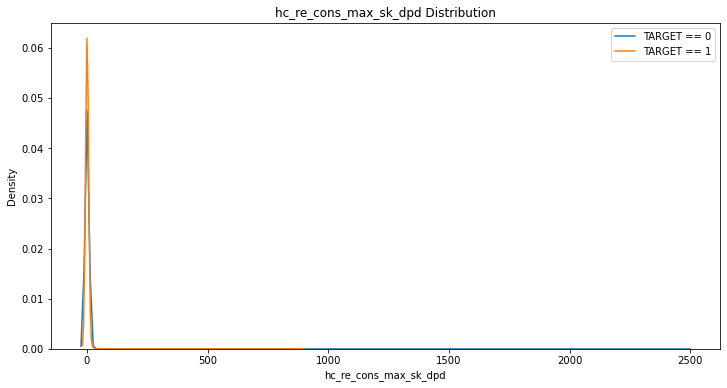

In [969]:
kde_target('hc_re_cons_max_sk_dpd', app_train)

In [970]:
app_train['hc_re_cons_max_sk_dpd'].isnull().sum()

286904

In [971]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_max_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_max_sk_dpd  
0  52.715068              -0.047699  
1  49.490411              -0.006785  
2  54.898630               0.020140  
3  38.290411              -0.484185  
4  35.726027              -0.143673  

[5 rows x 92 columns]

In [972]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [973]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [974]:
app_train['hc_re_cons_max_sk_dpd'].isnull().sum()

0

In [975]:
app_train[['TARGET', 'hc_re_cons_max_sk_dpd']].corr()

TARGET  hc_re_cons_max_sk_dpd
TARGET                 1.000000              -0.003657
hc_re_cons_max_sk_dpd -0.003657               1.000000

In [976]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_max_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_max_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_max_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_max_sk_dpd']].corr()

TARGET  hc_re_cons_max_sk_dpd
TARGET                 1.000000              -0.003758
hc_re_cons_max_sk_dpd -0.003758               1.000000

In [977]:
## 標準化
num_cols = ['hc_re_cons_max_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_max_sk_dpd', 'TARGET']].corr()

hc_re_cons_max_sk_dpd    TARGET
hc_re_cons_max_sk_dpd               1.000000 -0.003758
TARGET                             -0.003758  1.000000

The correlation between hc_re_cons_max_sk_dpd and the TARGET is -0.0038
Median value for loan that was not repaid = 0.1801
Median value for loan that was repaid =     0.2121


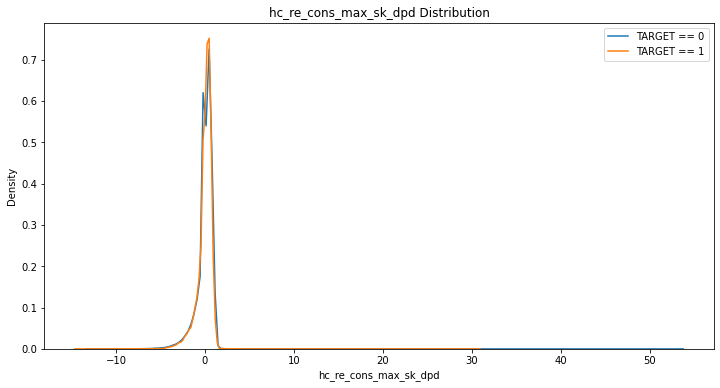

In [978]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_max_sk_dpd', app_train)

### hc_re_cons_min_sk_dpd

In [979]:
app_train[['TARGET', 'hc_re_cons_min_sk_dpd']].corr()

TARGET  hc_re_cons_min_sk_dpd
TARGET                 1.000000              -0.003235
hc_re_cons_min_sk_dpd -0.003235               1.000000

The correlation between hc_re_cons_min_sk_dpd and the TARGET is -0.0032
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


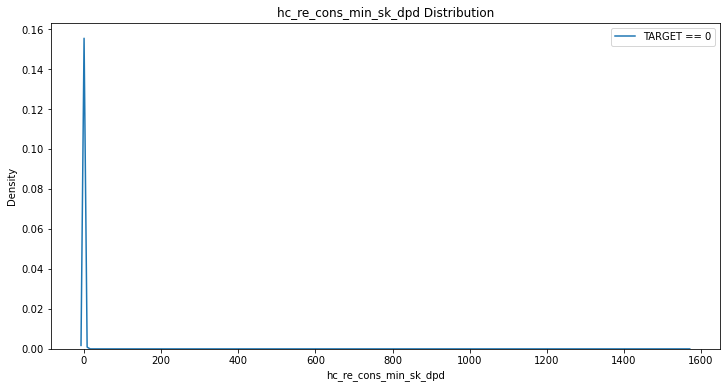

In [980]:
kde_target('hc_re_cons_min_sk_dpd', app_train)

In [981]:
app_train['hc_re_cons_min_sk_dpd'].isnull().sum()

286904

In [982]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_min_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_min_sk_dpd  
0  52.715068                    0.0  
1  49.490411                    0.0  
2  54.898630                    0.0  
3  38.290411                    0.0  
4  35.726027                    0.0  

[5 rows x 92 columns]

In [983]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [984]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [985]:
app_train['hc_re_cons_min_sk_dpd'].isnull().sum()

0

In [986]:
app_train[['TARGET', 'hc_re_cons_min_sk_dpd']].corr()

TARGET  hc_re_cons_min_sk_dpd
TARGET                 1.000000               0.001403
hc_re_cons_min_sk_dpd  0.001403               1.000000

In [987]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_min_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_min_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_min_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_min_sk_dpd']].corr()

TARGET  hc_re_cons_min_sk_dpd
TARGET                 1.000000               0.024164
hc_re_cons_min_sk_dpd  0.024164               1.000000

In [988]:
## 標準化
num_cols = ['hc_re_cons_min_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_min_sk_dpd', 'TARGET']].corr()

hc_re_cons_min_sk_dpd    TARGET
hc_re_cons_min_sk_dpd               1.000000  0.024164
TARGET                              0.024164  1.000000

The correlation between hc_re_cons_min_sk_dpd and the TARGET is 0.0242
Median value for loan that was not repaid = 0.2326
Median value for loan that was repaid =     0.1877


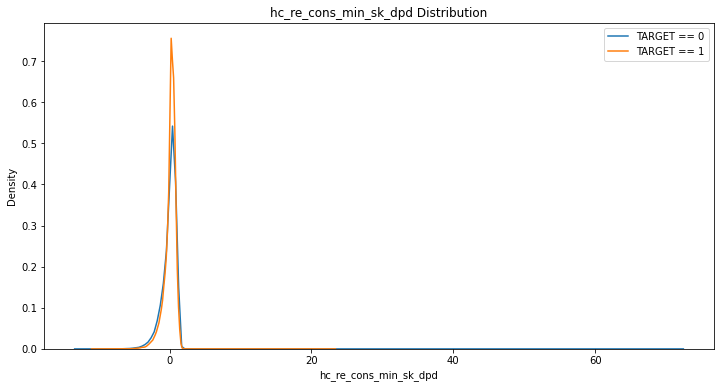

In [989]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_min_sk_dpd', app_train)

### hc_re_cons_sum_sk_dpd

In [990]:
app_train[['TARGET', 'hc_re_cons_sum_sk_dpd']].corr()

TARGET  hc_re_cons_sum_sk_dpd
TARGET                 1.000000              -0.004225
hc_re_cons_sum_sk_dpd -0.004225               1.000000

The correlation between hc_re_cons_sum_sk_dpd and the TARGET is -0.0042
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


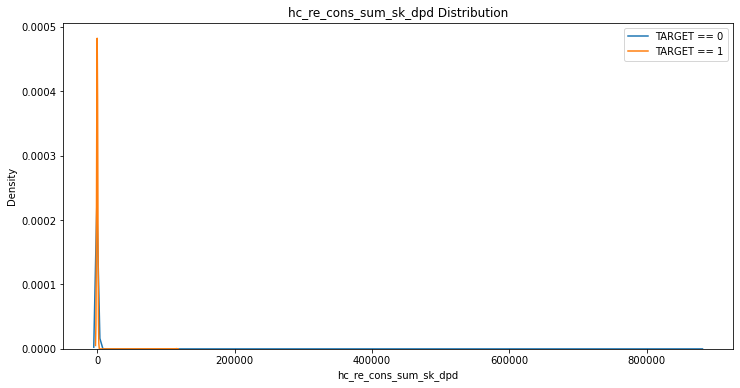

In [991]:
kde_target('hc_re_cons_sum_sk_dpd', app_train)

In [992]:
app_train['hc_re_cons_sum_sk_dpd'].isnull().sum()

286904

In [993]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_sum_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_sum_sk_dpd  
0  52.715068              -4.447804  
1  49.490411              -0.383883  
2  54.898630              -4.920098  
3  38.290411             -17.690201  
4  35.726027              -6.530945  

[5 rows x 92 columns]

In [994]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [995]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [996]:
app_train['hc_re_cons_sum_sk_dpd'].isnull().sum()

0

In [997]:
app_train[['TARGET', 'hc_re_cons_sum_sk_dpd']].corr()

TARGET  hc_re_cons_sum_sk_dpd
TARGET                 1.000000              -0.000914
hc_re_cons_sum_sk_dpd -0.000914               1.000000

In [998]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_sum_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_sum_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_sum_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_sum_sk_dpd']].corr()

TARGET  hc_re_cons_sum_sk_dpd
TARGET                 1.000000               0.018579
hc_re_cons_sum_sk_dpd  0.018579               1.000000

In [999]:
## 標準化
num_cols = ['hc_re_cons_sum_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_sum_sk_dpd', 'TARGET']].corr()

hc_re_cons_sum_sk_dpd    TARGET
hc_re_cons_sum_sk_dpd               1.000000  0.018579
TARGET                              0.018579  1.000000

The correlation between hc_re_cons_sum_sk_dpd and the TARGET is 0.0186
Median value for loan that was not repaid = 0.2347
Median value for loan that was repaid =     0.2262


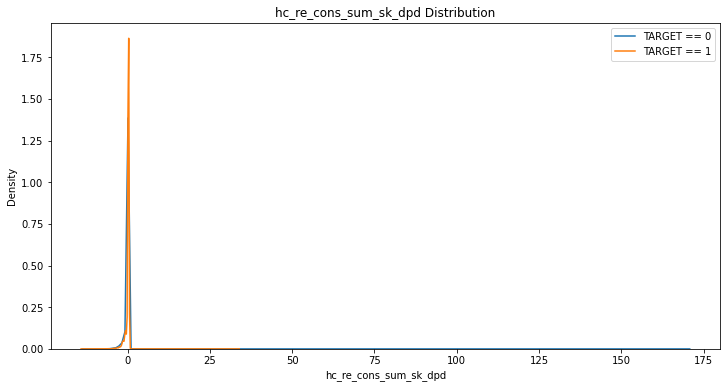

In [1000]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_sum_sk_dpd', app_train)

### hc_re_cons_avg_sk_dpd

In [1001]:
app_train[['TARGET', 'hc_re_cons_avg_sk_dpd']].corr()

TARGET  hc_re_cons_avg_sk_dpd
TARGET                 1.000000              -0.004339
hc_re_cons_avg_sk_dpd -0.004339               1.000000

The correlation between hc_re_cons_avg_sk_dpd and the TARGET is -0.0043
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


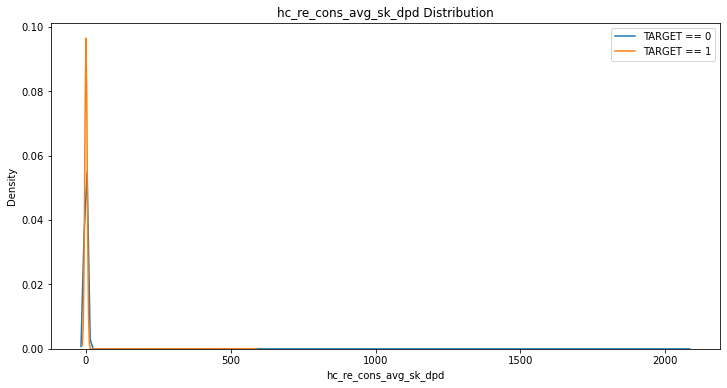

In [1002]:
kde_target('hc_re_cons_avg_sk_dpd', app_train)

In [1003]:
app_train['hc_re_cons_avg_sk_dpd'].isnull().sum()

286904

In [1004]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_avg_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_avg_sk_dpd  
0  52.715068               0.002490  
1  49.490411              -0.004750  
2  54.898630              -0.005176  
3  38.290411              -0.058449  
4  35.726027              -0.027766  

[5 rows x 92 columns]

In [1005]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1006]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1007]:
app_train['hc_re_cons_avg_sk_dpd'].isnull().sum()

0

In [1008]:
app_train[['TARGET', 'hc_re_cons_avg_sk_dpd']].corr()

TARGET  hc_re_cons_avg_sk_dpd
TARGET                 1.000000              -0.002833
hc_re_cons_avg_sk_dpd -0.002833               1.000000

In [1009]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_avg_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_avg_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_avg_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_avg_sk_dpd']].corr()

TARGET  hc_re_cons_avg_sk_dpd
TARGET                 1.000000               0.000055
hc_re_cons_avg_sk_dpd  0.000055               1.000000

In [1010]:
## 標準化
num_cols = ['hc_re_cons_avg_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_avg_sk_dpd', 'TARGET']].corr()

hc_re_cons_avg_sk_dpd    TARGET
hc_re_cons_avg_sk_dpd               1.000000  0.000055
TARGET                              0.000055  1.000000

The correlation between hc_re_cons_avg_sk_dpd and the TARGET is 0.0001
Median value for loan that was not repaid = 0.1814
Median value for loan that was repaid =     0.2011


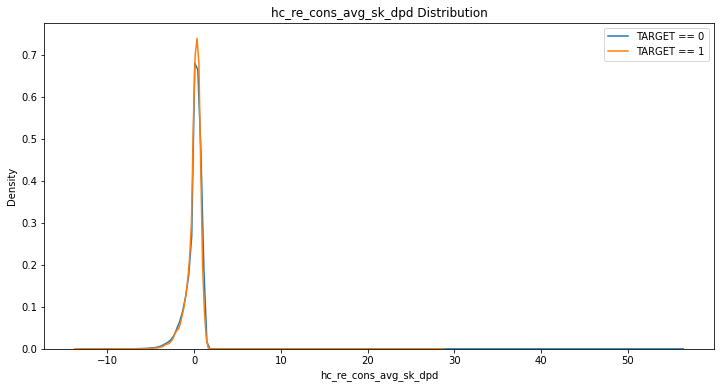

In [1011]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_avg_sk_dpd', app_train)

### hc_re_cons_cnt_sk_dpd

In [1012]:
app_train[['TARGET', 'hc_re_cons_cnt_sk_dpd']].corr()

TARGET  hc_re_cons_cnt_sk_dpd
TARGET                 1.000000              -0.023163
hc_re_cons_cnt_sk_dpd -0.023163               1.000000

The correlation between hc_re_cons_cnt_sk_dpd and the TARGET is -0.0232
Median value for loan that was not repaid = 64.0000
Median value for loan that was repaid =     81.0000


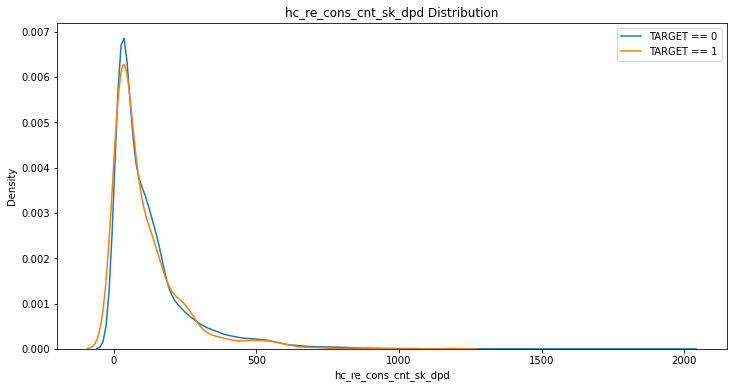

In [1013]:
kde_target('hc_re_cons_cnt_sk_dpd', app_train)

In [1014]:
app_train['hc_re_cons_cnt_sk_dpd'].isnull().sum()

286904

In [1015]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_cnt_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_cnt_sk_dpd  
0  52.715068             163.998265  
1  49.490411             157.286037  
2  54.898630             129.204913  
3  38.290411              72.600350  
4  35.726027             121.305041  

[5 rows x 92 columns]

In [1016]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1017]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1018]:
app_train['hc_re_cons_cnt_sk_dpd'].isnull().sum()

0

In [1019]:
app_train[['TARGET', 'hc_re_cons_cnt_sk_dpd']].corr()

TARGET  hc_re_cons_cnt_sk_dpd
TARGET                 1.00000               -0.01208
hc_re_cons_cnt_sk_dpd -0.01208                1.00000

In [1020]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_cnt_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_cnt_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_cnt_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_cnt_sk_dpd']].corr()

TARGET  hc_re_cons_cnt_sk_dpd
TARGET                 1.000000              -0.012089
hc_re_cons_cnt_sk_dpd -0.012089               1.000000

In [1021]:
## 標準化
num_cols = ['hc_re_cons_cnt_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_cnt_sk_dpd', 'TARGET']].corr()

hc_re_cons_cnt_sk_dpd    TARGET
hc_re_cons_cnt_sk_dpd               1.000000 -0.012089
TARGET                             -0.012089  1.000000

The correlation between hc_re_cons_cnt_sk_dpd and the TARGET is -0.0121
Median value for loan that was not repaid = -0.1295
Median value for loan that was repaid =     -0.0940


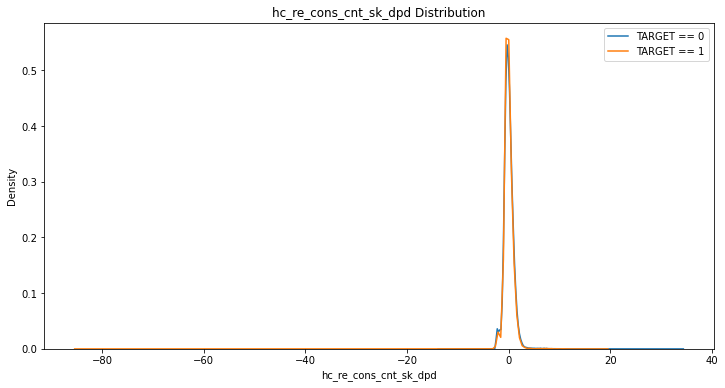

In [1022]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_cnt_sk_dpd', app_train)

### hc_re_cons_stddev_sk_dpd

In [1023]:
app_train[['TARGET', 'hc_re_cons_stddev_sk_dpd']].corr()

TARGET  hc_re_cons_stddev_sk_dpd
TARGET                    1.000000                 -0.004817
hc_re_cons_stddev_sk_dpd -0.004817                  1.000000

The correlation between hc_re_cons_stddev_sk_dpd and the TARGET is -0.0048
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


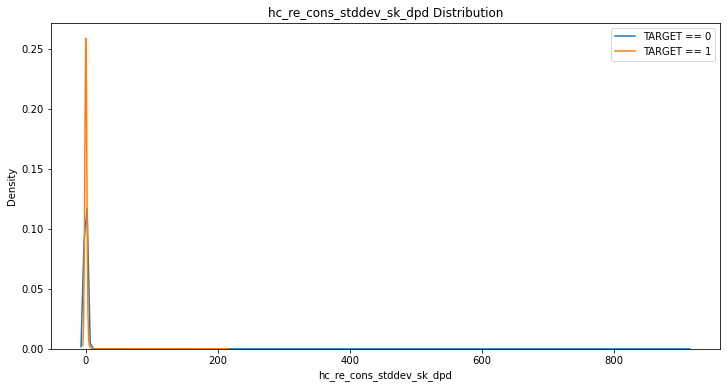

In [1024]:
kde_target('hc_re_cons_stddev_sk_dpd', app_train)

In [1025]:
app_train['hc_re_cons_stddev_sk_dpd'].isnull().sum()

286904

In [1026]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_sk_dpd  
0  52.715068                 -0.008892  
1  49.490411                 -0.004846  
2  54.898630                  0.002744  
3  38.290411                 -0.127090  
4  35.726027                 -0.043996  

[5 rows x 92 columns]

In [1027]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1028]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1029]:
app_train['hc_re_cons_stddev_sk_dpd'].isnull().sum()

0

In [1030]:
app_train[['TARGET', 'hc_re_cons_stddev_sk_dpd']].corr()

TARGET  hc_re_cons_stddev_sk_dpd
TARGET                    1.000000                 -0.006691
hc_re_cons_stddev_sk_dpd -0.006691                  1.000000

In [1031]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_stddev_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_stddev_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_stddev_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_stddev_sk_dpd']].corr()

TARGET  hc_re_cons_stddev_sk_dpd
TARGET                    1.000000                 -0.033449
hc_re_cons_stddev_sk_dpd -0.033449                  1.000000

In [1032]:
## 標準化
num_cols = ['hc_re_cons_stddev_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_sk_dpd', 'TARGET']].corr()

hc_re_cons_stddev_sk_dpd    TARGET
hc_re_cons_stddev_sk_dpd                  1.000000 -0.033449
TARGET                                   -0.033449  1.000000

The correlation between hc_re_cons_stddev_sk_dpd and the TARGET is -0.0334
Median value for loan that was not repaid = -0.0334
Median value for loan that was repaid =     0.0778


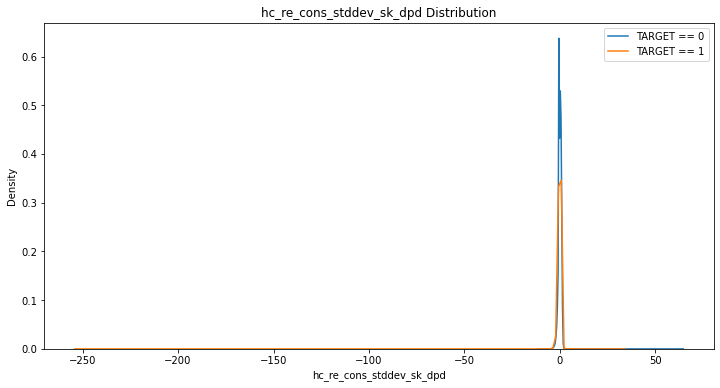

In [1033]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_sk_dpd', app_train)

### hc_re_cons_stddev_pop_sk_dpd

In [1034]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_sk_dpd']].corr()

TARGET  hc_re_cons_stddev_pop_sk_dpd
TARGET                        1.000000                     -0.004817
hc_re_cons_stddev_pop_sk_dpd -0.004817                      1.000000

The correlation between hc_re_cons_stddev_pop_sk_dpd and the TARGET is -0.0048
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


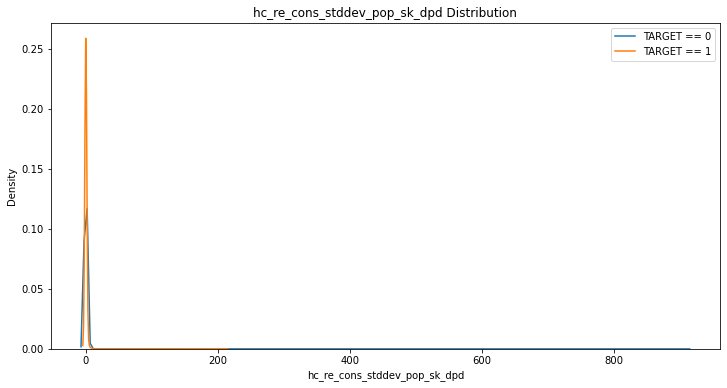

In [1035]:
kde_target('hc_re_cons_stddev_pop_sk_dpd', app_train)

In [1036]:
app_train['hc_re_cons_stddev_pop_sk_dpd'].isnull().sum()

286904

In [1037]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_stddev_pop_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_stddev_pop_sk_dpd  
0  52.715068                     -0.008892  
1  49.490411                     -0.004846  
2  54.898630                      0.002744  
3  38.290411                     -0.127090  
4  35.726027                     -0.043996  

[5 rows x 92 columns]

In [1038]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1039]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1040]:
app_train['hc_re_cons_stddev_pop_sk_dpd'].isnull().sum()

0

In [1041]:
app_train[['TARGET', 'hc_re_cons_stddev_pop_sk_dpd']].corr()

TARGET  hc_re_cons_stddev_pop_sk_dpd
TARGET                        1.000000                     -0.006691
hc_re_cons_stddev_pop_sk_dpd -0.006691                      1.000000

In [1042]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_stddev_pop_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_stddev_pop_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_stddev_pop_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_stddev_pop_sk_dpd']].corr()

TARGET  hc_re_cons_stddev_pop_sk_dpd
TARGET                        1.000000                     -0.033449
hc_re_cons_stddev_pop_sk_dpd -0.033449                      1.000000

In [1043]:
## 標準化
num_cols = ['hc_re_cons_stddev_pop_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_stddev_pop_sk_dpd', 'TARGET']].corr()

hc_re_cons_stddev_pop_sk_dpd    TARGET
hc_re_cons_stddev_pop_sk_dpd                      1.000000 -0.033449
TARGET                                           -0.033449  1.000000

The correlation between hc_re_cons_stddev_pop_sk_dpd and the TARGET is -0.0334
Median value for loan that was not repaid = -0.0334
Median value for loan that was repaid =     0.0778


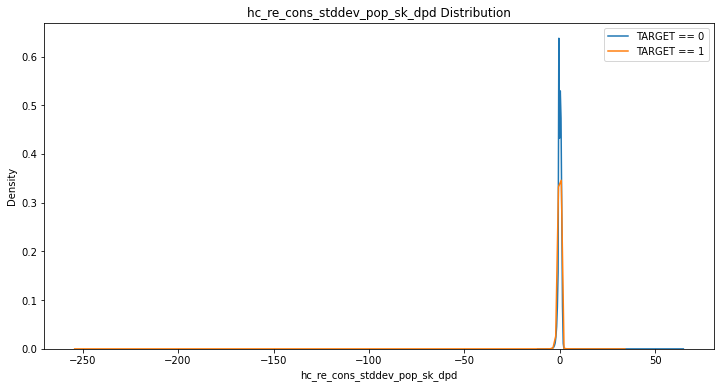

In [1044]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_stddev_pop_sk_dpd', app_train)

### hc_re_cons_var_pop_sk_dpd

In [1045]:
app_train[['TARGET', 'hc_re_cons_var_pop_sk_dpd']].corr()

TARGET  hc_re_cons_var_pop_sk_dpd
TARGET                     1.000000                  -0.005274
hc_re_cons_var_pop_sk_dpd -0.005274                   1.000000

The correlation between hc_re_cons_var_pop_sk_dpd and the TARGET is -0.0053
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


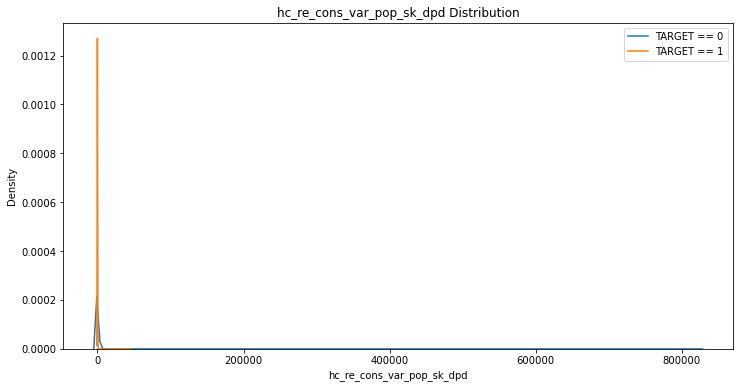

In [1046]:
kde_target('hc_re_cons_var_pop_sk_dpd', app_train)

In [1047]:
app_train['hc_re_cons_var_pop_sk_dpd'].isnull().sum()

286904

In [1048]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_var_pop_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_var_pop_sk_dpd  
0  52.715068                  -0.012128  
1  49.490411                  -0.084489  
2  54.898630                   0.132043  
3  38.290411                  -0.239257  
4  35.726027                  -0.063044  

[5 rows x 92 columns]

In [1049]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1050]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1051]:
app_train['hc_re_cons_var_pop_sk_dpd'].isnull().sum()

0

In [1052]:
app_train[['TARGET', 'hc_re_cons_var_pop_sk_dpd']].corr()

TARGET  hc_re_cons_var_pop_sk_dpd
TARGET                     1.000000                  -0.002795
hc_re_cons_var_pop_sk_dpd -0.002795                   1.000000

In [1053]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_var_pop_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_var_pop_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_var_pop_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_var_pop_sk_dpd']].corr()

TARGET  hc_re_cons_var_pop_sk_dpd
TARGET                     1.000000                  -0.006809
hc_re_cons_var_pop_sk_dpd -0.006809                   1.000000

In [1054]:
## 標準化
num_cols = ['hc_re_cons_var_pop_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_pop_sk_dpd', 'TARGET']].corr()

hc_re_cons_var_pop_sk_dpd    TARGET
hc_re_cons_var_pop_sk_dpd                   1.000000 -0.006809
TARGET                                     -0.006809  1.000000

The correlation between hc_re_cons_var_pop_sk_dpd and the TARGET is -0.0068
Median value for loan that was not repaid = -0.0102
Median value for loan that was repaid =     -0.0023


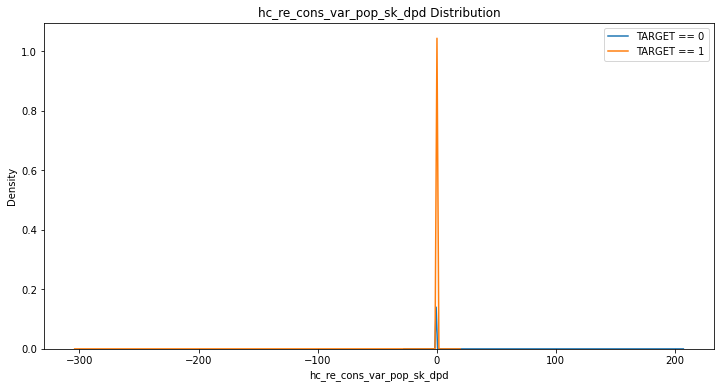

In [1055]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_pop_sk_dpd', app_train)

### hc_re_cons_var_samp_sk_dpd

In [1056]:
app_train[['TARGET', 'hc_re_cons_var_samp_sk_dpd']].corr()

TARGET  hc_re_cons_var_samp_sk_dpd
TARGET                      1.000000                   -0.005277
hc_re_cons_var_samp_sk_dpd -0.005277                    1.000000

The correlation between hc_re_cons_var_samp_sk_dpd and the TARGET is -0.0053
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


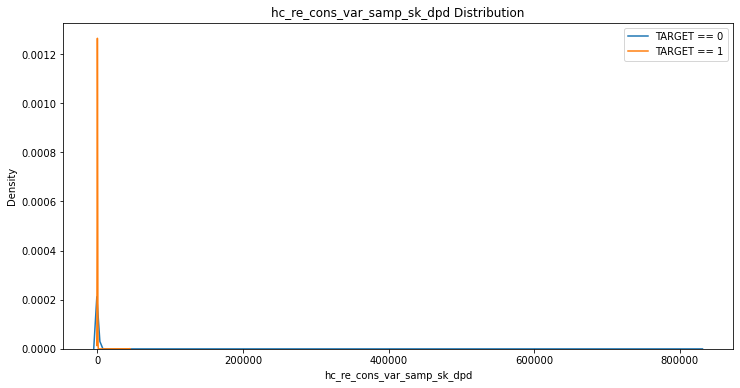

In [1057]:
kde_target('hc_re_cons_var_samp_sk_dpd', app_train)

In [1058]:
app_train['hc_re_cons_var_samp_sk_dpd'].isnull().sum()

286904

In [1059]:
# 欠損値を補完
#imputer = IterativeImputer()
#replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
#replace_columns.append('hc_re_cons_var_samp_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
#app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
#app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
#app_test_replace.head()

In [1060]:
# 欠損値を補完した列を再結合
#app_train[replace_columns] = app_train_replace[replace_columns]
#app_test[replace_columns] = app_test_replace[replace_columns]
#app_test_origin.head()

In [1061]:
# idをint型へ戻す
#app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
#app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
#app_test_origin.head()

In [1062]:
app_train['hc_re_cons_var_samp_sk_dpd'].isnull().sum()

286904

In [1063]:
app_train[['TARGET', 'hc_re_cons_var_samp_sk_dpd']].corr()

TARGET  hc_re_cons_var_samp_sk_dpd
TARGET                      1.000000                   -0.005277
hc_re_cons_var_samp_sk_dpd -0.005277                    1.000000

In [1064]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_var_samp_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_var_samp_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_var_samp_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_var_samp_sk_dpd']].corr()

TARGET  hc_re_cons_var_samp_sk_dpd
TARGET                      1.000000                    0.022891
hc_re_cons_var_samp_sk_dpd  0.022891                    1.000000

In [1065]:
## 標準化
num_cols = ['hc_re_cons_var_samp_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_var_samp_sk_dpd', 'TARGET']].corr()

hc_re_cons_var_samp_sk_dpd    TARGET
hc_re_cons_var_samp_sk_dpd                    1.000000  0.022891
TARGET                                        0.022891  1.000000

The correlation between hc_re_cons_var_samp_sk_dpd and the TARGET is 0.0229
Median value for loan that was not repaid = -0.1887
Median value for loan that was repaid =     -0.1887


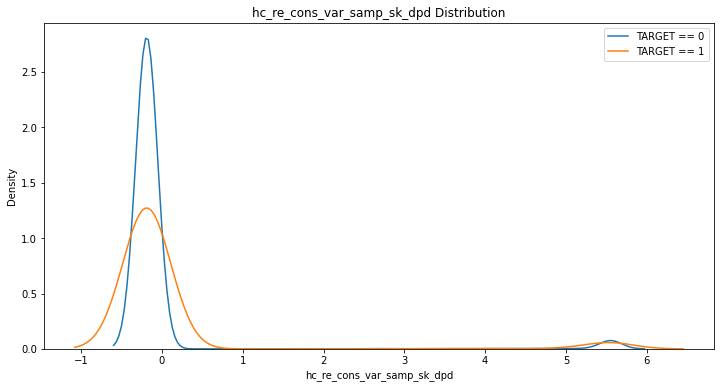

In [1066]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_var_samp_sk_dpd', app_train)

In [1067]:
columns = ['hc_re_cons_var_samp_sk_dpd']
app_train.drop(columns, axis=1, inplace=True)
app_test.drop(columns, axis=1, inplace=True)

In [1068]:
### hc_re_cons_variance_samp_sk_dpd

In [1069]:
app_train[['TARGET', 'hc_re_cons_variance_samp_sk_dpd']].corr()

TARGET  hc_re_cons_variance_samp_sk_dpd
TARGET                           1.000000                        -0.005274
hc_re_cons_variance_samp_sk_dpd -0.005274                         1.000000

The correlation between hc_re_cons_variance_samp_sk_dpd and the TARGET is -0.0053
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


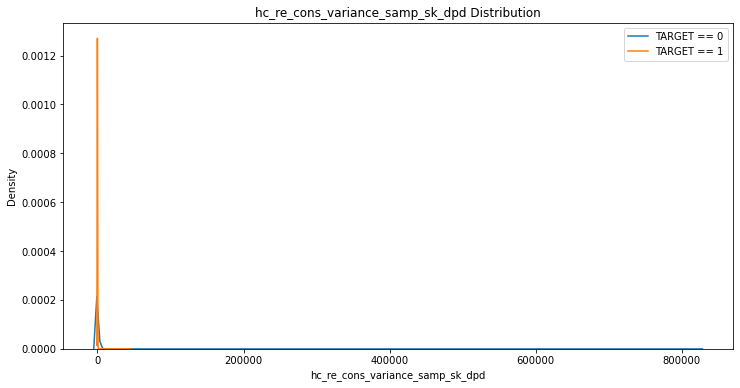

In [1070]:
kde_target('hc_re_cons_variance_samp_sk_dpd', app_train)

In [1071]:
app_train['hc_re_cons_variance_samp_sk_dpd'].isnull().sum()

286904

In [1072]:
# 欠損値を補完
imputer = IterativeImputer()
replace_columns = list(app_test_origin.select_dtypes(include='number').columns)
replace_columns.append('hc_re_cons_variance_samp_sk_dpd')
#replace_columns = ['br_min_credit_day_overdue']
app_train_replace = pd.DataFrame(imputer.fit_transform(app_train[replace_columns].copy()), columns=replace_columns)
app_test_replace = pd.DataFrame(imputer.fit_transform(app_test[replace_columns].copy()), columns=replace_columns)
app_test_replace.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0    100001.0                 0.0          0.0           0.0           0.0   
1    100005.0                 0.0          1.0           0.0           0.0   
2    100013.0                 0.0          1.0           1.0           0.0   
3    100028.0                 0.0          0.0           0.0           2.0   
4    100038.0                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  credit_goods_price_ratio  credit_downpayment  \
0             19.775662                    1.2640           -118800.0   
1             74.467617                    1.2376            -42768.0   
2              1.934735                    1.0528            -33264.0   
3              6.378867                    1.0000                 0.0   
4             15.997755                    1.0000                 0.0   

     AGE_INT  hc_re_cons_variance_samp_sk_dpd  
0  52.715068                        -0.012128  
1  49.490411                        -0.084489  
2  54.898630                         0.132043  
3  38.290411                        -0.239257  
4  35.726027                        -0.063044  

[5 rows x 92 columns]

In [1073]:
# 欠損値を補完した列を再結合
app_train[replace_columns] = app_train_replace[replace_columns]
app_test[replace_columns] = app_test_replace[replace_columns]
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1074]:
# idをint型へ戻す
app_train_origin['SK_ID_CURR'] = app_train_origin[["SK_ID_CURR"]].astype(int) 
app_test_origin['SK_ID_CURR'] = app_test_origin[["SK_ID_CURR"]].astype(int)
app_test_origin.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0               0.0  ...               0.0                   0.000000   
1               0.0  ...               0.0                   0.000000   
2               0.0  ...               0.0                   0.000000   
3               0.0  ...               0.0                   0.000000   
4               0.0  ...               0.0                   0.010242   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                    0.000000     0.036147               0.121044   
1                    3.000000     0.077973               0.247398   
2                    4.000000     0.105202               0.222477   
3                    3.000000     0.031123               0.133515   
4                    1.748333     0.051266               0.168021   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             19.775662               False                    1.2640   
1             74.467617               False                    1.2376   
2              1.934735               False                    1.0528   
3              6.378867               False                    1.0000   
4             15.997755               False                    1.0000   

   credit_downpayment    AGE_INT  
0           -118800.0  52.715068  
1            -42768.0  49.490411  
2            -33264.0  54.898630  
3                 0.0  38.290411  
4                 0.0  35.726027  

[5 rows x 92 columns]

In [1075]:
app_train['hc_re_cons_variance_samp_sk_dpd'].isnull().sum()

0

In [1076]:
app_train[['TARGET', 'hc_re_cons_variance_samp_sk_dpd']].corr()

TARGET  hc_re_cons_variance_samp_sk_dpd
TARGET                           1.000000                        -0.002795
hc_re_cons_variance_samp_sk_dpd -0.002795                         1.000000

In [1077]:
## Yao-Johnson変換
num_cols = ['hc_re_cons_variance_samp_sk_dpd']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['hc_re_cons_variance_samp_sk_dpd'] = pt.transform(app_train[num_cols])
app_test['hc_re_cons_variance_samp_sk_dpd'] = pt.transform(app_test[num_cols])

## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'hc_re_cons_variance_samp_sk_dpd']].corr()

TARGET  hc_re_cons_variance_samp_sk_dpd
TARGET                           1.000000                        -0.006809
hc_re_cons_variance_samp_sk_dpd -0.006809                         1.000000

In [1078]:
## 標準化
num_cols = ['hc_re_cons_variance_samp_sk_dpd']
scaler = StandardScaler()
scaler.fit(app_train[num_cols])

app_train[num_cols] = scaler.transform(app_train[num_cols])
app_test[num_cols] = scaler.transform(app_test[num_cols])
app_train[['hc_re_cons_variance_samp_sk_dpd', 'TARGET']].corr()

hc_re_cons_variance_samp_sk_dpd    TARGET
hc_re_cons_variance_samp_sk_dpd                         1.000000 -0.006809
TARGET                                                 -0.006809  1.000000

The correlation between hc_re_cons_variance_samp_sk_dpd and the TARGET is -0.0068
Median value for loan that was not repaid = -0.0102
Median value for loan that was repaid =     -0.0023


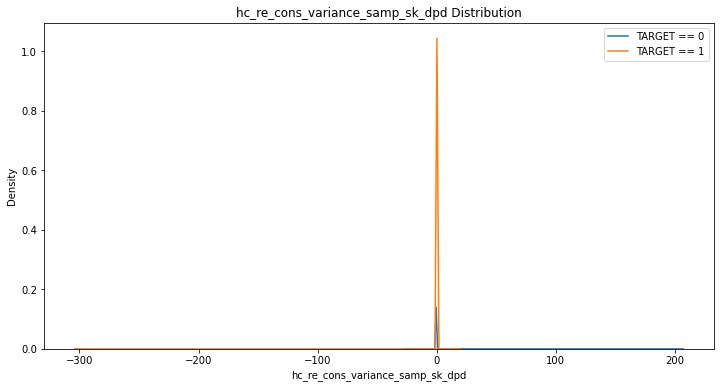

In [1079]:
## Yao-Johnson変換後の特徴量の分布
kde_target('hc_re_cons_variance_samp_sk_dpd', app_train)

## CSVをEXPORT

In [1080]:
app_train['SK_ID_CURR'] = app_train[["SK_ID_CURR"]].astype(int) 
app_test['SK_ID_CURR'] = app_test[["SK_ID_CURR"]].astype(int)
app_test.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  CNT_CHILDREN  \
0      100001                 0.0          0.0           0.0           0.0   
1      100005                 0.0          1.0           0.0           0.0   
2      100013                 0.0          1.0           1.0           0.0   
3      100028                 0.0          0.0           0.0           2.0   
4      100038                 0.0          1.0           1.0           1.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          135000.0    568800.0      20560.5         450000.0   
1           99000.0    222768.0      17370.0         180000.0   
2          202500.0    663264.0      69777.0         630000.0   
3          315000.0   1575000.0      49018.5        1575000.0   
4          180000.0    625500.0      32067.0         625500.0   

   NAME_INCOME_TYPE  ...  hc_re_cons_variance_samp_rate_interest_privileged  \
0               0.0  ...                                          -2.291357   
1               0.0  ...                                           7.698166   
2               0.0  ...                                           7.691162   
3               0.0  ...                                          -4.273264   
4               0.0  ...                                           8.417695   

   hc_re_cons_max_sk_dpd  hc_re_cons_min_sk_dpd  hc_re_cons_sum_sk_dpd  \
0              -0.221002               0.187722               0.046201   
1              -0.201620               0.187722               0.058403   
2              -0.189065               0.187722               0.044615   
3              -0.448954               0.187722              -0.005008   
4              -0.267870               0.187722               0.039024   

   hc_re_cons_avg_sk_dpd  hc_re_cons_cnt_sk_dpd  hc_re_cons_stddev_sk_dpd  \
0               0.011037               0.319157                 -0.582897   
1               0.006960               0.198028                 -0.575759   
2               0.006719              -0.307754                 -0.562412   
3              -0.023725              -1.321208                 -0.798834   
4              -0.006098              -0.449730                 -0.645546   

   hc_re_cons_stddev_pop_sk_dpd  hc_re_cons_var_pop_sk_dpd  \
0                     -0.582897                  -0.370293   
1                     -0.575759                  -0.370494   
2                     -0.562412                  -0.369902   
3                     -0.798834                  -0.370931   
4                     -0.645546                  -0.370434   

   hc_re_cons_variance_samp_sk_dpd  
0                        -0.370293  
1                        -0.370494  
2                        -0.369902  
3                        -0.370931  
4                        -0.370434  

[5 rows x 178 columns]

In [1081]:
app_train.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                 0.0          1.0           0.0   
1      100003       0                 0.0          0.0           0.0   
2      100004       0                 1.0          1.0           1.0   
3      100006       0                 0.0          0.0           0.0   
4      100007       0                 0.0          1.0           0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           0.0          202500.0    406597.5      24700.5         351000.0   
1           0.0          270000.0   1293502.5      35698.5        1129500.0   
2           0.0           67500.0    135000.0       6750.0         135000.0   
3           0.0          135000.0    312682.5      29686.5         297000.0   
4           0.0          121500.0    513000.0      21865.5         513000.0   

   ...  hc_re_cons_variance_samp_rate_interest_privileged  \
0  ...                                          -0.355567   
1  ...                                          -0.229200   
2  ...                                          -1.204110   
3  ...                                           0.068768   
4  ...                                          -1.542637   

   hc_re_cons_max_sk_dpd  hc_re_cons_min_sk_dpd  hc_re_cons_sum_sk_dpd  \
0              -0.084506               0.195024               0.286131   
1              -1.959827              -1.838999              -1.256639   
2              -0.198441               0.187722               0.059347   
3               0.070916               0.850526               0.315517   
4               0.310938               0.217133               0.236815   

   hc_re_cons_avg_sk_dpd  hc_re_cons_cnt_sk_dpd  hc_re_cons_stddev_sk_dpd  \
0               0.028207              -0.185807                 -0.453571   
1              -2.158378               0.465464                 -1.009195   
2               0.009637              -2.543880                 -0.567230   
3               0.096725              -0.733422                 -0.874109   
4               0.158444              -0.335089                  0.271508   

   hc_re_cons_stddev_pop_sk_dpd  hc_re_cons_var_pop_sk_dpd  \
0                     -0.453571                  -0.131680   
1                     -1.009195                   0.086914   
2                     -0.567230                  -0.370260   
3                     -0.874109                  -0.130120   
4                      0.271508                  -0.050526   

   hc_re_cons_variance_samp_sk_dpd  
0                        -0.131680  
1                         0.086914  
2                        -0.370260  
3                        -0.130120  
4                        -0.050526  

[5 rows x 179 columns]

In [1082]:
remove_columns = list(app_test_origin.columns)
remove_columns.remove('SK_ID_CURR')
remove_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_M

In [1083]:
app_train.drop(remove_columns, axis=1, inplace=True)
app_test.drop(remove_columns, axis=1, inplace=True)
app_br_train = app_train.copy()
app_br_test = app_test.copy()
app_br_test.head()

SK_ID_CURR  hc_re_cons_max_amt_annuity  hc_re_cons_min_amt_annuity  \
0      100001                    1.314935                    1.390156   
1      100005                   -0.513451                   -0.556219   
2      100013                    1.891022                    1.941740   
3      100028                    4.490115                    4.205356   
4      100038                    1.704135                    1.777100   

   hc_re_cons_sum_amt_annuity  hc_re_cons_avg_amt_annuity  \
0                    0.478974                    1.350061   
1                    0.044187                   -0.508158   
2                    0.649639                    1.885791   
3                    1.725266                    4.105303   
4                    0.614731                    1.714999   

   hc_re_cons_cnt_amt_annuity  hc_re_cons_stddev_amt_annuity  \
0                    0.319157                      -0.337491   
1                    0.198028                      -0.065583   
2                   -0.307754                      -0.506437   
3                   -1.321208                      -1.439566   
4                   -0.449730                      -0.504645   

   hc_re_cons_stddev_pop_amt_annuity  hc_re_cons_var_pop_amt_annuity  \
0                          -0.337491                       -0.182775   
1                          -0.065583                       -0.088035   
2                          -0.506437                       -0.231111   
3                          -1.439566                       -0.534358   
4                          -0.504645                       -0.228756   

   hc_re_cons_var_samp_amt_annuity  ...  \
0                        -0.185601  ...   
1                        -0.090206  ...   
2                        -0.234006  ...   
3                        -0.538993  ...   
4                        -0.231637  ...   

   hc_re_cons_variance_samp_rate_interest_privileged  hc_re_cons_max_sk_dpd  \
0                                          -2.291357              -0.221002   
1                                           7.698166              -0.201620   
2                                           7.691162              -0.189065   
3                                          -4.273264              -0.448954   
4                                           8.417695              -0.267870   

   hc_re_cons_min_sk_dpd  hc_re_cons_sum_sk_dpd  hc_re_cons_avg_sk_dpd  \
0               0.187722               0.046201               0.011037   
1               0.187722               0.058403               0.006960   
2               0.187722               0.044615               0.006719   
3               0.187722              -0.005008              -0.023725   
4               0.187722               0.039024              -0.006098   

   hc_re_cons_cnt_sk_dpd  hc_re_cons_stddev_sk_dpd  \
0               0.319157                 -0.582897   
1               0.198028                 -0.575759   
2              -0.307754                 -0.562412   
3              -1.321208                 -0.798834   
4              -0.449730                 -0.645546   

   hc_re_cons_stddev_pop_sk_dpd  hc_re_cons_var_pop_sk_dpd  \
0                     -0.582897                  -0.370293   
1                     -0.575759                  -0.370494   
2                     -0.562412                  -0.369902   
3                     -0.798834                  -0.370931   
4                     -0.645546                  -0.370434   

   hc_re_cons_variance_samp_sk_dpd  
0                        -0.370293  
1                        -0.370494  
2                        -0.369902  
3                        -0.370931  
4                        -0.370434  

[5 rows x 87 columns]

In [1084]:
### train
app_train.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_only-rev-cons_train_axis-24.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1085]:
### test
app_test.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_only-rev-cons_test_axis-24.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1086]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [1087]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]


y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [1088]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[22:48:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.64193	eval-auc:0.62080
[1]	train-auc:0.65573	eval-auc:0.63075
[2]	train-auc:0.66354	eval-auc:0.63607
[3]	train-auc:0.66922	eval-auc:0.63729
[4]	train-auc:0.67177	eval-auc:0.63795
[5]	train-auc:0.67395	eval-auc:0.63917
[6]	train-auc:0.67772	eval-auc:0.64024
[7]	train-auc:0.68148	eval-auc:0.64082
[8]	train-auc:0.68485	eval-auc:0.64178
[9]	train-auc:0.68721	eval-auc:0.64249
[10]	train-auc:0.69063	eval-auc:0.64329
[11]	train-auc:0.69341	eval-auc:0.64446
[12]	train-auc:0.69494	eval-auc:0.64499
[13]	train-auc:0.69623	eval-auc:0.64589
[14

[12]	train-auc:0.69722	eval-auc:0.63826
[13]	train-auc:0.69915	eval-auc:0.63882
[14]	train-auc:0.70134	eval-auc:0.63917
[15]	train-auc:0.70360	eval-auc:0.63971
[16]	train-auc:0.70554	eval-auc:0.64039
[17]	train-auc:0.70741	eval-auc:0.64089
[18]	train-auc:0.70883	eval-auc:0.64102
[19]	train-auc:0.71080	eval-auc:0.64121
[20]	train-auc:0.71213	eval-auc:0.64132
[21]	train-auc:0.71419	eval-auc:0.64158
[22]	train-auc:0.71610	eval-auc:0.64163
[23]	train-auc:0.71716	eval-auc:0.64163
[24]	train-auc:0.71869	eval-auc:0.64224
[25]	train-auc:0.72024	eval-auc:0.64284
[26]	train-auc:0.72205	eval-auc:0.64307
[27]	train-auc:0.72292	eval-auc:0.64309
[28]	train-auc:0.72448	eval-auc:0.64350
[29]	train-auc:0.72641	eval-auc:0.64350
[30]	train-auc:0.72844	eval-auc:0.64350
[31]	train-auc:0.72969	eval-auc:0.64364
[32]	train-auc:0.73208	eval-auc:0.64438
[33]	train-auc:0.73405	eval-auc:0.64410
[34]	train-auc:0.73651	eval-auc:0.64465
[35]	train-auc:0.73819	eval-auc:0.64453
[36]	train-auc:0.74077	eval-auc:0.64478


In [1089]:
remove_columns = ['TARGET']
app_br_train.drop(remove_columns, axis=1, inplace=True)
app_br_train.head()

SK_ID_CURR  hc_re_cons_max_amt_annuity  hc_re_cons_min_amt_annuity  \
0      100002                   -0.027855                   -0.293484   
1      100003                    1.470996                    1.738609   
2      100004                   -2.865727                   -2.077729   
3      100006                   -0.569478                   -0.799812   
4      100007                   -0.235116                   -0.033558   

   hc_re_cons_sum_amt_annuity  hc_re_cons_avg_amt_annuity  \
0                   -0.200167                   -0.200799   
1                    1.341890                    1.703624   
2                   -4.289031                   -2.480220   
3                   -0.502458                   -0.844425   
4                   -0.099457                   -0.081708   

   hc_re_cons_cnt_amt_annuity  hc_re_cons_stddev_amt_annuity  \
0                   -0.185807                      -0.051311   
1                    0.465464                       1.467923   
2                   -2.543880                      -1.248164   
3                   -0.733422                      -1.079244   
4                   -0.335089                      -0.274156   

   hc_re_cons_stddev_pop_amt_annuity  hc_re_cons_var_pop_amt_annuity  \
0                          -0.051311                       -0.136568   
1                           1.467923                        0.684667   
2                          -1.248164                       -0.769693   
3                          -1.079244                       -0.286449   
4                          -0.274156                       -0.081752   

   hc_re_cons_var_samp_amt_annuity  ...  \
0                        -0.136550  ...   
1                         0.682133  ...   
2                        -0.768887  ...   
3                        -0.285409  ...   
4                        -0.080351  ...   

   hc_re_cons_variance_samp_rate_interest_privileged  hc_re_cons_max_sk_dpd  \
0                                          -0.355567              -0.084506   
1                                          -0.229200              -1.959827   
2                                          -1.204110              -0.198441   
3                                           0.068768               0.070916   
4                                          -1.542637               0.310938   

   hc_re_cons_min_sk_dpd  hc_re_cons_sum_sk_dpd  hc_re_cons_avg_sk_dpd  \
0               0.195024               0.286131               0.028207   
1              -1.838999              -1.256639              -2.158378   
2               0.187722               0.059347               0.009637   
3               0.850526               0.315517               0.096725   
4               0.217133               0.236815               0.158444   

   hc_re_cons_cnt_sk_dpd  hc_re_cons_stddev_sk_dpd  \
0              -0.185807                 -0.453571   
1               0.465464                 -1.009195   
2              -2.543880                 -0.567230   
3              -0.733422                 -0.874109   
4              -0.335089                  0.271508   

   hc_re_cons_stddev_pop_sk_dpd  hc_re_cons_var_pop_sk_dpd  \
0                     -0.453571                  -0.131680   
1                     -1.009195                   0.086914   
2                     -0.567230                  -0.370260   
3                     -0.874109                  -0.130120   
4                      0.271508                  -0.050526   

   hc_re_cons_variance_samp_sk_dpd  
0                        -0.131680  
1                         0.086914  
2                        -0.370260  
3                        -0.130120  
4                        -0.050526  

[5 rows x 87 columns]

In [1090]:
# trainへマージ
app_train = pd.merge(app_train_origin.copy(), app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test_origin.copy(), app_br_test, on='SK_ID_CURR', how='left')
app_train.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                 0.0          1.0           0.0   
1      100003       0                 0.0          0.0           0.0   
2      100004       0                 1.0          1.0           1.0   
3      100006       0                 0.0          0.0           0.0   
4      100007       0                 0.0          1.0           0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           0.0          202500.0    406597.5      24700.5         351000.0   
1           0.0          270000.0   1293502.5      35698.5        1129500.0   
2           0.0           67500.0    135000.0       6750.0         135000.0   
3           0.0          135000.0    312682.5      29686.5         297000.0   
4           0.0          121500.0    513000.0      21865.5         513000.0   

   ...  hc_re_cons_variance_samp_rate_interest_privileged  \
0  ...                                          -0.355567   
1  ...                                          -0.229200   
2  ...                                          -1.204110   
3  ...                                           0.068768   
4  ...                                          -1.542637   

   hc_re_cons_max_sk_dpd  hc_re_cons_min_sk_dpd  hc_re_cons_sum_sk_dpd  \
0              -0.084506               0.195024               0.286131   
1              -1.959827              -1.838999              -1.256639   
2              -0.198441               0.187722               0.059347   
3               0.070916               0.850526               0.315517   
4               0.310938               0.217133               0.236815   

   hc_re_cons_avg_sk_dpd  hc_re_cons_cnt_sk_dpd  hc_re_cons_stddev_sk_dpd  \
0               0.028207              -0.185807                 -0.453571   
1              -2.158378               0.465464                 -1.009195   
2               0.009637              -2.543880                 -0.567230   
3               0.096725              -0.733422                 -0.874109   
4               0.158444              -0.335089                  0.271508   

   hc_re_cons_stddev_pop_sk_dpd  hc_re_cons_var_pop_sk_dpd  \
0                     -0.453571                  -0.131680   
1                     -1.009195                   0.086914   
2                     -0.567230                  -0.370260   
3                     -0.874109                  -0.130120   
4                      0.271508                  -0.050526   

   hc_re_cons_variance_samp_sk_dpd  
0                        -0.131680  
1                         0.086914  
2                        -0.370260  
3                        -0.130120  
4                        -0.050526  

[5 rows x 179 columns]

In [1091]:
columns = list(app_train.columns)
columns

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVIN

In [1092]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [1093]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]

y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [1094]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[22:49:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.73068	eval-auc:0.71618
[1]	train-auc:0.74511	eval-auc:0.72257
[2]	train-auc:0.75659	eval-auc:0.73011
[3]	train-auc:0.76148	eval-auc:0.73322
[4]	train-auc:0.76420	eval-auc:0.73476
[5]	train-auc:0.76712	eval-auc:0.73658
[6]	train-auc:0.77118	eval-auc:0.73792
[7]	train-auc:0.77354	eval-auc:0.73819
[8]	train-auc:0.77534	eval-auc:0.73895
[9]	train-auc:0.77786	eval-auc:0.73930
[10]	train-auc:0.77912	eval-auc:0.73997
[11]	train-auc:0.78055	eval-auc:0.74108
[12]	train-auc:0.78198	eval-auc:0.74173
[13]	train-auc:0.78332	eval-auc:0.74261
[14

[12]	train-auc:0.78323	eval-auc:0.73771
[13]	train-auc:0.78455	eval-auc:0.73784
[14]	train-auc:0.78608	eval-auc:0.73867
[15]	train-auc:0.78775	eval-auc:0.73907
[16]	train-auc:0.78952	eval-auc:0.73969
[17]	train-auc:0.79062	eval-auc:0.74028
[18]	train-auc:0.79260	eval-auc:0.74096
[19]	train-auc:0.79448	eval-auc:0.74129
[20]	train-auc:0.79598	eval-auc:0.74168
[21]	train-auc:0.79759	eval-auc:0.74211
[22]	train-auc:0.79897	eval-auc:0.74256
[23]	train-auc:0.80070	eval-auc:0.74302
[24]	train-auc:0.80249	eval-auc:0.74374
[25]	train-auc:0.80405	eval-auc:0.74435
[26]	train-auc:0.80548	eval-auc:0.74477
[27]	train-auc:0.80719	eval-auc:0.74502
[28]	train-auc:0.80807	eval-auc:0.74528
[29]	train-auc:0.80979	eval-auc:0.74620
[30]	train-auc:0.81133	eval-auc:0.74664
[31]	train-auc:0.81257	eval-auc:0.74691
[32]	train-auc:0.81428	eval-auc:0.74705
[33]	train-auc:0.81568	eval-auc:0.74742
[34]	train-auc:0.81733	eval-auc:0.74791
[35]	train-auc:0.81852	eval-auc:0.74820
[36]	train-auc:0.81973	eval-auc:0.74896


In [1095]:
# CSV-00
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[0]
submit_all.isnull().sum()

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_00.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1096]:
# CSV-01
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[1]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_01.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1097]:
# CSV-02
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[2]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_02.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1098]:
# CSV-03
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[3]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_03.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1099]:
# CSV-04
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[4]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_04.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [1100]:
submit_all_00 = pd.read_csv('./home-credit-default-risk/submit/submit_all_00.csv')
submit_all_01 = pd.read_csv('./home-credit-default-risk/submit/submit_all_01.csv')
submit_all_02 = pd.read_csv('./home-credit-default-risk/submit/submit_all_02.csv')
submit_all_03 = pd.read_csv('./home-credit-default-risk/submit/submit_all_03.csv')
submit_all_04 = pd.read_csv('./home-credit-default-risk/submit/submit_all_04.csv')

In [1101]:
submit_all = pd.DataFrame({
    'submit_all_00': submit_all_00['TARGET'].values
    ,'submit_all_01': submit_all_01['TARGET'].values
    ,'submit_all_02': submit_all_02['TARGET'].values
    ,'submit_all_03': submit_all_03['TARGET'].values
    ,'submit_all_04': submit_all_04['TARGET'].values
    })
submit_all.head()

submit_all_00  submit_all_01  submit_all_02  submit_all_03  submit_all_04
0       0.104547       0.072211       0.093452       0.059520       0.067013
1       0.161405       0.110973       0.206583       0.155413       0.241001
2       0.032136       0.021147       0.055456       0.025664       0.092318
3       0.025135       0.058595       0.043945       0.054520       0.040555
4       0.089924       0.103021       0.118467       0.098253       0.120443

In [1102]:
submit_all = app_test[["SK_ID_CURR"]].astype(int).copy()
submit_all['TARGET'] = (submit_all_00['TARGET'] + submit_all_01['TARGET'] + submit_all_02['TARGET'] + submit_all_03['TARGET'] + submit_all_04['TARGET'])/5
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.079348
1      100005  0.175075
2      100013  0.045344
3      100028  0.044550
4      100038  0.106022

In [1103]:
submit_all['TARGET'] = (submit_all['TARGET'] / 5)
submit_all.to_csv('./home-credit-default-risk/submit/submit_hc_only-rev-cons_test_axis-24.csv', index=False)
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.015870
1      100005  0.035015
2      100013  0.009069
3      100028  0.008910
4      100038  0.021204

In [1104]:
submit_all.count()

SK_ID_CURR    48744
TARGET        48744
dtype: int64